In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import os
import shutil
import seaborn as sns
from scipy import stats
from ptm_dict import modres
from adjustText import adjust_text
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
from scipy.stats import ttest_rel
from sklearn.metrics import roc_curve, auc

In [2]:
# Block of seaborn style settings
plt.rc('font', size=23) #controls default text size
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=18) #fontsize of the x tick labels
plt.rc('ytick', labelsize=18) #fontsize of the y tick labels
sns.set(style='whitegrid', color_codes=True, font='serif', font_scale=2)

plt.rc('font', size=23) #controls default text size
plt.rc('xtick', labelsize=25) #fontsize of the x tick labels
plt.rc('ytick', labelsize=25) #fontsize of the y tick labels

In [3]:
skempiMAX_cart_ddg_IA = pd.read_csv('skempiMAX_cart_ddg_IA.csv')
safes_sing = pd.read_csv('SAFES_051025.csv')
safes_sing = safes_sing.loc[(safes_sing['PDB_ID']!='1DAN')&(~safes_sing['mean_ddG_infc_af2'].isna())]
SAFES_exp = pd.merge(safes_sing, skempiMAX_cart_ddg_IA, 
                     on=['PDB_ID', 'variant'], how='left')
SAFES_exp = SAFES_exp.loc[~SAFES_exp['ddG_bind'].isna()].copy()

In [5]:
SAFES_exp['interaction_strength'].value_counts()

interaction_strength
strong      943
moderate    261
weak        120
Name: count, dtype: int64

In [11]:
SAFES_exp.loc[SAFES_exp['interaction_strength']=='strong']['PDB_ID'].unique()

array(['1R0R', '1CHO', '2FTL', '3BN9', '2J0T', '1PPF', '3HFM', '1JTG',
       '3SGB', '1IAR'], dtype=object)

In [12]:
SAFES_exp.loc[SAFES_exp['interaction_strength']=='moderate']['PDB_ID'].unique()

array(['1MHP', '5E9D', '1VFB', '2J0T', '3HFM', '1JTG', '2JEL', '3MZG',
       '1KTZ', '1AO7', '3SZK'], dtype=object)

In [13]:
SAFES_exp.loc[SAFES_exp['interaction_strength']=='weak']['PDB_ID'].unique()

array(['3MZG', '1OGA', '1KNE', '1AO7'], dtype=object)

In [17]:
SAFES_exp.groupby(['PDB_ID', 'Affinity_wt_parsed']).count()

variant  mean_ddG_xtal  std_ddG_xtal  \
PDB_ID Affinity_wt_parsed                                         
1AO7   8.800000e-07             20             20            20   
       9.100000e-07              2              2             2   
       1.800000e-06              1              1             1   
       1.940000e-06              1              1             1   
       1.950000e-06              1              1             1   
...                            ...            ...           ...   
3MZG   1.700000e-05              5              5             5   
       2.000000e-05              2              2             2   
3SGB   1.790000e-11            191            191           191   
3SZK   1.700000e-08             21             21            21   
5E9D   1.370000e-07              5              5             5   

                           mean_ddG_infc_xtal  std_ddG_infc_xtal  \
PDB_ID Affinity_wt_parsed                                          
1AO7   8.800000e-07                        20                 20   
       9.100000e-07                         2                  2   
       1.800000e-06                         1                  1   
       1.940000e-06                         1                  1   
       1.950000e-06                         1                  1   
...                                       ...                ...   
3MZG   1.700000e-05                         5                  5   
       2.000000e-05                         2                  2   
3SGB   1.790000e-11                       191                191   
3SZK   1.700000e-08                        21                 21   
5E9D   1.370000e-07                         5                  5   

                           mean_ddG_af2  std_ddG_af2  mean_ddG_infc_af2  \
PDB_ID Affinity_wt_parsed                                                 
1AO7   8.800000e-07                  20           20                 20   
       9.100000e-07                   2            2                  2   
       1.800000e-06                   1            1                  1   
       1.940000e-06                   1            1                  1   
       1.950000e-06                   1            1                  1   
...                                 ...          ...                ...   
3MZG   1.700000e-05                   5            5                  5   
       2.000000e-05                   2            2                  2   
3SGB   1.790000e-11                 191          191                191   
3SZK   1.700000e-08                  21           21                 21   
5E9D   1.370000e-07                   5            5                  5   

                           std_ddG_infc_af2  mean_ddG_af3  ...  dG_bind_MUT  \
PDB_ID Affinity_wt_parsed                                  ...                
1AO7   8.800000e-07                      20            20  ...           20   
       9.100000e-07                       2             2  ...            2   
       1.800000e-06                       1             1  ...            1   
       1.940000e-06                       1             1  ...            1   
       1.950000e-06                       1             1  ...            1   
...                                     ...           ...  ...          ...   
3MZG   1.700000e-05                       5             5  ...            5   
       2.000000e-05                       2             2  ...            2   
3SGB   1.790000e-11                     191           191  ...          191   
3SZK   1.700000e-08                      21            21  ...           21   
5E9D   1.370000e-07                       5             5  ...            5   

                           ddG_bind  LChains  RChains  Chains  small-to-large  \
PDB_ID Affinity_wt_parsed                                                       
1AO7   8.800000e-07              20       20       20      20              20   
       9.100000e-07    

In [22]:
safes_exp_wt_avg = SAFES_exp[['PDB_ID', 'Affinity_wt_parsed', 'dG_bind_WT']].groupby('PDB_ID').mean()

In [21]:
SAFES_exp[['PDB_ID', 'Affinity_wt_parsed', 'dG_bind_WT']].groupby('PDB_ID').std()

Affinity_wt_parsed  dG_bind_WT
PDB_ID                                
1AO7          8.356206e-07    0.282361
1CHO          0.000000e+00    0.000000
1IAR          0.000000e+00    0.000000
1JTG          2.333630e-09    0.803258
1KNE          0.000000e+00    0.000000
1KTZ          2.402794e-07    0.523130
1MHP          3.142857e-10    0.019473
1OGA          4.944132e-08    0.005577
1PPF          0.000000e+00    0.000000
1R0R          0.000000e+00    0.000000
1VFB          8.062933e-09    0.704179
2FTL          3.611444e-15    0.039003
2J0T          5.265849e-10    0.239403
2JEL          0.000000e+00    0.000000
3BN9          4.395461e-12    0.154491
3HFM          8.704604e-10    0.809912
3MZG          6.356963e-06    0.697414
3SGB          0.000000e+00    0.000000
3SZK          0.000000e+00    0.000000
5E9D          0.000000e+00    0.000000

In [23]:
safes_exp_wt_avg['interaction_strength'] = 'None'
safes_exp_wt_avg.loc[safes_exp_wt_avg['Affinity_wt_parsed']>=10**(-3), 'interaction_strength'] = 'ultra-weak'
safes_exp_wt_avg.loc[(safes_exp_wt_avg['Affinity_wt_parsed']<10**(-3))&(safes_exp_wt_avg['Affinity_wt_parsed']>=10**(-6)), 'interaction_strength'] = 'weak'
safes_exp_wt_avg.loc[(safes_exp_wt_avg['Affinity_wt_parsed']<10**(-6))&(safes_exp_wt_avg['Affinity_wt_parsed']>=10**(-9)), 'interaction_strength'] = 'moderate'
safes_exp_wt_avg.loc[safes_exp_wt_avg['Affinity_wt_parsed']<10**(-9), 'interaction_strength'] = 'strong'

In [24]:
safes_exp_wt_avg['interaction_strength'].value_counts()

interaction_strength
strong      9
moderate    7
weak        4
Name: count, dtype: int64

In [4]:
safes_af_metrics = pd.read_csv('SAFES_AF_metrics.csv')

In [33]:
print('t-test for AF2 vs AF3')
for c in ['mean_ddG', 'mean_ddG_infc']:
    print(c)
    t_statistic, p_value = ttest_rel(SAFES_exp[f'{c}_af2'], SAFES_exp[f'{c}_af3'])
    print(t_statistic, p_value)

print(' ')
print('t-test for xtal vs AF3')
for c in ['mean_ddG', 'mean_ddG_infc']:
    print(c)
    t_statistic, p_value = ttest_rel(SAFES_exp[f'{c}_xtal'], SAFES_exp[f'{c}_af3'])
    print(t_statistic, p_value)

print(' ')
print('t-test for xtal vs AF2')
for c in ['mean_ddG', 'mean_ddG_infc']:
    print(c)
    t_statistic, p_value = ttest_rel(SAFES_exp[f'{c}_xtal'], SAFES_exp[f'{c}_af2'])
    print(t_statistic, p_value)

t-test for AF2 vs AF3
mean_ddG
0.39326587274449454 0.6941864835143012
mean_ddG_infc
-0.9956020779934658 0.3196255797795725
 
t-test for xtal vs AF3
mean_ddG
-1.3953301037530648 0.16315047985244782
mean_ddG_infc
2.154823641702939 0.03135564390441325
 
t-test for xtal vs AF2
mean_ddG
-2.134490115249874 0.032986049992803704
mean_ddG_infc
1.3747701159454593 0.16943551276250887


In [34]:
SAFES_no_out = SAFES_trunc.loc[SAFES_trunc['mean_ddG_infc_af2']>-5]
print('t-test for AF2 vs AF3')
for c in ['mean_ddG', 'mean_ddG_infc']:
    print(c)
    t_statistic, p_value = ttest_rel(SAFES_no_out[f'{c}_af2'], SAFES_no_out[f'{c}_af3'])
    print(t_statistic, p_value)

print(' ')
print('t-test for xtal vs AF3')
for c in ['mean_ddG', 'mean_ddG_infc']:
    print(c)
    t_statistic, p_value = ttest_rel(SAFES_no_out[f'{c}_xtal'], SAFES_no_out[f'{c}_af3'])
    print(t_statistic, p_value)

print(' ')
print('t-test for xtal vs AF2')
for c in ['mean_ddG', 'mean_ddG_infc']:
    print(c)
    t_statistic, p_value = ttest_rel(SAFES_no_out[f'{c}_xtal'], SAFES_no_out[f'{c}_af2'])
    print(t_statistic, p_value)

t-test for AF2 vs AF3
mean_ddG
0.6021671205973966 0.547166396293159
mean_ddG_infc
4.122894445012072 3.9750485568875775e-05
 
t-test for xtal vs AF3
mean_ddG
-1.3576434115843505 0.17480908103491818
mean_ddG_infc
2.1619620894079943 0.030800456807114043
 
t-test for xtal vs AF2
mean_ddG
-2.1902652548894026 0.028679579537021636
mean_ddG_infc
-2.5039519734197455 0.012401455415258078


In [36]:
# safes_min = SAFES_exp['ddG_bind'].min()
# safes_max = SAFES_exp['ddG_bind'].max()
safes_min = -5
safes_max = 15
for c in SAFES_exp.columns:
    if c.startswith('mean_ddG'):
        print(c)
        print('Num of predictions below threshold', len(SAFES_exp.loc[SAFES_exp[c]<safes_min]))
        #display(SAFES_exp.loc[SAFES_exp[c]<safes_min])
        print('Num of predictions above threshold', len(SAFES_exp.loc[SAFES_exp[c]>safes_max]))
        print(c, SAFES_exp[c].min(), SAFES_exp[c].max())
        print('')
#print('Exp', safes_min, safes_max)

mean_ddG_xtal
Num of predictions below threshold 0
Num of predictions above threshold 0
mean_ddG_xtal -3.609655172413897 13.157816091953968

mean_ddG_infc_xtal
Num of predictions below threshold 0
Num of predictions above threshold 0
mean_ddG_infc_xtal -4.233776173432385 8.139597097422604

mean_ddG_af2
Num of predictions below threshold 0
Num of predictions above threshold 0
mean_ddG_af2 -3.4355172413792983 13.357586206896556

mean_ddG_infc_af2
Num of predictions below threshold 4
Num of predictions above threshold 0
mean_ddG_infc_af2 -113.52254367349474 9.12835901556101

mean_ddG_af3
Num of predictions below threshold 0
Num of predictions above threshold 1
mean_ddG_af3 -3.578275862068923 18.359080459770027

mean_ddG_infc_af3
Num of predictions below threshold 0
Num of predictions above threshold 0
mean_ddG_infc_af3 -4.575087369334476 8.354612672781803

mean_ddG
Num of predictions below threshold 0
Num of predictions above threshold 0
mean_ddG -3.609655172413897 13.157816091953968

mea

In [37]:
for c in SAFES_exp.columns:
    if c.startswith('std_ddG'):
        print(c)
        #display(SAFES_exp.loc[SAFES_exp[c]>0.5])
        print(len(SAFES_exp.loc[SAFES_exp[c]>0.5])/len(SAFES_exp)*100)
        # SAFES_exp[c].hist(bins=250)
        # plt.show()

std_ddG_xtal
2.794561933534743
std_ddG_infc_xtal
4.229607250755287
std_ddG_af2
2.3413897280966767
std_ddG_infc_af2
3.3232628398791544
std_ddG_af3
3.3232628398791544
std_ddG_infc_af3
3.625377643504532
std_ddG
2.794561933534743
std_ddG_infc
4.229607250755287


In [38]:
for c in SAFES_exp.columns:
    if c.startswith('std_ddG'):
        print(c)
        #display(SAFES_exp.loc[SAFES_exp[c]>0.5])
        print(len(SAFES_exp.loc[SAFES_exp[c]>1])/len(SAFES_exp)*100)
        # SAFES_exp[c].hist(bins=250)
        # plt.show()

std_ddG_xtal
0.906344410876133
std_ddG_infc_xtal
2.643504531722054
std_ddG_af2
1.1329305135951662
std_ddG_infc_af2
0.6797583081570997
std_ddG_af3
0.906344410876133
std_ddG_infc_af3
1.283987915407855
std_ddG
0.906344410876133
std_ddG_infc
2.643504531722054


In [39]:
safes_min = -10
safes_max = 10
SAFES_trunc = SAFES_exp.copy()
for c in SAFES_trunc.columns:
    if c.startswith('mean_ddG'):
        SAFES_trunc.loc[SAFES_trunc[c]>safes_max, c] = safes_max
        SAFES_trunc.loc[SAFES_trunc[c]<safes_min, c] = safes_min

In [40]:
pdb_list = ['1AO7',
'1CHO',
'1IAR',
'1JTG',
'1KNE',
'1KTZ',
'1MHP',
'1OGA',
'1PPF',
'1R0R',
'1VFB',
'2FTL',
'2J0T',
'2JEL',
'3BN9',
'3HFM',
'3MZG',
'3SGB',
'3SZK',
'5E9D']

In [41]:
model_dict = {'PDB': '_xtal',
              'AF2': '_af2',
              'AF3': '_af3'}
dict_list = dict()
for model in model_dict.keys():
    print(model)
    dict_list[f'{model}_PCC'] = list()
    dict_list[f'{model}_SCC'] = list()
    dict_list[f'{model}_RMSE'] = list()
    if not model =='PDB':
        dict_list[f'{model}_PCC_xtal'] = list()
        dict_list[f'{model}_SCC_xtal'] = list()
        # dict_list[f'{model}_RMSE_xtal'] = list()
        
    for pdb_id in pdb_list:
        #print(pdb_id)
        subset = SAFES_exp.loc[SAFES_exp['PDB_ID']==pdb_id]
    
        pr, _ = stats.pearsonr(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}'])
        dict_list[f'{model}_PCC'].append(pr)
        sr, _ = stats.spearmanr(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}'])
        dict_list[f'{model}_SCC'].append(sr)
        rmse = sqrt(mean_squared_error(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}']))
        dict_list[f'{model}_RMSE'].append(rmse)

        if not model =='PDB':
            prx, _ = stats.pearsonr(subset['mean_ddG_infc_xtal'], subset[f'mean_ddG_infc{model_dict[model]}'])
            dict_list[f'{model}_PCC_xtal'].append(prx)
            srx, _ = stats.spearmanr(subset['mean_ddG_infc_xtal'], subset[f'mean_ddG_infc{model_dict[model]}'])
            dict_list[f'{model}_SCC_xtal'].append(srx)
            # rmse = sqrt(mean_squared_error(subset['mean_ddG_infc_xtal'], subset[f'mean_ddG_infc{model_dict[model]}']))
            # dict_list[f'{model}_RMSE_xtal'].append(rmse)
        # print(model, pr, sr, rmse)
        # print(pdb_id, pr)
        # print(len(subset.Chains.unique()))
        # print(len(subset.Chains.unique()[0]))

PDB
AF2
AF3


In [42]:
model_dict = {'PDB': '_xtal',
              'AF2': '_af2',
              'AF3': '_af3'}
for model in model_dict.keys():
    print(model)
    subset = SAFES_exp
    pr, _ = stats.pearsonr(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}'])
    sr, _ = stats.spearmanr(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}'])
    rmse = sqrt(mean_squared_error(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}']))
    print(model)
    print('P', pr)
    print('S', sr)
    print('RMSE', rmse)

PDB
PDB
P 0.44856794186234383
S 0.42008668194678545
RMSE 2.015661993545301
AF2
AF2
P 0.1512768891492583
S 0.4230144022173198
RMSE 5.0950879878536925
AF3
AF3
P 0.39542292267845747
S 0.4011630280313526
RMSE 2.1086282728064574


In [43]:
model_dict = {'PDB': '_xtal',
              'AF2': '_af2',
              'AF3': '_af3'}
for model in model_dict.keys():
    print(model)
    subset = SAFES_trunc
    pr, _ = stats.pearsonr(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}'])
    sr, _ = stats.spearmanr(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}'])
    rmse = sqrt(mean_squared_error(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}']))
    print(model)
    print('P', pr)
    print('S', sr)
    print('RMSE', rmse)

PDB
PDB
P 0.44856794186234383
S 0.42008668194678545
RMSE 2.015661993545301
AF2
AF2
P 0.4226724459259933
S 0.42301228783091116
RMSE 2.110857297497754
AF3
AF3
P 0.39542292267845747
S 0.4011630280313526
RMSE 2.1086282728064574


In [13]:
safes_metrics = pd.DataFrame(dict_list)
safes_metrics.insert(0, "PDB_ID", pdb_list, allow_duplicates=False)

In [44]:
safes_metrics['PCC_AF2_diff'] = safes_metrics['PDB_PCC'] - safes_metrics['AF2_PCC']
safes_metrics['PCC_AF3_diff'] = safes_metrics['PDB_PCC'] - safes_metrics['AF3_PCC']
safes_metrics['SCC_AF2_diff'] = safes_metrics['PDB_SCC'] - safes_metrics['AF2_SCC']
safes_metrics['SCC_AF3_diff'] = safes_metrics['PDB_SCC'] - safes_metrics['AF3_SCC']
safes_metrics['RMSE_AF2_diff'] = safes_metrics['PDB_RMSE'] - safes_metrics['AF2_RMSE']
safes_metrics['RMSE_AF3_diff'] = safes_metrics['PDB_RMSE'] - safes_metrics['AF3_RMSE']

In [15]:
sm = pd.merge(safes_af_metrics, safes_metrics, on=['PDB_ID'], how='left')
sm.to_csv('safes_metrics_per_pdb.csv', index=False)

In [16]:
sm.loc[(sm['AF3_PCC_xtal']-sm['AF3_SCC_xtal'])>0.1]

PDB_ID  RMSD_AF2  pTM_AF2  ipTM_AF2  RMSD_AF3  pTM_AF3  ipTM_AF3  \
4    1KNE      0.56     0.68      0.65      0.37     0.70      0.66   
5    1KTZ      0.48     0.75      0.79      0.46     0.78      0.80   
10   1VFB      1.81     0.69      0.56      3.26     0.66      0.53   
13   2JEL      0.87     0.78      0.72      1.12     0.75      0.71   
14   3BN9      4.69     0.67      0.58      6.82     0.66      0.61   
18   3SZK     15.78     0.88      0.84      0.72     0.91      0.89   
19   5E9D      2.36     0.87      0.85      1.76     0.89      0.87   

    Number of chains   PDB_PCC   PDB_SCC  ...   AF3_SCC  AF3_RMSE  \
4                  2  0.151300  0.302614  ...  0.376892  0.583680   
5                  2  0.787835  0.777778  ...  0.718559  1.208753   
10                 3  0.604927  0.448631  ...  0.384993  1.189591   
13                 3  0.487379  0.345190  ...  0.295775  1.101143   
14                 3  0.299481  0.334754  ... -0.136542  0.936433   
18                 3  0.592004  0.563436  ...  0.310996  1.010136   
19                 5  0.355597  0.100000  ... -0.600000  0.749258   

    AF3_PCC_xtal  AF3_SCC_xtal  PCC_AF2_diff  PCC_AF3_diff  SCC_AF2_diff  \
4       0.705269      0.467033     -0.071457     -0.183032     -0.046768   
5       0.981605      0.851648     -0.015537      0.030911      0.031136   
10      0.583848      0.466535      0.137698      0.074413      0.141902   
13      0.476188      0.241651      0.828634      0.098194      0.722089   
14      0.172630      0.049131      0.210146      0.510409      0.246177   
18      0.942693      0.612987     -0.070971     -0.030754      0.309044   
19      0.744043      0.300000      0.584092      0.581533      0.100000   

    SCC_AF3_diff  RMSE_AF2_diff  RMSE_AF3_diff  
4      -0.074278       0.075433       0.104448  
5       0.059219       0.067073      -0.171478  
10      0.063638      -0.060063      -0.263912  
13      0.049416      -0.403764      -0.014871  
14      0.471296      -0.096168      -0.100749  
18      0.252440      -0.004051      -0.057726  
19      0.700000      -0.427118      -0.308261  

[7 rows x 27 columns]

In [17]:
sm.loc[sm['AF2_PCC_xtal']<0.1]

PDB_ID  RMSD_AF2  pTM_AF2  ipTM_AF2  RMSD_AF3  pTM_AF3  ipTM_AF3  \
2    1IAR      1.16     0.89      0.89      1.07     0.88      0.88   
3    1JTG      0.64     0.94      0.92      0.38     0.95      0.95   
13   2JEL      0.87     0.78      0.72      1.12     0.75      0.71   
19   5E9D      2.36     0.87      0.85      1.76     0.89      0.87   

    Number of chains   PDB_PCC   PDB_SCC  ...   AF3_SCC  AF3_RMSE  \
2                  2  0.543299  0.553060  ...  0.470172  1.056645   
3                  2  0.368287  0.350034  ...  0.371224  1.509645   
13                 3  0.487379  0.345190  ...  0.295775  1.101143   
19                 5  0.355597  0.100000  ... -0.600000  0.749258   

    AF3_PCC_xtal  AF3_SCC_xtal  PCC_AF2_diff  PCC_AF3_diff  SCC_AF2_diff  \
2       0.888093      0.831918      0.746873      0.141673      0.114937   
3       0.890393      0.859535      0.187390      0.022646     -0.109023   
13      0.476188      0.241651      0.828634      0.098194      0.722089   
19      0.744043      0.300000      0.584092      0.581533      0.100000   

    SCC_AF3_diff  RMSE_AF2_diff  RMSE_AF3_diff  
2       0.082888     -20.314773      -0.078379  
3      -0.021189     -13.678684      -0.071970  
13      0.049416      -0.403764      -0.014871  
19      0.700000      -0.427118      -0.308261  

[4 rows x 27 columns]

In [18]:
sm.loc[sm['AF2_SCC_xtal']<0.1]

PDB_ID  RMSD_AF2  pTM_AF2  ipTM_AF2  RMSD_AF3  pTM_AF3  ipTM_AF3  \
13   2JEL      0.87     0.78      0.72      1.12     0.75      0.71   
19   5E9D      2.36     0.87      0.85      1.76     0.89      0.87   

    Number of chains   PDB_PCC  PDB_SCC  ...   AF3_SCC  AF3_RMSE  \
13                 3  0.487379  0.34519  ...  0.295775  1.101143   
19                 5  0.355597  0.10000  ... -0.600000  0.749258   

    AF3_PCC_xtal  AF3_SCC_xtal  PCC_AF2_diff  PCC_AF3_diff  SCC_AF2_diff  \
13      0.476188      0.241651      0.828634      0.098194      0.722089   
19      0.744043      0.300000      0.584092      0.581533      0.100000   

    SCC_AF3_diff  RMSE_AF2_diff  RMSE_AF3_diff  
13      0.049416      -0.403764      -0.014871  
19      0.700000      -0.427118      -0.308261  

[2 rows x 27 columns]

In [19]:
sm.loc[sm['AF2_SCC_xtal']<0.1][['AF2_PCC', 'AF2_SCC', 'AF3_PCC', 'AF3_SCC']]

AF2_PCC   AF2_SCC   AF3_PCC   AF3_SCC
13 -0.341255 -0.376899  0.389185  0.295775
19 -0.228495  0.000000 -0.225935 -0.600000

In [20]:
from scipy.stats import chi2_contingency

ipTM_cutoff = 0.85
corr_cutoff = 0.05
corr_xtal_cutoff = 0.9

sm['ipTM_AF2_cutoff'] = f'<{ipTM_cutoff}'
sm.loc[sm['ipTM_AF2']>=ipTM_cutoff, 'ipTM_AF2_cutoff'] = f'>={ipTM_cutoff}'

sm['PCC_AF2_cutoff'] = f'>{corr_cutoff}'
sm.loc[sm['PCC_AF2_diff']<=corr_cutoff, 'PCC_AF2_cutoff'] = f'<={corr_cutoff}'

sm['SCC_AF2_cutoff'] = f'>{corr_cutoff}'
sm.loc[sm['SCC_AF2_diff']<=corr_cutoff, 'SCC_AF2_cutoff'] = f'<={corr_cutoff}'

sm['ipTM_AF3_cutoff'] = f'<{ipTM_cutoff}'
sm.loc[sm['ipTM_AF3']>=ipTM_cutoff, 'ipTM_AF3_cutoff'] = f'>={ipTM_cutoff}'

sm['PCC_AF3_cutoff'] = f'>{corr_cutoff}'
sm.loc[sm['PCC_AF3_diff']<=corr_cutoff, 'PCC_AF3_cutoff'] = f'<={corr_cutoff}'

sm['SCC_AF3_cutoff'] = f'>{corr_cutoff}'
sm.loc[sm['SCC_AF3_diff']<=corr_cutoff, 'SCC_AF3_cutoff'] = f'<={corr_cutoff}'


sm['PCC_AF2_xtal_cutoff'] = f'<{corr_xtal_cutoff}'
sm.loc[sm['AF2_PCC_xtal']>=corr_xtal_cutoff, 'PCC_AF2_xtal_cutoff'] = f'>={corr_xtal_cutoff}'

sm['SCC_AF2_xtal_cutoff'] = f'<{corr_xtal_cutoff}'
sm.loc[sm['AF2_SCC_xtal']>=corr_xtal_cutoff, 'SCC_AF2_xtal_cutoff'] = f'>={corr_xtal_cutoff}'

sm['PCC_AF3_xtal_cutoff'] = f'<{corr_xtal_cutoff}'
sm.loc[sm['AF3_PCC_xtal']>=corr_xtal_cutoff, 'PCC_AF3_xtal_cutoff'] = f'>={corr_xtal_cutoff}'

sm['SCC_AF3_xtal_cutoff'] = f'<{corr_xtal_cutoff}'
sm.loc[sm['AF3_SCC_xtal']>=corr_xtal_cutoff, 'SCC_AF3_xtal_cutoff'] = f'>={corr_xtal_cutoff}'


df = pd.crosstab(sm['ipTM_AF2_cutoff'], sm['PCC_AF2_xtal_cutoff'], rownames=['ipTM_AF2_cutoff'], colnames=['PCC_AF2_xtal_cutoff'])
display(df)
print(chi2_contingency(df.values))

df = pd.crosstab(sm['ipTM_AF2_cutoff'], sm['SCC_AF2_xtal_cutoff'], rownames=['ipTM_AF2_cutoff'], colnames=['SCC_AF2_xtal_cutoff'])
display(df)
print(chi2_contingency(df.values))

df = pd.crosstab(sm['ipTM_AF3_cutoff'], sm['PCC_AF3_xtal_cutoff'], rownames=['ipTM_AF3_cutoff'], colnames=['PCC_AF3_xtal_cutoff'])
display(df)
print(chi2_contingency(df.values))

df = pd.crosstab(sm['ipTM_AF3_cutoff'], sm['SCC_AF3_xtal_cutoff'], rownames=['ipTM_AF3_cutoff'], colnames=['SCC_AF3_xtal_cutoff'])
display(df)
print(chi2_contingency(df.values))

df = pd.crosstab(sm['ipTM_AF2_cutoff'], sm['PCC_AF2_cutoff'], rownames=['ipTM_AF2_cutoff'], colnames=['PCC_AF2_cutoff'])
display(df)
print(chi2_contingency(df.values))

df = pd.crosstab(sm['ipTM_AF2_cutoff'], sm['SCC_AF2_cutoff'], rownames=['ipTM_AF2_cutoff'], colnames=['SCC_AF2_cutoff'])
display(df)
print(chi2_contingency(df.values))

df = pd.crosstab(sm['ipTM_AF3_cutoff'], sm['PCC_AF3_cutoff'], rownames=['ipTM_AF3_cutoff'], colnames=['PCC_AF3_cutoff'])
display(df)
print(chi2_contingency(df.values))

df = pd.crosstab(sm['ipTM_AF3_cutoff'], sm['SCC_AF3_cutoff'], rownames=['ipTM_AF3_cutoff'], colnames=['SCC_AF3_cutoff'])
display(df)
print(chi2_contingency(df.values))

PCC_AF2_xtal_cutoff  <0.9  >=0.9
ipTM_AF2_cutoff                 
<0.85                   7      1
>=0.85                  8      4

Chi2ContingencyResult(statistic=0.27777777777777773, pvalue=0.5981614526835279, dof=1, expected_freq=array([[6., 2.],
       [9., 3.]]))


SCC_AF2_xtal_cutoff  <0.9  >=0.9
ipTM_AF2_cutoff                 
<0.85                   8      0
>=0.85                  8      4

Chi2ContingencyResult(statistic=1.5755208333333335, pvalue=0.20940706284456176, dof=1, expected_freq=array([[6.4, 1.6],
       [9.6, 2.4]]))


PCC_AF3_xtal_cutoff  <0.9  >=0.9
ipTM_AF3_cutoff                 
<0.85                   6      1
>=0.85                  8      5

Chi2ContingencyResult(statistic=0.37676609105180525, pvalue=0.5393390714813195, dof=1, expected_freq=array([[4.9, 2.1],
       [9.1, 3.9]]))


SCC_AF3_xtal_cutoff  <0.9  >=0.9
ipTM_AF3_cutoff                 
<0.85                   7      0
>=0.85                  9      4

Chi2ContingencyResult(statistic=1.1126373626373627, pvalue=0.29150936218970747, dof=1, expected_freq=array([[ 5.6,  1.4],
       [10.4,  2.6]]))


PCC_AF2_cutoff   <=0.05  >0.05
ipTM_AF2_cutoff               
<0.85                 4      4
>=0.85                7      5

Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=1, expected_freq=array([[4.4, 3.6],
       [6.6, 5.4]]))


SCC_AF2_cutoff   <=0.05  >0.05
ipTM_AF2_cutoff               
<0.85                 2      6
>=0.85                9      3

Chi2ContingencyResult(statistic=3.03872053872054, pvalue=0.08129997273561751, dof=1, expected_freq=array([[4.4, 3.6],
       [6.6, 5.4]]))


PCC_AF3_cutoff   <=0.05  >0.05
ipTM_AF3_cutoff               
<0.85                 3      4
>=0.85                8      5

Chi2ContingencyResult(statistic=0.10878010878010874, pvalue=0.7415372615600303, dof=1, expected_freq=array([[3.85, 3.15],
       [7.15, 5.85]]))


SCC_AF3_cutoff   <=0.05  >0.05
ipTM_AF3_cutoff               
<0.85                 3      4
>=0.85                7      6

Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=1, expected_freq=array([[3.5, 3.5],
       [6.5, 6.5]]))


In [21]:
from scipy.stats import chi2_contingency

RMSD_cut = 1.0

print('Corr. to crystal')

sm['RMSD_AF2_cutoff'] = f'<{str(RMSD_cut)}'
sm.loc[sm['RMSD_AF2']>=RMSD_cut, 'RMSD_AF2_cutoff'] = f'>={str(RMSD_cut)}'

sm['RMSD_AF3_cutoff'] = f'<{str(RMSD_cut)}'
sm.loc[sm['RMSD_AF3']>=RMSD_cut, 'RMSD_AF3_cutoff'] = f'>={str(RMSD_cut)}'

df = pd.crosstab(sm['RMSD_AF2_cutoff'], sm['PCC_AF2_xtal_cutoff'], rownames=['RMSD_AF2_cutoff'], colnames=['PCC_AF2_xtal_cutoff'])
display(df)
print(chi2_contingency(df.values))

df = pd.crosstab(sm['RMSD_AF2_cutoff'], sm['SCC_AF2_xtal_cutoff'], rownames=['RMSD_AF2_cutoff'], colnames=['SCC_AF2_xtal_cutoff'])
display(df)
print(chi2_contingency(df.values))

df = pd.crosstab(sm['RMSD_AF3_cutoff'], sm['PCC_AF3_xtal_cutoff'], rownames=['RMSD_AF3_cutoff'], colnames=['PCC_AF3_xtal_cutoff'])
display(df)
print(chi2_contingency(df.values))

df = pd.crosstab(sm['RMSD_AF3_cutoff'], sm['SCC_AF3_xtal_cutoff'], rownames=['RMSD_AF3_cutoff'], colnames=['SCC_AF3_xtal_cutoff'])
display(df)
print(chi2_contingency(df.values))

print('Corr. to Experimental')

df = pd.crosstab(sm['RMSD_AF2_cutoff'], sm['PCC_AF2_cutoff'], rownames=['RMSD_AF2_cutoff'], colnames=['PCC_AF2_cutoff'])
display(df)
print(chi2_contingency(df.values))

df = pd.crosstab(sm['RMSD_AF2_cutoff'], sm['SCC_AF2_cutoff'], rownames=['RMSD_AF2_cutoff'], colnames=['SCC_AF2_cutoff'])
display(df)
print(chi2_contingency(df.values))

df = pd.crosstab(sm['RMSD_AF3_cutoff'], sm['PCC_AF3_cutoff'], rownames=['RMSD_AF3_cutoff'], colnames=['PCC_AF3_cutoff'])
display(df)
print(chi2_contingency(df.values))

df = pd.crosstab(sm['RMSD_AF3_cutoff'], sm['SCC_AF3_cutoff'], rownames=['RMSD_AF3_cutoff'], colnames=['SCC_AF3_cutoff'])
display(df)
print(chi2_contingency(df.values))

Corr. to crystal


PCC_AF2_xtal_cutoff  <0.9  >=0.9
RMSD_AF2_cutoff                 
<1.0                    6      5
>=1.0                   9      0

Chi2ContingencyResult(statistic=3.2996632996632997, pvalue=0.06929408551155847, dof=1, expected_freq=array([[8.25, 2.75],
       [6.75, 2.25]]))


SCC_AF2_xtal_cutoff  <0.9  >=0.9
RMSD_AF2_cutoff                 
<1.0                    7      4
>=1.0                   9      0

Chi2ContingencyResult(statistic=2.1338383838383836, pvalue=0.1440795682805699, dof=1, expected_freq=array([[8.8, 2.2],
       [7.2, 1.8]]))


PCC_AF3_xtal_cutoff  <0.9  >=0.9
RMSD_AF3_cutoff                 
<1.0                    8      6
>=1.0                   6      0

Chi2ContingencyResult(statistic=1.9160997732426304, pvalue=0.16628725727354737, dof=1, expected_freq=array([[9.8, 4.2],
       [4.2, 1.8]]))


SCC_AF3_xtal_cutoff  <0.9  >=0.9
RMSD_AF3_cutoff                 
<1.0                   10      4
>=1.0                   6      0

Chi2ContingencyResult(statistic=0.7291666666666667, pvalue=0.3931534376740029, dof=1, expected_freq=array([[11.2,  2.8],
       [ 4.8,  1.2]]))
Corr. to Experimental


PCC_AF2_cutoff   <=0.05  >0.05
RMSD_AF2_cutoff               
<1.0                  7      4
>=1.0                 4      5

Chi2ContingencyResult(statistic=0.16528925619834722, pvalue=0.6843327865365648, dof=1, expected_freq=array([[6.05, 4.95],
       [4.95, 4.05]]))


SCC_AF2_cutoff   <=0.05  >0.05
RMSD_AF2_cutoff               
<1.0                  9      2
>=1.0                 2      7

Chi2ContingencyResult(statistic=4.899500051015204, pvalue=0.026864471961340203, dof=1, expected_freq=array([[6.05, 4.95],
       [4.95, 4.05]]))


PCC_AF3_cutoff   <=0.05  >0.05
RMSD_AF3_cutoff               
<1.0                 11      3
>=1.0                 0      6

Chi2ContingencyResult(statistic=7.5420875420875415, pvalue=0.006027416915634313, dof=1, expected_freq=array([[7.7, 6.3],
       [3.3, 2.7]]))


SCC_AF3_cutoff   <=0.05  >0.05
RMSD_AF3_cutoff               
<1.0                  8      6
>=1.0                 2      4

Chi2ContingencyResult(statistic=0.23809523809523808, pvalue=0.6255852315243251, dof=1, expected_freq=array([[7., 7.],
       [3., 3.]]))


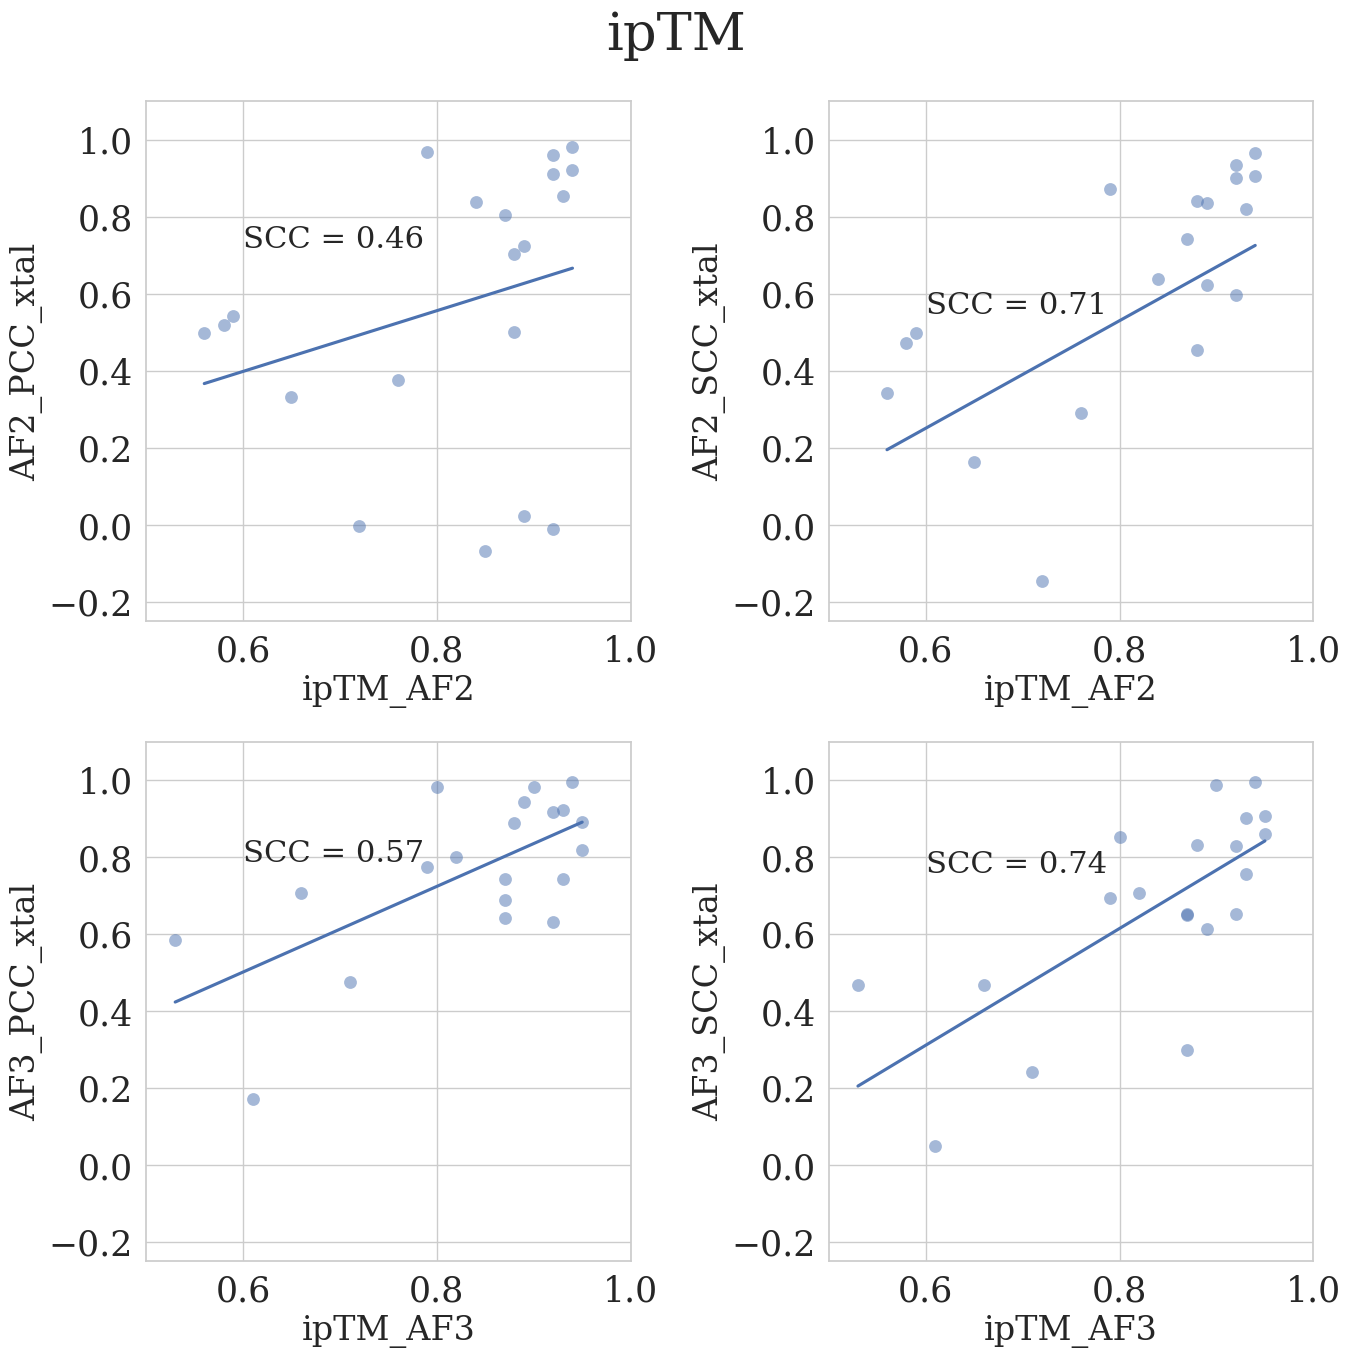

In [106]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # 3 rows, 1 column
plt.setp(axs, xlim=(0.5, 1.0), ylim=(-0.25, 1.1))
#axs = axs.flatten()
df=sm.copy()
# Loop through the data and axes, and plot each scatter plot
for axr, af_v in zip([0, 1], ['AF2', 'AF3']):
    for axc, metric in  zip([0, 1, 2], ['PCC', 'SCC']):

        sns.regplot(data=df, x=f'ipTM_{af_v}',
                           y=f'{af_v}_{metric}_xtal',
                    scatter_kws = {'alpha':0.5, 
                                  's':85,
                                  'linewidth':0},
                           ax=axs[axr][axc], ci=None)
        
        #ax.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
        vals = df[f'{af_v}_{metric}_xtal']
        x_m = vals.max()-(abs(vals.max()-vals.min()))*0.25
        # r = r2_score(df[rmsd], df[f'{metric}_{af_v}_diff'])
        # axs[axr][axc].annotate(f'R^2 = {r:.3f}', xy=(2, x_m), fontsize = 25)
        r, p = stats.spearmanr(df[f'ipTM_{af_v}'], df[f'{af_v}_{metric}_xtal'])
        axs[axr][axc].annotate(f'SCC = {r:.2f}', xy=(0.6, x_m), fontsize = 22)
        #axs[axr][axc].set_xlabel('')
        #axs[axr][axc].set_ylabel(f'$\\Delta$ {metric}')
        #ax.set_title(metric, fontsize = 28)
        #sns.move_legend(ax, "upper left")
        
# axs[0][1].set_xlabel("AF2", fontsize = 28)
# axs[1][1].set_xlabel("AF3", fontsize = 28)
# axs[0].set_ylabel("Predicted binding ddG", fontsize = 32)
fig.suptitle('ipTM', fontsize=38)
# Set the single X and Y labels for the entire figure
# fig.supxlabel("Experimental binding ddG", fontsize = 32)
# fig.supylabel("Predicted binding ddG", fontsize = 32)
# plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.tight_layout()
#plt.show()
    
#plt.savefig(f'Figures/safes_rmsd_metrics.pdf', format='pdf')

In [23]:
for metric in ['Pearson', 'Spearman', 'RMSE']:
    for sf in ['AF2', 'AF3']:
        print(f'{metric}_{sf}_diff')
        display(sm.loc[sm[f'{metric}_{sf}_diff']>0.2])

Pearson_AF2_diff


PDB_ID  RMSD_AF2  pTM_AF2  ipTM_AF2  RMSD_AF3  pTM_AF3  ipTM_AF3  \
2    1IAR      1.16     0.89      0.89      1.07     0.88      0.88   
7    1OGA      3.22     0.78      0.76      0.98     0.88      0.87   
13   2JEL      0.87     0.78      0.72      1.12     0.75      0.71   
14   3BN9      4.69     0.67      0.58      6.82     0.66      0.61   
19   5E9D      2.36     0.87      0.85      1.76     0.89      0.87   

    Number of chains  PDB_Pearson  PDB_Spearman  ...   AF2_RMSE  AF3_Pearson  \
2                  2     0.543299      0.553060  ...  21.293038     0.401627   
7                  5     0.257116      0.124469  ...   0.730840    -0.018024   
13                 3     0.487379      0.345190  ...   1.490035     0.389185   
14                 3     0.299481      0.334754  ...   0.931852    -0.210927   
19                 5     0.355597      0.100000  ...   0.868115    -0.225935   

    AF3_Spearman  AF3_RMSE  Pearson_AF2_diff  Pearson_AF3_diff  \
2       0.470172  1.056645          0.746873          0.141673   
7       0.064101  0.808619          0.282897          0.275140   
13      0.295775  1.101143          0.828634          0.098194   
14     -0.136542  0.936433          0.210146          0.510409   
19     -0.600000  0.749258          0.584092          0.581533   

    Spearman_AF2_diff  Spearman_AF3_diff  RMSE_AF2_diff  RMSE_AF3_diff  
2            0.114937           0.082888     -20.314773      -0.078379  
7            0.220492           0.060368      -0.049461      -0.127240  
13           0.722089           0.049416      -0.403764      -0.014871  
14           0.246177           0.471296      -0.096168      -0.100749  
19           0.100000           0.700000      -0.427118      -0.308261  

[5 rows x 23 columns]

Pearson_AF3_diff


PDB_ID  RMSD_AF2  pTM_AF2  ipTM_AF2  RMSD_AF3  pTM_AF3  ipTM_AF3  \
7    1OGA      3.22     0.78      0.76      0.98     0.88      0.87   
14   3BN9      4.69     0.67      0.58      6.82     0.66      0.61   
19   5E9D      2.36     0.87      0.85      1.76     0.89      0.87   

    Number of chains  PDB_Pearson  PDB_Spearman  ...  AF2_RMSE  AF3_Pearson  \
7                  5     0.257116      0.124469  ...  0.730840    -0.018024   
14                 3     0.299481      0.334754  ...  0.931852    -0.210927   
19                 5     0.355597      0.100000  ...  0.868115    -0.225935   

    AF3_Spearman  AF3_RMSE  Pearson_AF2_diff  Pearson_AF3_diff  \
7       0.064101  0.808619          0.282897          0.275140   
14     -0.136542  0.936433          0.210146          0.510409   
19     -0.600000  0.749258          0.584092          0.581533   

    Spearman_AF2_diff  Spearman_AF3_diff  RMSE_AF2_diff  RMSE_AF3_diff  
7            0.220492           0.060368      -0.049461      -0.127240  
14           0.246177           0.471296      -0.096168      -0.100749  
19           0.100000           0.700000      -0.427118      -0.308261  

[3 rows x 23 columns]

Spearman_AF2_diff


PDB_ID  RMSD_AF2  pTM_AF2  ipTM_AF2  RMSD_AF3  pTM_AF3  ipTM_AF3  \
7    1OGA      3.22     0.78      0.76      0.98     0.88      0.87   
13   2JEL      0.87     0.78      0.72      1.12     0.75      0.71   
14   3BN9      4.69     0.67      0.58      6.82     0.66      0.61   
16   3MZG      0.71     0.90      0.88      0.42     0.90      0.90   
18   3SZK     15.78     0.88      0.84      0.72     0.91      0.89   

    Number of chains  PDB_Pearson  PDB_Spearman  ...  AF2_RMSE  AF3_Pearson  \
7                  5     0.257116      0.124469  ...  0.730840    -0.018024   
13                 3     0.487379      0.345190  ...  1.490035     0.389185   
14                 3     0.299481      0.334754  ...  0.931852    -0.210927   
16                 2     0.866409      0.587879  ...  0.526976     0.847283   
18                 3     0.592004      0.563436  ...  0.956460     0.622758   

    AF3_Spearman  AF3_RMSE  Pearson_AF2_diff  Pearson_AF3_diff  \
7       0.064101  0.808619          0.282897          0.275140   
13      0.295775  1.101143          0.828634          0.098194   
14     -0.136542  0.936433          0.210146          0.510409   
16      0.600000  0.351171          0.140013          0.019125   
18      0.310996  1.010136         -0.070971         -0.030754   

    Spearman_AF2_diff  Spearman_AF3_diff  RMSE_AF2_diff  RMSE_AF3_diff  
7            0.220492           0.060368      -0.049461      -0.127240  
13           0.722089           0.049416      -0.403764      -0.014871  
14           0.246177           0.471296      -0.096168      -0.100749  
16           0.315152          -0.012121      -0.176661      -0.000856  
18           0.309044           0.252440      -0.004051      -0.057726  

[5 rows x 23 columns]

Spearman_AF3_diff


PDB_ID  RMSD_AF2  pTM_AF2  ipTM_AF2  RMSD_AF3  pTM_AF3  ipTM_AF3  \
12   2J0T      0.60     0.91      0.89      0.42     0.86      0.82   
14   3BN9      4.69     0.67      0.58      6.82     0.66      0.61   
18   3SZK     15.78     0.88      0.84      0.72     0.91      0.89   
19   5E9D      2.36     0.87      0.85      1.76     0.89      0.87   

    Number of chains  PDB_Pearson  PDB_Spearman  ...  AF2_RMSE  AF3_Pearson  \
12                 2     0.058646      0.120588  ...  2.388824     0.039781   
14                 3     0.299481      0.334754  ...  0.931852    -0.210927   
18                 3     0.592004      0.563436  ...  0.956460     0.622758   
19                 5     0.355597      0.100000  ...  0.868115    -0.225935   

    AF3_Spearman  AF3_RMSE  Pearson_AF2_diff  Pearson_AF3_diff  \
12     -0.082353  2.653362         -0.096453          0.018865   
14     -0.136542  0.936433          0.210146          0.510409   
18      0.310996  1.010136         -0.070971         -0.030754   
19     -0.600000  0.749258          0.584092          0.581533   

    Spearman_AF2_diff  Spearman_AF3_diff  RMSE_AF2_diff  RMSE_AF3_diff  
12           0.041176           0.202941      -0.142917      -0.407455  
14           0.246177           0.471296      -0.096168      -0.100749  
18           0.309044           0.252440      -0.004051      -0.057726  
19           0.100000           0.700000      -0.427118      -0.308261  

[4 rows x 23 columns]

RMSE_AF2_diff


PDB_ID  RMSD_AF2  pTM_AF2  ipTM_AF2  RMSD_AF3  pTM_AF3  ipTM_AF3  \
0    1AO7      1.81     0.88      0.87      0.63     0.92      0.92   
15   3HFM      1.24     0.89      0.88      0.81     0.88      0.87   

    Number of chains  PDB_Pearson  PDB_Spearman  ...  AF2_RMSE  AF3_Pearson  \
0                  5     0.400005      0.379979  ...  1.185013     0.398831   
15                 3     0.430738      0.448020  ...  2.081436     0.429516   

    AF3_Spearman  AF3_RMSE  Pearson_AF2_diff  Pearson_AF3_diff  \
0       0.291318  1.213142         -0.038802          0.001174   
15      0.375432  2.579767         -0.066071          0.001222   

    Spearman_AF2_diff  Spearman_AF3_diff  RMSE_AF2_diff  RMSE_AF3_diff  
0           -0.055362           0.088662       0.273926       0.245797  
15          -0.038985           0.072588       0.291114      -0.207218  

[2 rows x 23 columns]

RMSE_AF3_diff


PDB_ID  RMSD_AF2  pTM_AF2  ipTM_AF2  RMSD_AF3  pTM_AF3  ipTM_AF3  \
0   1AO7      1.81     0.88      0.87      0.63     0.92      0.92   

   Number of chains  PDB_Pearson  PDB_Spearman  ...  AF2_RMSE  AF3_Pearson  \
0                 5     0.400005      0.379979  ...  1.185013     0.398831   

   AF3_Spearman  AF3_RMSE  Pearson_AF2_diff  Pearson_AF3_diff  \
0      0.291318  1.213142         -0.038802          0.001174   

   Spearman_AF2_diff  Spearman_AF3_diff  RMSE_AF2_diff  RMSE_AF3_diff  
0          -0.055362           0.088662       0.273926       0.245797  

[1 rows x 23 columns]

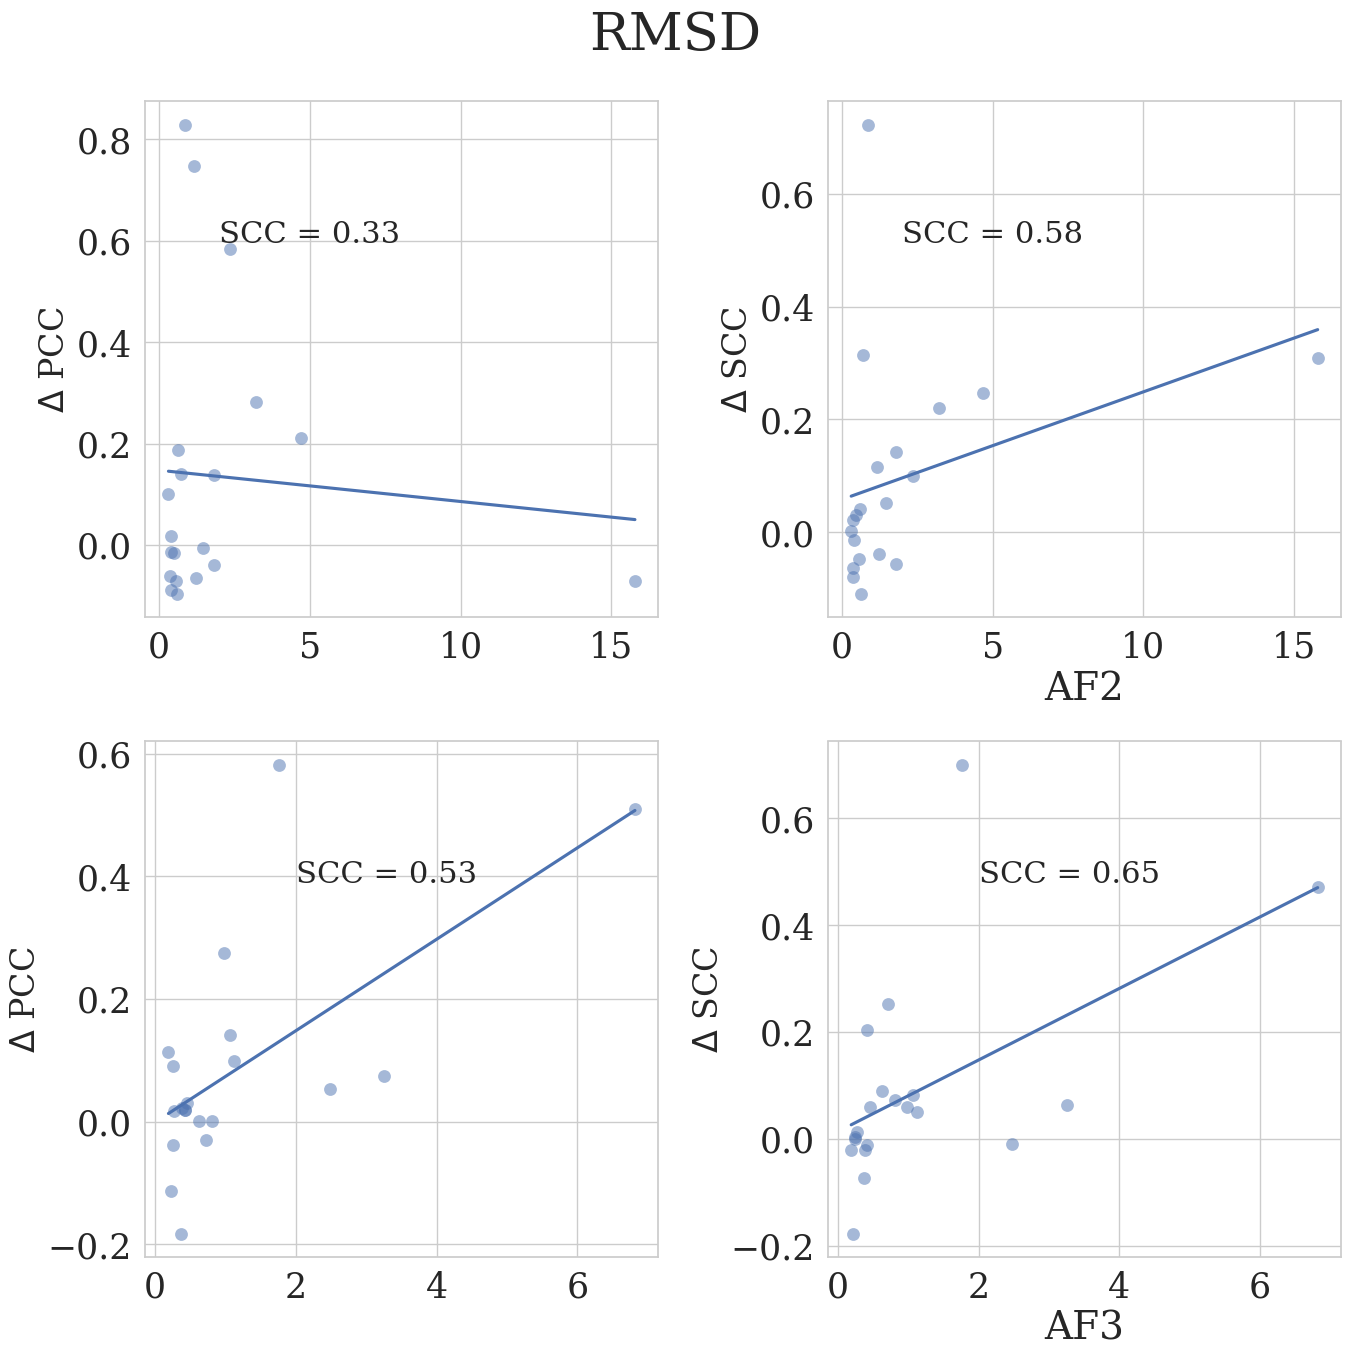

In [212]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # 3 rows, 1 column
plt.setp(axs, xlim=(-13.5, 13.5), ylim=(-0.2, 1.0))
#axs = axs.flatten()
df=sm.copy()
# Loop through the data and axes, and plot each scatter plot
for axr, rmsd in zip([0, 1], ['RMSD_AF2', 'RMSD_AF3']):
    for axc, metric in  zip([0, 1, 2], ['PCC', 'SCC']):
    
        af_v = rmsd.split('_')[-1]
        sns.regplot(data=df, x=rmsd,
                           y=f'{metric}_{af_v}_diff',
                    scatter_kws = {'alpha':0.5, 
                                  's':85,
                                  'linewidth':0},
                           ax=axs[axr][axc], ci=None)
        
        #ax.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
        vals = df[f'{metric}_{af_v}_diff']
        x_m = vals.max()-(abs(vals.max()-vals.min()))*0.25
        # r = r2_score(df[rmsd], df[f'{metric}_{af_v}_diff'])
        # axs[axr][axc].annotate(f'R^2 = {r:.3f}', xy=(2, x_m), fontsize = 25)
        r, p = stats.spearmanr(df[rmsd], df[f'{metric}_{af_v}_diff'])
        axs[axr][axc].annotate(f'SCC = {r:.2f}', xy=(2, x_m), fontsize = 22)
        #axs[axr][axc].set_xlabel('')
        axs[axr][axc].set_ylabel(f'$\\Delta$ {metric}')
        #ax.set_title(metric, fontsize = 28)
        #sns.move_legend(ax, "upper left")
        
# axs[0][1].set_xlabel("AF2", fontsize = 28)
# axs[1][1].set_xlabel("AF3", fontsize = 28)
# axs[0].set_ylabel("Predicted binding ddG", fontsize = 32)
fig.suptitle('RMSD', fontsize=38)
# Set the single X and Y labels for the entire figure
# fig.supxlabel("Experimental binding ddG", fontsize = 32)
# fig.supylabel("Predicted binding ddG", fontsize = 32)
# plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.tight_layout()
#plt.show()
    
plt.savefig(f'Figures/safes_rmsd_metrics.pdf', format='pdf')

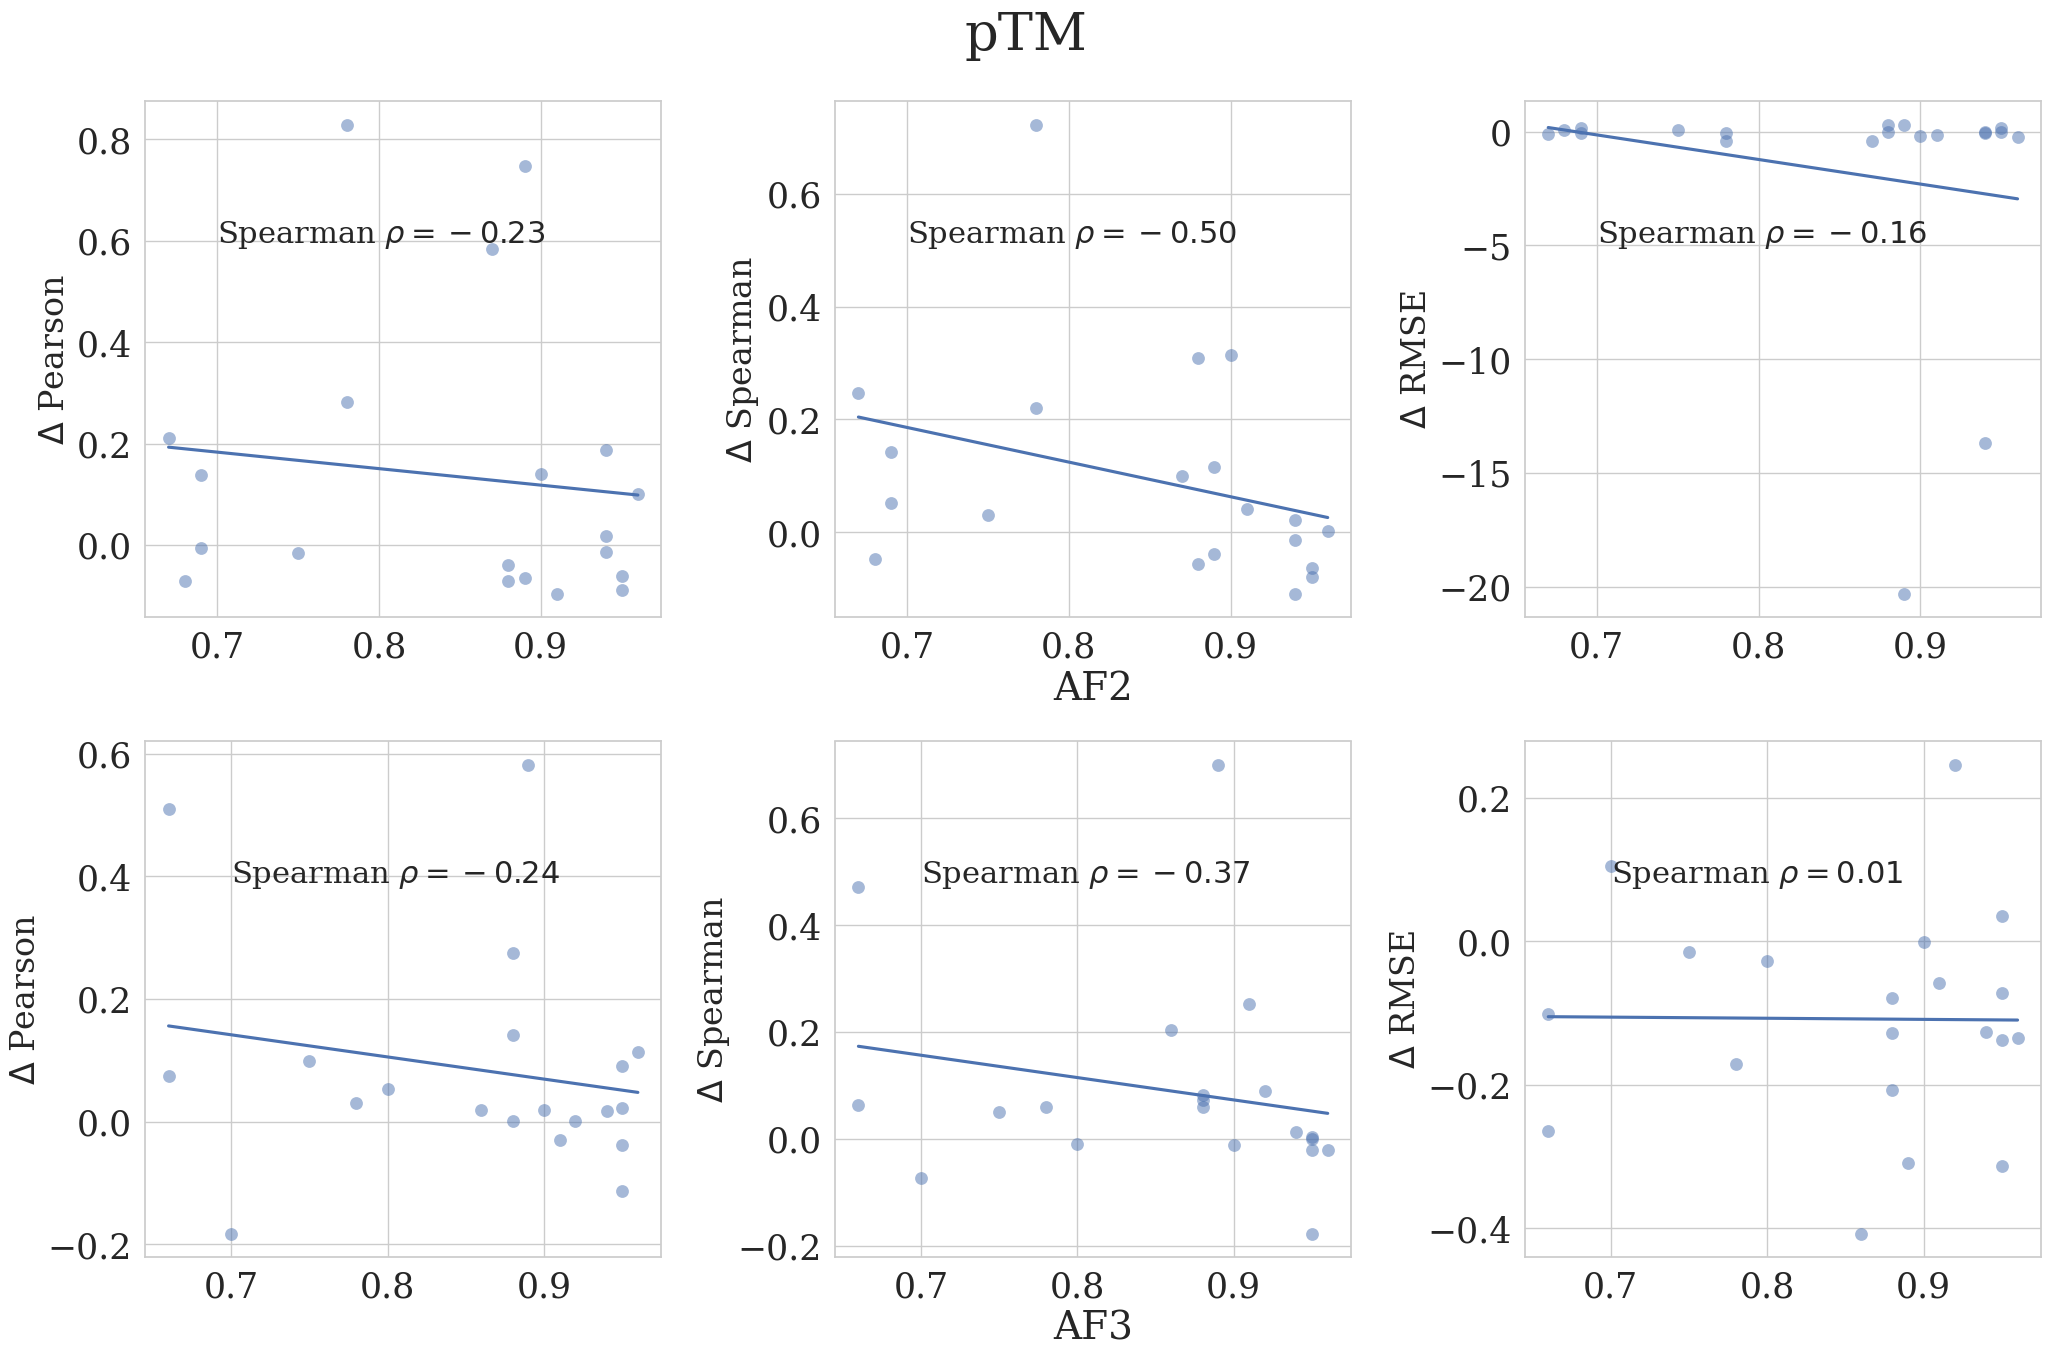

In [113]:
fig, axs = plt.subplots(2, 3, figsize=(21, 14))  # 3 rows, 1 column
#plt.setp(axs, xlim=(-13.5, 13.5), ylim=(-13.5, 13.5))
#axs = axs.flatten()
df=sm.copy()
# Loop through the data and axes, and plot each scatter plot
for axr, rmsd in zip([0, 1], ['pTM_AF2', 'pTM_AF3']):
    for axc, metric in  zip([0, 1, 2], ['Pearson', 'Spearman', 'RMSE']):
    
        af_v = rmsd.split('_')[-1]
        sns.regplot(data=df, x=rmsd,
                           y=f'{metric}_{af_v}_diff',
                    scatter_kws = {'alpha':0.5, 
                                  's':85,
                                  'linewidth':0},
                           ax=axs[axr][axc], ci=None)
        
        #ax.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
        vals = df[f'{metric}_{af_v}_diff']
        x_m = vals.max()-(abs(vals.max()-vals.min()))*0.25
        # r = r2_score(df[rmsd], df[f'{metric}_{af_v}_diff'])
        # axs[axr][axc].annotate(f'R^2 = {r:.3f}', xy=(0.8, x_m), fontsize = 25)
        # r, p = stats.pearsonr(df[rmsd], df[f'{metric}_{af_v}_diff'])
        # axs[axr][axc].annotate(f'Pearson $\\rho = {r:.3f}$', xy=(2, 0), fontsize = 25)
        r, p = stats.spearmanr(df[rmsd], df[f'{metric}_{af_v}_diff'])
        axs[axr][axc].annotate(f'SCC = {r:.2f}', xy=(0.7, x_m), fontsize = 22)
        axs[axr][axc].set_xlabel('')
        axs[axr][axc].set_ylabel(f'$\\Delta$ {metric}')
        #ax.set_title(metric, fontsize = 28)
        #sns.move_legend(ax, "upper left")
        
axs[0][1].set_xlabel("AF2", fontsize = 28)
axs[1][1].set_xlabel("AF3", fontsize = 28)
# axs[0].set_ylabel("Predicted binding ddG", fontsize = 32)
fig.suptitle('pTM', fontsize=38)
# Set the single X and Y labels for the entire figure
# fig.supxlabel("Experimental binding ddG", fontsize = 32)
# fig.supylabel("Predicted binding ddG", fontsize = 32)
# plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.tight_layout()
#plt.show()
    
plt.savefig(f'Figures/safes_ptm_metrics.pdf', format='pdf')

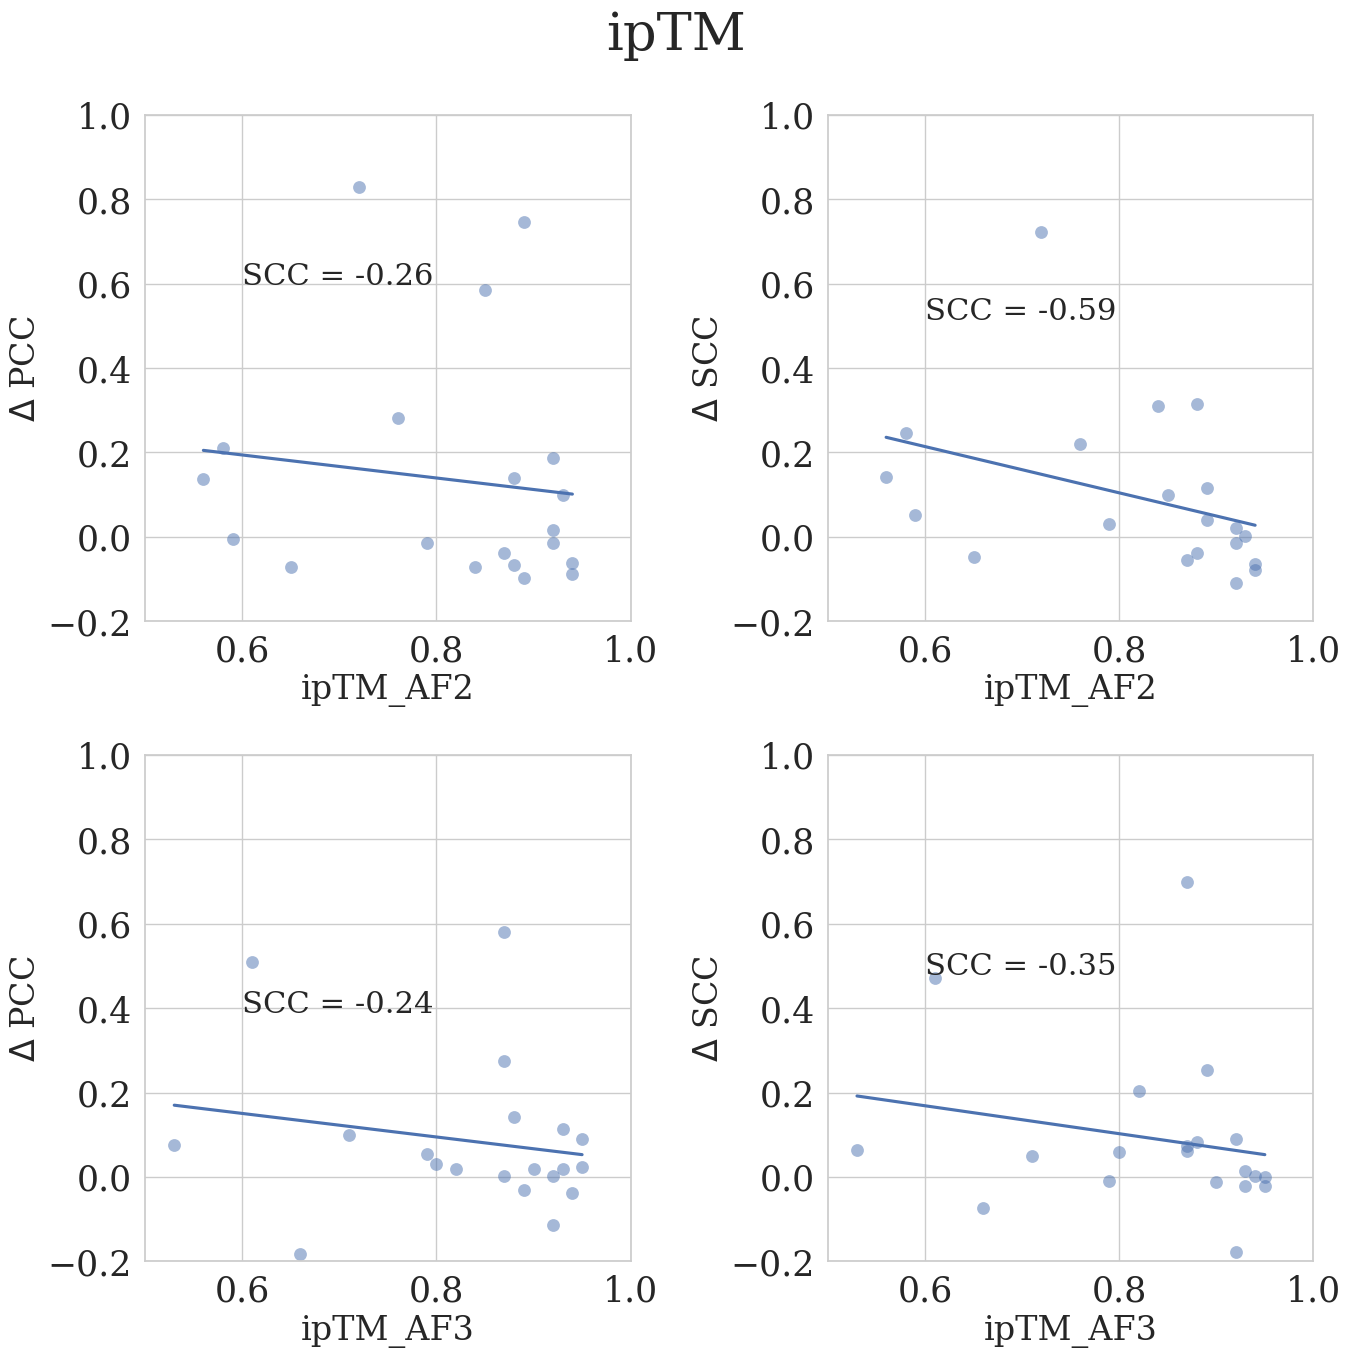

In [216]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # 3 rows, 1 column
plt.setp(axs, xlim=(0.5, 1.0), ylim=(-0.2, 1.0))
#axs = axs.flatten()
df=sm.copy()
# Loop through the data and axes, and plot each scatter plot
for axr, rmsd in zip([0, 1], ['ipTM_AF2', 'ipTM_AF3']):
    for axc, metric in  zip([0, 1, 2], ['PCC', 'SCC']):
    
        af_v = rmsd.split('_')[-1]
        sns.regplot(data=df, x=rmsd,
                           y=f'{metric}_{af_v}_diff',
                    scatter_kws = {'alpha':0.5, 
                                  's':85,
                                  'linewidth':0},
                           ax=axs[axr][axc], ci=None)
        
        #ax.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
        vals = df[f'{metric}_{af_v}_diff']
        x_m = vals.max()-(abs(vals.max()-vals.min()))*0.25
        # r = r2_score(df[rmsd], df[f'{metric}_{af_v}_diff'])
        # axs[axr][axc].annotate(f'R^2 = {r:.3f}', xy=(0.8, x_m), fontsize = 25)
        # r, p = stats.pearsonr(df[rmsd], df[f'{metric}_{af_v}_diff'])
        # axs[axr][axc].annotate(f'Pearson $\\rho = {r:.3f}$', xy=(2, 0), fontsize = 25)
        r, p = stats.spearmanr(df[rmsd], df[f'{metric}_{af_v}_diff'])
        axs[axr][axc].annotate(f'SCC = {r:.2f}', xy=(0.6, x_m), fontsize = 22)
        #axs[axr][axc].set_xlabel(f'')
        axs[axr][axc].set_ylabel(f'$\\Delta$ {metric}')
        #ax.set_title(metric, fontsize = 28)
        #sns.move_legend(ax, "upper left")
        
# axs[0][1].set_xlabel("AF2", fontsize = 28)
# axs[1][1].set_xlabel("AF3", fontsize = 28)

# fig.text(0.5, 0.45, 'AF2', ha='center', fontsize=30)  # x label
# fig.text(0.5, 0.00, 'AF3', ha='center', fontsize=30)  # x label
#fig.text(0.04, 0.5, 'Experimental binding ddG', va='center', rotation='vertical', fontsize=30)

# axs[0].set_ylabel("Predicted binding ddG", fontsize = 32)
fig.suptitle('ipTM', fontsize=38)
# Set the single X and Y labels for the entire figure
# fig.supxlabel("Experimental binding ddG", fontsize = 32)
# fig.supylabel("Predicted binding ddG", fontsize = 32)
# plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.tight_layout()
#plt.show()
    
plt.savefig(f'Figures/safes_iptm_metrics.pdf', format='pdf')

In [129]:
pred = 'infc_xtal'
x1 = SAFES_exp[f'mean_ddG_{pred}'] + SAFES_exp[f'std_ddG_{pred}']
x2 = SAFES_exp[f'mean_ddG_{pred}'] - SAFES_exp[f'std_ddG_{pred}']

pr0, _ = stats.pearsonr(SAFES_exp['ddG_bind'], SAFES_exp[f'mean_ddG_{pred}'])
sr0, _ = stats.spearmanr(SAFES_exp['ddG_bind'], SAFES_exp[f'mean_ddG_{pred}'])
print('Pearson: ', pr0)
print('Spearman: ', sr0)

pr1, _ = stats.pearsonr(SAFES_exp['ddG_bind'], x1)
sr1, _ = stats.spearmanr(SAFES_exp['ddG_bind'], x1)
print('Pearson: ', pr1)
print('Spearman: ', sr1)

pr2, _ = stats.pearsonr(SAFES_exp['ddG_bind'], x2)
sr2, _ = stats.spearmanr(SAFES_exp['ddG_bind'], x2)
print('Pearson: ', pr1)
print('Spearman: ', sr1)

print('Mean P: ', pr0-pr1, pr0-pr2)
print('Mean S: ', sr0-sr1, sr0-sr2)

Pearson:  0.44856794186234383
Spearman:  0.42008668194678545
Pearson:  0.44262535689225296
Spearman:  0.4220056799453859
Pearson:  0.44262535689225296
Spearman:  0.4220056799453859
Mean P:  0.0059425849700908695 0.012254178114206649
Mean S:  -0.001918997998600458 0.019072268619557853


In [130]:
stats.spearmanr(SAFES_exp[f'mean_ddG_{pred}'], x1)

SignificanceResult(statistic=0.98552378780846, pvalue=0.0)

In [131]:
stats.spearmanr(SAFES_exp[f'mean_ddG_{pred}'], x2)

SignificanceResult(statistic=0.9660080530340547, pvalue=0.0)

In [132]:
stats.spearmanr(x1, x2)

SignificanceResult(statistic=0.9202861979692788, pvalue=0.0)

In [ ]:
SAFES_exp['std_ddG_infc_xtal'].hist()

In [ ]:
SAFES_exp.loc[SAFES_exp['std_ddG_infc_xtal']>2]

In [ ]:
sm.columns

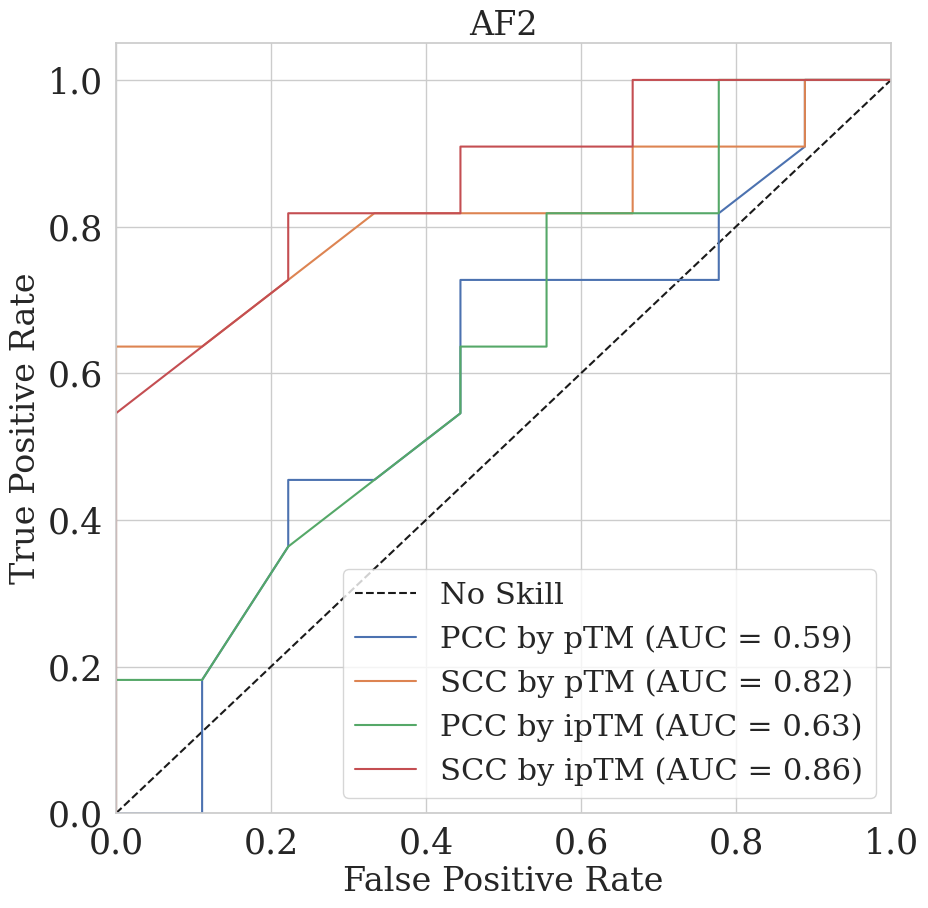

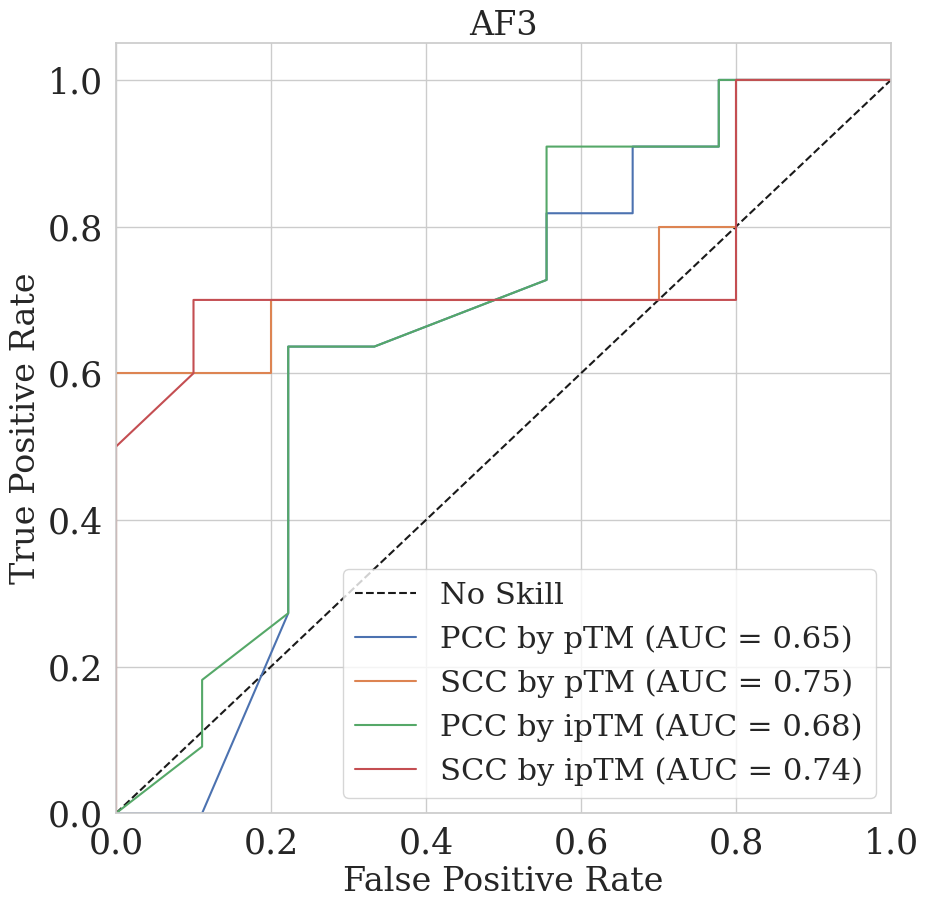

In [194]:
for af in ['AF2', 'AF3']:
    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
    for af_metric in ['pTM', 'ipTM']:
        for corr in ['PCC', 'SCC']:
            metric = f'{corr}_{af}_diff'
            m_af = f'{af_metric}_{af}'
            metric_values = sm[metric].values
            fpr, tpr, thresholds = roc_curve(np.where(metric_values < 0.05, 1, 0), sm[m_af].values) 
            roc_auc = auc(fpr, tpr)
            # Plot the ROC curve
            #fig, axs = plt.subplots(2, 3, figsize=(21, 14))  # 3 rows, 1 column
            plt.plot(fpr, tpr, label=f'{corr} by {af_metric} (AUC = %0.2f)' % roc_auc)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(af)
            plt.legend()

In [195]:
model_dict = {'PDB': '_xtal',
              'AF2': '_af2',
              'AF3': '_af3'}

for pdb_id in SAFES_exp['PDB_ID'].unique():
    print(pdb_id)
    subset = SAFES_exp.loc[SAFES_exp['PDB_ID']==pdb_id]
    print(len(subset))
    for model in model_dict.keys():
        pr, _ = stats.pearsonr(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}'])
        sr, _ = stats.spearmanr(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}'])
        rmse = sqrt(mean_squared_error(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}']))
        print(model, pr, sr, rmse)

1MHP
49
PDB 0.17202707430551512 0.16898104049045432 1.5228789043943198
AF2 0.17753308867467743 0.11721464319217013 1.3701185411029118
AF3 0.11830866180214827 0.17903822024169888 1.5501622414861331
5E9D
5
PDB 0.3555970723466606 0.09999999999999999 0.44099685027377056
AF2 -0.22849522990301474 0.0 0.8681146649966252
AF3 -0.2259354401641193 -0.6 0.7492579189602705
1R0R
191
PDB 0.54496832495733 0.32711469902821927 1.7987382099099236
AF2 0.44538800732957695 0.324190241485026 2.036550550726736
AF3 0.432314304005429 0.3479536118926871 1.9328472386495845
1CHO
190
PDB 0.5899449186573529 0.5061131797393263 1.9958765008894883
AF2 0.6512212368046407 0.5852363391659922 1.8293196144704515
AF3 0.4993447244179966 0.5072119424069943 2.133021651093445
1VFB
45
PDB 0.604926994447253 0.4486313780884999 0.9256788858326152
AF2 0.46722910030771375 0.30672947083407576 0.9857414816805533
AF3 0.53051445955982 0.384992918289162 1.1895908047731067
2FTL
20
PDB 0.3123567317883416 0.3969924812030075 9.299375497678083


In [ ]:
model_dict = {'PDB': '_xtal',
              'AF2': '_af2',
              'AF3': '_af3'}

df=SAFES_trunc.copy()

fig, axs = plt.subplots(1, 3, figsize=(33, 10))  # 3 rows, 1 column
plt.setp(axs, xlim=(-5, 13.5), ylim=(-5, 13.5))
# Loop through the data and axes, and plot each scatter plot
for ax, model in zip(axs, model_dict.keys()):
    subset = df
    sns.scatterplot(data=subset, x='ddG_bind',
                       y=f'mean_ddG_infc{model_dict[model]}',
                       alpha=0.5, s=40, linewidth = 0,
                    ax=ax)
    ax.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)

    r, p = stats.pearsonr(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}'])
    ax.annotate(f'PCC = {r:.2f}', xy=(-4, 12), fontsize = 28)
    r, p = stats.spearmanr(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}'])
    ax.annotate(f'SCC = {r:.2f}', xy=(-4, 10.8), fontsize = 28)
    rmse = sqrt(mean_squared_error(subset['ddG_bind'], subset[f'mean_ddG_infc{model_dict[model]}']))
    ax.annotate(f'RMSE = {rmse:.3f}', xy=(-4, 9.6), fontsize = 28)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f'{model}', fontsize = 32)
    ax.set_xticks(np.arange(-5.0, 13.5, 2.5))
    
axs[1].set_xlabel("Experimental binding ddG", fontsize = 32)
axs[0].set_ylabel("Predicted binding ddG", fontsize = 32)
fig.suptitle('Cartesian ddG + InterfaceAnalyzer', fontsize=36)

plt.savefig('Figures/SAFES_cart_ddG_IA.pdf', format='pdf')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(33, 10))  # 3 rows, 1 column
plt.setp(axs, xlim=(-5, 13.5), ylim=(-5, 13.5))
df=SAFES_trunc.copy()
# Loop through the data and axes, and plot each scatter plot
for ax, model in zip(axs, model_dict.keys()):
    subset = df
    sns.scatterplot(data=subset, x='ddG_bind',
                       y=f'mean_ddG{model_dict[model]}',
                       alpha=0.5, s=40, linewidth = 0,
                    ax=ax)
    ax.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
    r, p = stats.pearsonr(subset['ddG_bind'], subset[f'mean_ddG{model_dict[model]}'])
    ax.annotate(f'PCC = {r:.2f}', xy=(-4, 12), fontsize = 28)
    r, p = stats.spearmanr(subset['ddG_bind'], subset[f'mean_ddG{model_dict[model]}'])
    ax.annotate(f'SCC = {r:.2f}', xy=(-4, 10.8), fontsize = 28)
    rmse = sqrt(mean_squared_error(subset['ddG_bind'], subset[f'mean_ddG{model_dict[model]}']))
    ax.annotate(f'RMSE = {rmse:.3f}', xy=(-4, 9.6), fontsize = 28)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f'{model}', fontsize = 32)
    
axs[1].set_xlabel("Experimental binding ddG", fontsize = 32)
axs[0].set_ylabel("Predicted binding ddG", fontsize = 32)
fig.suptitle('Cartesian ddG', fontsize=36)

plt.savefig('Figures/SAFES_cart_ddG.pdf', format='pdf')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(33, 10))  # 3 rows, 1 column
plt.setp(axs, xlim=(-5, 13.5), ylim=(-5, 13.5))
# Loop through the data and axes, and plot each scatter plot

sns.scatterplot(data=SAFES_exp, x='mean_ddG_xtal',
                   y='mean_ddG_af2',
                   alpha=0.5, s=85, linewidth=0,
                ax=axs[0])
axs[0].plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
r, p = stats.pearsonr(SAFES_exp['mean_ddG_xtal'], SAFES_exp['mean_ddG_af2'])
axs[0].annotate(f'PCC = {r:.2f}', xy=(-4, 12), fontsize = 28)
r, p = stats.spearmanr(SAFES_exp['mean_ddG_xtal'], SAFES_exp['mean_ddG_af2'])
axs[0].annotate(f'SCC = {r:.2f}', xy=(-4, 10.8), fontsize = 28)
t_statistic, p_value = ttest_rel(SAFES_exp['mean_ddG_xtal'], SAFES_exp['mean_ddG_af2'])
axs[0].annotate(f'p-value = {p_value:.3f}', xy=(-4, 9.6), fontsize = 28)
axs[0].set_xlabel("PDB", fontsize = 32)
axs[0].set_ylabel("AF2", fontsize = 32)

sns.scatterplot(data=SAFES_exp, x='mean_ddG_xtal',
                   y='mean_ddG_af3',
                   alpha=0.5, s=75, linewidth=0,
                ax=axs[1])
axs[1].plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
r, p = stats.pearsonr(SAFES_exp['mean_ddG_xtal'], SAFES_exp['mean_ddG_af3'])
axs[1].annotate(f'PCC = {r:.2f}', xy=(-4, 12), fontsize = 28)
r, p = stats.spearmanr(SAFES_exp['mean_ddG_xtal'], SAFES_exp['mean_ddG_af3'])
axs[1].annotate(f'SCC = {r:.2f}', xy=(-4, 10.8), fontsize = 28)
t_statistic, p_value = ttest_rel(SAFES_exp['mean_ddG_xtal'], SAFES_exp['mean_ddG_af3'])
axs[1].annotate(f'p-value = {p_value:.3f}', xy=(-4, 9.6), fontsize = 28)
axs[1].set_xlabel("PDB", fontsize = 32)
axs[1].set_ylabel("AF3", fontsize = 32)

sns.scatterplot(data=SAFES_exp, x='mean_ddG_af2',
                   y='mean_ddG_af3',
                   alpha=0.5, s=75,  linewidth=0,
                ax=axs[2])
axs[2].plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
r, p = stats.pearsonr(SAFES_exp['mean_ddG_af2'], SAFES_exp['mean_ddG_af3'])
axs[2].annotate(f'Pearson $\\rho = {r:.3f}$', xy=(-4, 12), fontsize = 28)
r, p = stats.spearmanr(SAFES_exp['mean_ddG_af2'], SAFES_exp['mean_ddG_af3'])
axs[2].annotate(f'Spearman $\\rho = {r:.3f}$', xy=(-4, 10.8), fontsize = 28)
t_statistic, p_value = ttest_rel(SAFES_exp['mean_ddG_af2'], SAFES_exp['mean_ddG_af3'])
axs[2].annotate(f'p-value = {p_value:.3f}', xy=(-4, 9.6), fontsize = 28)
axs[2].set_xlabel("AF2", fontsize = 32)
axs[2].set_ylabel("AF3", fontsize = 32)

# axs[1].set_xlabel("Experimental binding ddG", fontsize = 32)
# axs[0].set_ylabel("Predicted binding ddG", fontsize = 32)
fig.suptitle('Cartesian ddG predictions', fontsize=36)

plt.savefig('Figures/SAFES_cart_ddG_pvp.pdf', format='pdf')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(33, 10))  # 3 rows, 1 column
plt.setp(axs, xlim=(-5, 13.5), ylim=(-5, 13.5))
# Loop through the data and axes, and plot each scatter plot

sns.scatterplot(data=SAFES_exp, x='mean_ddG_infc_xtal',
                   y='mean_ddG_infc_af2',
                   alpha=0.5, s=85, linewidth=0,
                ax=axs[0])
axs[0].plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
r, p = stats.pearsonr(SAFES_exp['mean_ddG_infc_xtal'], SAFES_exp['mean_ddG_infc_af2'])
axs[0].annotate(f'PCC = {r:.2f}', xy=(-4, 12), fontsize = 28)
r, p = stats.spearmanr(SAFES_exp['mean_ddG_infc_xtal'], SAFES_exp['mean_ddG_infc_af2'])
axs[0].annotate(f'SCC = {r:.2f}', xy=(-4, 10.8), fontsize = 28)
t_statistic, p_value = ttest_rel(SAFES_exp['mean_ddG_infc_xtal'], SAFES_exp['mean_ddG_infc_af2'])
axs[0].annotate(f'p-value = {p_value:.3f}', xy=(-4, 9.6), fontsize = 28)
axs[0].set_xlabel("PDB", fontsize = 32)
axs[0].set_ylabel("AF2", fontsize = 32)

sns.scatterplot(data=SAFES_exp, x='mean_ddG_infc_xtal',
                   y='mean_ddG_infc_af3',
                   alpha=0.5, s=85, linewidth=0,
                ax=axs[1])
axs[1].plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
r, p = stats.pearsonr(SAFES_exp['mean_ddG_infc_xtal'], SAFES_exp['mean_ddG_infc_af3'])
axs[1].annotate(f'PCC = {r:.2f}', xy=(-4, 12), fontsize = 28)
r, p = stats.spearmanr(SAFES_exp['mean_ddG_infc_xtal'], SAFES_exp['mean_ddG_infc_af3'])
axs[1].annotate(f'SCC = {r:.2f}', xy=(-4, 10.8), fontsize = 28)
t_statistic, p_value = ttest_rel(SAFES_exp['mean_ddG_infc_xtal'], SAFES_exp['mean_ddG_infc_af3'])
axs[1].annotate(f'p-value = {p_value:.3f}', xy=(-4, 9.6), fontsize = 28)
axs[1].set_xlabel("PDB", fontsize = 32)
axs[1].set_ylabel("AF3", fontsize = 32)

sns.scatterplot(data=SAFES_exp, x='mean_ddG_infc_af2',
                   y='mean_ddG_infc_af3',
                   alpha=0.5, s=85, linewidth=0,
                ax=axs[2])
axs[2].plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
r, p = stats.pearsonr(SAFES_exp['mean_ddG_infc_af2'], SAFES_exp['mean_ddG_infc_af3'])
axs[2].annotate(f'PCC = {r:.2f}', xy=(-4, 12), fontsize = 28)
r, p = stats.spearmanr(SAFES_exp['mean_ddG_infc_af2'], SAFES_exp['mean_ddG_infc_af3'])
axs[2].annotate(f'SCC = {r:.2f}', xy=(-4, 10.8), fontsize = 28)
t_statistic, p_value = ttest_rel(SAFES_exp['mean_ddG_infc_af2'], SAFES_exp['mean_ddG_infc_af3'])
axs[2].annotate(f'p-value = {p_value:.3f}', xy=(-4, 9.6), fontsize = 28)
axs[2].set_xlabel("AF2", fontsize = 32)
axs[2].set_ylabel("AF3", fontsize = 32)
    
# axs[1].set_xlabel("Experimental binding ddG", fontsize = 32)
# axs[0].set_ylabel("Predicted binding ddG", fontsize = 32)
fig.suptitle('Cartesian ddG + IA predicted values', fontsize=36)

plt.savefig('Figures/SAFES_cart_ddG_IA_pvp.pdf', format='pdf')

In [107]:
# import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from scipy.stats import ttest_rel
from sklearn.metrics import mean_squared_error
from math import sqrt
import os

# --- Setup ---
# Ensure the output directory exists
os.makedirs('Figures', exist_ok=True)

model_dict = {
    'PDB': '_xtal',
    'AF2': '_af2',
    'AF3': '_af3'
}

# --- Plot 1: Cartesian ddG + InterfaceAnalyzer vs. Experimental ---
fig1 = plt.figure(figsize=(37, 11))
outer_grid1 = gridspec.GridSpec(1, 3, figure=fig1, wspace=0.25, hspace=0.25)

for i, model in enumerate(model_dict.keys()):
    y_col = f'mean_ddG_infc{model_dict[model]}'
    subset = SAFES_trunc.copy()

    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_grid1[i],
                                                  width_ratios=(4, 1), height_ratios=(1, 4),
                                                  wspace=0.05, hspace=0.05)
    ax_scatter = fig1.add_subplot(inner_grid[1, 0])
    ax_histx = fig1.add_subplot(inner_grid[0, 0], sharex=ax_scatter)
    ax_histy = fig1.add_subplot(inner_grid[1, 1], sharey=ax_scatter)

    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    sns.scatterplot(data=subset, x='ddG_bind', y=y_col, alpha=0.5, s=40, linewidth=0, ax=ax_scatter)
    sns.histplot(data=subset, x='ddG_bind', ax=ax_histx, kde=False)
    sns.histplot(data=subset, y=y_col, ax=ax_histy, kde=False)
    ax_histx.set_ylabel('')
    ax_histy.set_xlabel('')

    ax_scatter.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
    r_p, _ = stats.pearsonr(subset['ddG_bind'], subset[y_col])
    ax_scatter.annotate(f'PCC = {r_p:.2f}', xy=(-5.3, 11), fontsize=28)
    r_s, _ = stats.spearmanr(subset['ddG_bind'], subset[y_col])
    ax_scatter.annotate(f'SCC = {r_s:.2f}', xy=(-5.3, 9.8), fontsize=28)
    rmse = sqrt(mean_squared_error(subset['ddG_bind'], subset[y_col]))
    ax_scatter.annotate(f'RMSE = {rmse:.2f}', xy=(-5.3, 8.6), fontsize=28)

    #ax_scatter.set_title(f'{model}', fontsize=32)
    ax_scatter.set_xlim(-5.5, 12.5)
    ax_scatter.set_ylim(-5.5, 12.5)
    ax_scatter.set_xticks(np.arange(-4, 14, 2))
    ax_scatter.set_yticks(np.arange(-4, 14, 2))
    ax_scatter.set_xlabel("")
    ax_scatter.set_ylabel(f'Predicted, {model}')

    if i == 1: ax_scatter.set_xlabel("Experimental binding ddG", fontsize=32)
    #if i == 0: ax_scatter.set_ylabel("Predicted binding ddG", fontsize=32)

fig1.suptitle('cartesian_ddg+IA predictions, by input', fontsize=36, y=1.0)
plt.savefig('Figures/SAFES_cart_ddG_IA_marginals.pdf', format='pdf', bbox_inches='tight')
plt.close(fig1)

# --- Plot 2: Cartesian ddG vs. Experimental ---
fig2 = plt.figure(figsize=(37, 11))
outer_grid2 = gridspec.GridSpec(1, 3, figure=fig2, wspace=0.25, hspace=0.25)

for i, model in enumerate(model_dict.keys()):
    y_col = f'mean_ddG{model_dict[model]}'
    subset = SAFES_trunc.copy()

    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_grid2[i],
                                                  width_ratios=(4, 1), height_ratios=(1, 4),
                                                  wspace=0.05, hspace=0.05)
    ax_scatter = fig2.add_subplot(inner_grid[1, 0])
    ax_histx = fig2.add_subplot(inner_grid[0, 0], sharex=ax_scatter)
    ax_histy = fig2.add_subplot(inner_grid[1, 1], sharey=ax_scatter)

    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    sns.scatterplot(data=subset, x='ddG_bind', y=y_col, alpha=0.5, s=40, linewidth=0, ax=ax_scatter)
    sns.histplot(data=subset, x='ddG_bind', ax=ax_histx, kde=False)
    sns.histplot(data=subset, y=y_col, ax=ax_histy, kde=False)
    ax_histx.set_ylabel('')
    ax_histy.set_xlabel('')

    ax_scatter.plot([-16, 16], [-16, 16], color='steelblue', ls='-', lw=0.5, alpha=0.6)
    r_p, _ = stats.pearsonr(subset['ddG_bind'], subset[y_col])
    ax_scatter.annotate(f'PCC = {r_p:.2f}', xy=(-3.8, 14), fontsize=28)
    r_s, _ = stats.spearmanr(subset['ddG_bind'], subset[y_col])
    ax_scatter.annotate(f'SCC = {r_s:.2f}', xy=(-3.8, 12.9), fontsize=28)
    rmse = sqrt(mean_squared_error(subset['ddG_bind'], subset[y_col]))
    ax_scatter.annotate(f'RMSE = {rmse:.2f}', xy=(-3.8, 11.8), fontsize=28)
    
    #ax_scatter.set_title(f'{model}', fontsize=32)
    ax_scatter.set_xlim(-4, 15.5)
    ax_scatter.set_ylim(-4, 15.5)
    ax_scatter.set_xticks(np.arange(-4, 16, 2))
    ax_scatter.set_yticks(np.arange(-4, 16, 2))
    ax_scatter.set_xlabel("")
    ax_scatter.set_ylabel(f'Predicted, {model}')
    
    if i == 1: ax_scatter.set_xlabel("Experimental binding ddG", fontsize=32)
    #if i == 0: ax_scatter.set_ylabel("Predicted binding ddG", fontsize=32)

fig2.suptitle('cartesian_ddg predictions, by input', fontsize=36, y=1.0)
plt.savefig('Figures/SAFES_cart_ddG_marginals.pdf', format='pdf', bbox_inches='tight')
plt.close(fig2)

# --- Plot 3: Cartesian ddG predictions (PVP) ---
fig3 = plt.figure(figsize=(37, 11))
outer_grid3 = gridspec.GridSpec(1, 3, figure=fig3, wspace=0.25, hspace=0.25)
comparisons = [
    (('PDB', 'mean_ddG_xtal'), ('AF2', 'mean_ddG_af2')),
    (('PDB', 'mean_ddG_xtal'), ('AF3', 'mean_ddG_af3')),
    (('AF2', 'mean_ddG_af2'), ('AF3', 'mean_ddG_af3'))
]

for i, ((x_name, x_col), (y_name, y_col)) in enumerate(comparisons):
    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_grid3[i],
                                                  width_ratios=(4, 1), height_ratios=(1, 4),
                                                  wspace=0.05, hspace=0.05)
    ax_scatter = fig3.add_subplot(inner_grid[1, 0])
    ax_histx = fig3.add_subplot(inner_grid[0, 0], sharex=ax_scatter)
    ax_histy = fig3.add_subplot(inner_grid[1, 1], sharey=ax_scatter)
    
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    subset = SAFES_trunc.copy()

    sns.scatterplot(data=subset, x=x_col, y=y_col, alpha=0.5, s=40, linewidth=0, ax=ax_scatter)
    sns.histplot(data=subset, x=x_col, ax=ax_histx, kde=False)
    sns.histplot(data=subset, y=y_col, ax=ax_histy, kde=False)
    ax_histx.set_ylabel('')
    ax_histy.set_xlabel('')

    ax_scatter.plot([-16, 16], [-16, 16], color='steelblue', ls='-', lw=0.5, alpha=0.6)
    r_p, _ = stats.pearsonr(subset[x_col], subset[y_col])
    ax_scatter.annotate(f'PCC = {r_p:.2f}', xy=(3.9, -1.5), fontsize=28)
    r_s, _ = stats.spearmanr(subset[x_col], subset[y_col])
    ax_scatter.annotate(f'SCC = {r_s:.2f}', xy=(3.9, -2.55), fontsize=28)
    _, p_val = ttest_rel(subset[x_col], subset[y_col])
    ax_scatter.annotate(f'p-value = {p_val:.3f}', xy=(3.9, -3.6), fontsize=28)
    
    ax_scatter.set_xlabel(x_name, fontsize=32)
    ax_scatter.set_ylabel(y_name, fontsize=32)
    ax_scatter.set_xlim(-4, 15.5)
    ax_scatter.set_ylim(-4, 15.5)
    ax_scatter.set_xticks(np.arange(-4, 16, 2))
    ax_scatter.set_yticks(np.arange(-4, 16, 2))

fig3.suptitle('cartesian_ddg, predicted values by input', fontsize=36, y=1.0)
plt.savefig('Figures/SAFES_cart_ddG_pvp_marginals_trunc.pdf', format='pdf', bbox_inches='tight')
plt.close(fig3)

# --- Plot 4: Cartesian ddG + IA predicted values (PVP) ---
fig4 = plt.figure(figsize=(37, 11))
outer_grid4 = gridspec.GridSpec(1, 3, figure=fig4, wspace=0.25, hspace=0.25)
comparisons_ia = [
    (('PDB', 'mean_ddG_infc_xtal'), ('AF2', 'mean_ddG_infc_af2')),
    (('PDB', 'mean_ddG_infc_xtal'), ('AF3', 'mean_ddG_infc_af3')),
    (('AF2', 'mean_ddG_infc_af2'), ('AF3', 'mean_ddG_infc_af3'))
]

for i, ((x_name, x_col), (y_name, y_col)) in enumerate(comparisons_ia):
    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_grid4[i],
                                                  width_ratios=(4, 1), height_ratios=(1, 4),
                                                  wspace=0.05, hspace=0.05)
    ax_scatter = fig4.add_subplot(inner_grid[1, 0])
    ax_histx = fig4.add_subplot(inner_grid[0, 0], sharex=ax_scatter)
    ax_histy = fig4.add_subplot(inner_grid[1, 1], sharey=ax_scatter)

    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    subset = SAFES_trunc.copy()

    sns.scatterplot(data=subset, x=x_col, y=y_col, alpha=0.5, s=40, linewidth=0, ax=ax_scatter)
    sns.histplot(data=subset, x=x_col, ax=ax_histx, kde=False)
    sns.histplot(data=subset, y=y_col, ax=ax_histy, kde=False)
    ax_histx.set_ylabel('')
    ax_histy.set_xlabel('')

    ax_scatter.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
    r_p, _ = stats.pearsonr(subset[x_col], subset[y_col])
    ax_scatter.annotate(f'PCC = {r_p:.2f}', xy=(0.7, -2.3), fontsize=28)
    r_s, _ = stats.spearmanr(subset[x_col], subset[y_col])
    ax_scatter.annotate(f'SCC = {r_s:.2f}', xy=(0.7, -3.3), fontsize=28)
    _, p_val = ttest_rel(subset[x_col], subset[y_col])
    ax_scatter.annotate(f'p-value = {p_val:.3f}', xy=(0.7, -4.3), fontsize=28)

    ax_scatter.set_xlabel(x_name, fontsize=32)
    ax_scatter.set_ylabel(y_name, fontsize=32)
    ax_scatter.set_xlim(-5.5, 10.2)
    ax_scatter.set_ylim(-5.5, 10.2)
    ax_scatter.set_xticks(np.arange(-4, 12, 2))
    ax_scatter.set_yticks(np.arange(-4, 12, 2))

fig4.suptitle('cartesian_ddg+IA, predicted values by input', fontsize=36, y=1.0)
plt.savefig('Figures/SAFES_cart_ddG_IA_pvp_marginals_trunc.pdf', format='pdf', bbox_inches='tight')
plt.close(fig4)

In [202]:
sm.loc[sm['PDB_ID']=='1IAR']['ipTM_AF2'].values[0]

0.89

In [112]:
SAFES_trunc['ipTM_cutoff_AF2'] = '<0.8'
for pdb_id in pdb_list:
    if sm.loc[sm['PDB_ID']==pdb_id]['ipTM_AF2'].values[0] >= 0.8:
        SAFES_trunc.loc[SAFES_trunc['PDB_ID']==pdb_id, 'ipTM_cutoff_AF2'] = '>=0.8'

SAFES_trunc['ipTM_cutoff_AF3'] = '<0.8'
for pdb_id in pdb_list:
    if sm.loc[sm['PDB_ID']==pdb_id]['ipTM_AF3'].values[0] >= 0.8:
        SAFES_trunc.loc[SAFES_trunc['PDB_ID']==pdb_id, 'ipTM_cutoff_AF3'] = '>=0.8'

In [110]:
SAFES_trunc['ipTM_AF2'] = 0.0
for pdb_id in pdb_list:
    SAFES_trunc.loc[SAFES_trunc['PDB_ID']==pdb_id, 'ipTM_AF2'] = sm.loc[sm['PDB_ID']==pdb_id]['ipTM_AF2'].values[0]

SAFES_trunc['ipTM_AF3'] = 0.0
for pdb_id in pdb_list:
    SAFES_trunc.loc[SAFES_trunc['PDB_ID']==pdb_id, 'ipTM_AF3'] = sm.loc[sm['PDB_ID']==pdb_id]['ipTM_AF3'].values[0]

In [ ]:
subset = SAFES_trunc.copy()

In [108]:
SAFES_trunc

PDB_ID variant  mean_ddG_xtal  std_ddG_xtal  mean_ddG_infc_xtal  \
0      1MHP   F283W       0.976092  3.036746e-03            0.062596   
1      1MHP   F283Y       0.353218  2.231943e-01           -0.131792   
2      1MHP   G237A       0.298276  0.000000e+00           -0.237788   
3      1MHP   G237N       1.604483  2.220446e-16            0.218363   
5      1MHP   G237S       1.293793  0.000000e+00            0.846243   
...     ...     ...            ...           ...                 ...   
1384   3SZK   T320A       1.529655  2.220446e-16            0.097085   
1385   3SZK   T352A       1.666897  9.753197e-04            1.243816   
1386   3SZK   V309A       2.418966  0.000000e+00            0.003076   
1387   3SZK   Y322A       3.223793  1.462980e-03            1.625647   
1388   3SZK   Y323A       3.816322  5.505255e-03            2.072542   

      std_ddG_infc_xtal  mean_ddG_af2  std_ddG_af2  mean_ddG_infc_af2  \
0          6.406080e-03      1.105977     0.000000          -0.033537   
1          3.886540e-01      0.258621     0.002890          -0.000185   
2          6.825092e-03     -0.392069     0.000975           0.384370   
3          6.825092e-03      2.397816     0.000650           1.999644   
5          8.277374e-03      0.704943     0.128422           1.233259   
...                 ...           ...          ...                ...   
1384       1.387779e-17      1.367586     0.000000           0.093444   
1385       1.860906e-03      0.511264     0.029585          -0.166909   
1386       2.133620e-03      2.682184     0.000000          -0.003369   
1387       1.632063e-02      3.875747     0.451821           2.023185   
1388       6.815705e-03      4.037701     0.046619           1.638604   

      std_ddG_infc_af2  ...  dG_bind_MUT  ddG_bind  LChains  RChains  Chains  \
0         7.392192e-14  ...   -11.004725  0.000000       HL        A     HLA   
1         4.085368e-04  ...   -10.250057  0.754669       HL        A     HLA   
2         2.303085e-03  ...   -10.492119  0.512607       HL        A     HLA   
3         3.380392e-03  ...    -9.749412  1.255313       HL        A     HLA   
5         1.539242e-02  ...   -10.329132  0.675593       HL        A     HLA   
...                ...  ...          ...       ...      ...      ...     ...   
1384      1.955620e-03  ...    -9.176079  0.884906       AB        C     ABC   
1385      6.816185e-03  ...    -8.666290  1.394695       AB        C     ABC   
1386      1.812221e-03  ...    -9.969588  0.091397       AB        C     ABC   
1387      1.549575e-03  ...    -7.303589  2.757396       AB        C     ABC   
1388      3.141097e-02  ...    -7.230031  2.830954       AB        C     ABC   

      small-to-large   type_of_change_infc       type_of_change_aa  \
0               True          infc to infc               same type   
1               True          infc to infc               same type   
2               True  non-infc to non-infc  special to hydrophobic   
3               True  non-infc to non-infc        special to polar   
5               True  non-infc to non-infc        special to polar   
...              ...                   ...                     ...   
1384           False  non-infc to non-infc    polar to hydrophobic   
1385           False  non-infc to non-infc    polar to hydrophobic   
1386           False      infc to non-infc               same type   
1387           False      infc to non-infc               same type   
1388           False      infc to non-infc               same type   

     interaction_strength N_mut  
0                moderate     1  
1                moderate     1  
2                moderate     1  
3                moderate     1  
5                moderate     1  
...                   ...   ...  
1384             moderate     1  
1385             moderate     1  
1386             moderate     1  
1387             moderate     1  
1388             moderate     1  

[1324 rows x 60 columns]

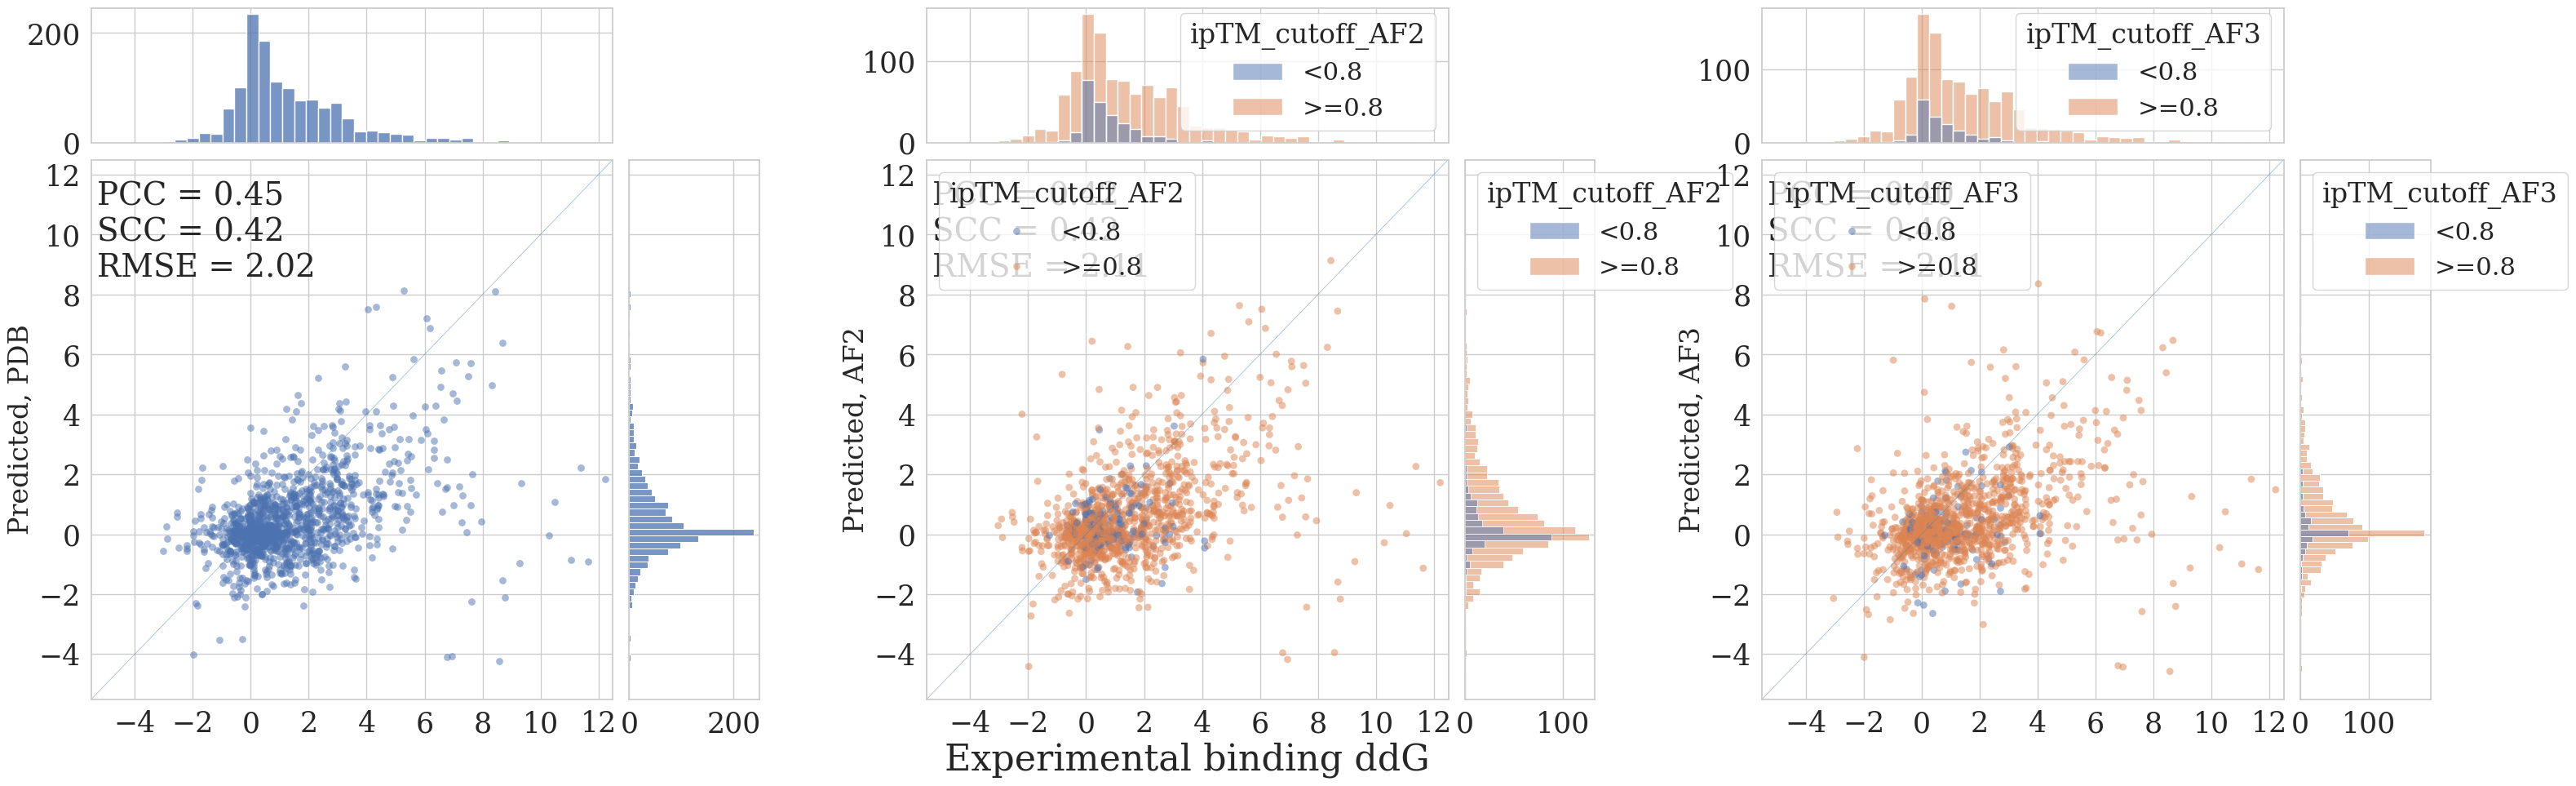

In [119]:
# import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from scipy.stats import ttest_rel
from sklearn.metrics import mean_squared_error
from math import sqrt
import os

# --- Setup ---
# Ensure the output directory exists
os.makedirs('Figures', exist_ok=True)

model_dict = {
    'PDB': '_xtal',
    'AF2': '_af2',
    'AF3': '_af3'
}

# --- Plot 1: Cartesian ddG + InterfaceAnalyzer vs. Experimental ---
fig1 = plt.figure(figsize=(37, 11))
outer_grid1 = gridspec.GridSpec(1, 3, figure=fig1, wspace=0.25, hspace=0.25)

for i, model in enumerate(model_dict.keys()):
    y_col = f'mean_ddG_infc{model_dict[model]}'
    subset = SAFES_trunc.copy()

    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_grid1[i],
                                                  width_ratios=(4, 1), height_ratios=(1, 4),
                                                  wspace=0.05, hspace=0.05)
    ax_scatter = fig1.add_subplot(inner_grid[1, 0])
    ax_histx = fig1.add_subplot(inner_grid[0, 0], sharex=ax_scatter)
    ax_histy = fig1.add_subplot(inner_grid[1, 1], sharey=ax_scatter)

    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    if not model=='PDB':
        ipTM = f'ipTM_cutoff_{model}'
    else:
        ipTM = None

    sns.scatterplot(data=subset, x='ddG_bind', y=y_col, alpha=0.5, s=40, linewidth=0,
                    hue=ipTM, ax=ax_scatter)
    sns.histplot(data=subset, x='ddG_bind', ax=ax_histx, kde=False, hue=ipTM)
    sns.histplot(data=subset, y=y_col, ax=ax_histy, kde=False, hue=ipTM)
    ax_histx.set_ylabel('')
    ax_histy.set_xlabel('')

    ax_scatter.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
    r_p, _ = stats.pearsonr(subset['ddG_bind'], subset[y_col])
    ax_scatter.annotate(f'PCC = {r_p:.2f}', xy=(-5.3, 11), fontsize=28)
    r_s, _ = stats.spearmanr(subset['ddG_bind'], subset[y_col])
    ax_scatter.annotate(f'SCC = {r_s:.2f}', xy=(-5.3, 9.8), fontsize=28)
    rmse = sqrt(mean_squared_error(subset['ddG_bind'], subset[y_col]))
    ax_scatter.annotate(f'RMSE = {rmse:.2f}', xy=(-5.3, 8.6), fontsize=28)

    #ax_scatter.set_title(f'{model}', fontsize=32)
    ax_scatter.set_xlim(-5.5, 12.5)
    ax_scatter.set_ylim(-5.5, 12.5)
    ax_scatter.set_xticks(np.arange(-4, 14, 2))
    ax_scatter.set_yticks(np.arange(-4, 14, 2))
    ax_scatter.set_xlabel("")
    ax_scatter.set_ylabel(f'Predicted, {model}')

    if i == 1: ax_scatter.set_xlabel("Experimental binding ddG", fontsize=32)
    #if i == 0: ax_scatter.set_ylabel("Predicted binding ddG", fontsize=32)

#fig1.suptitle('cartesian_ddg+IA predictions, by input', fontsize=36, y=1.0)

Text(0.5, 1.0, 'cartesian_ddg+IA, predicted values by input')

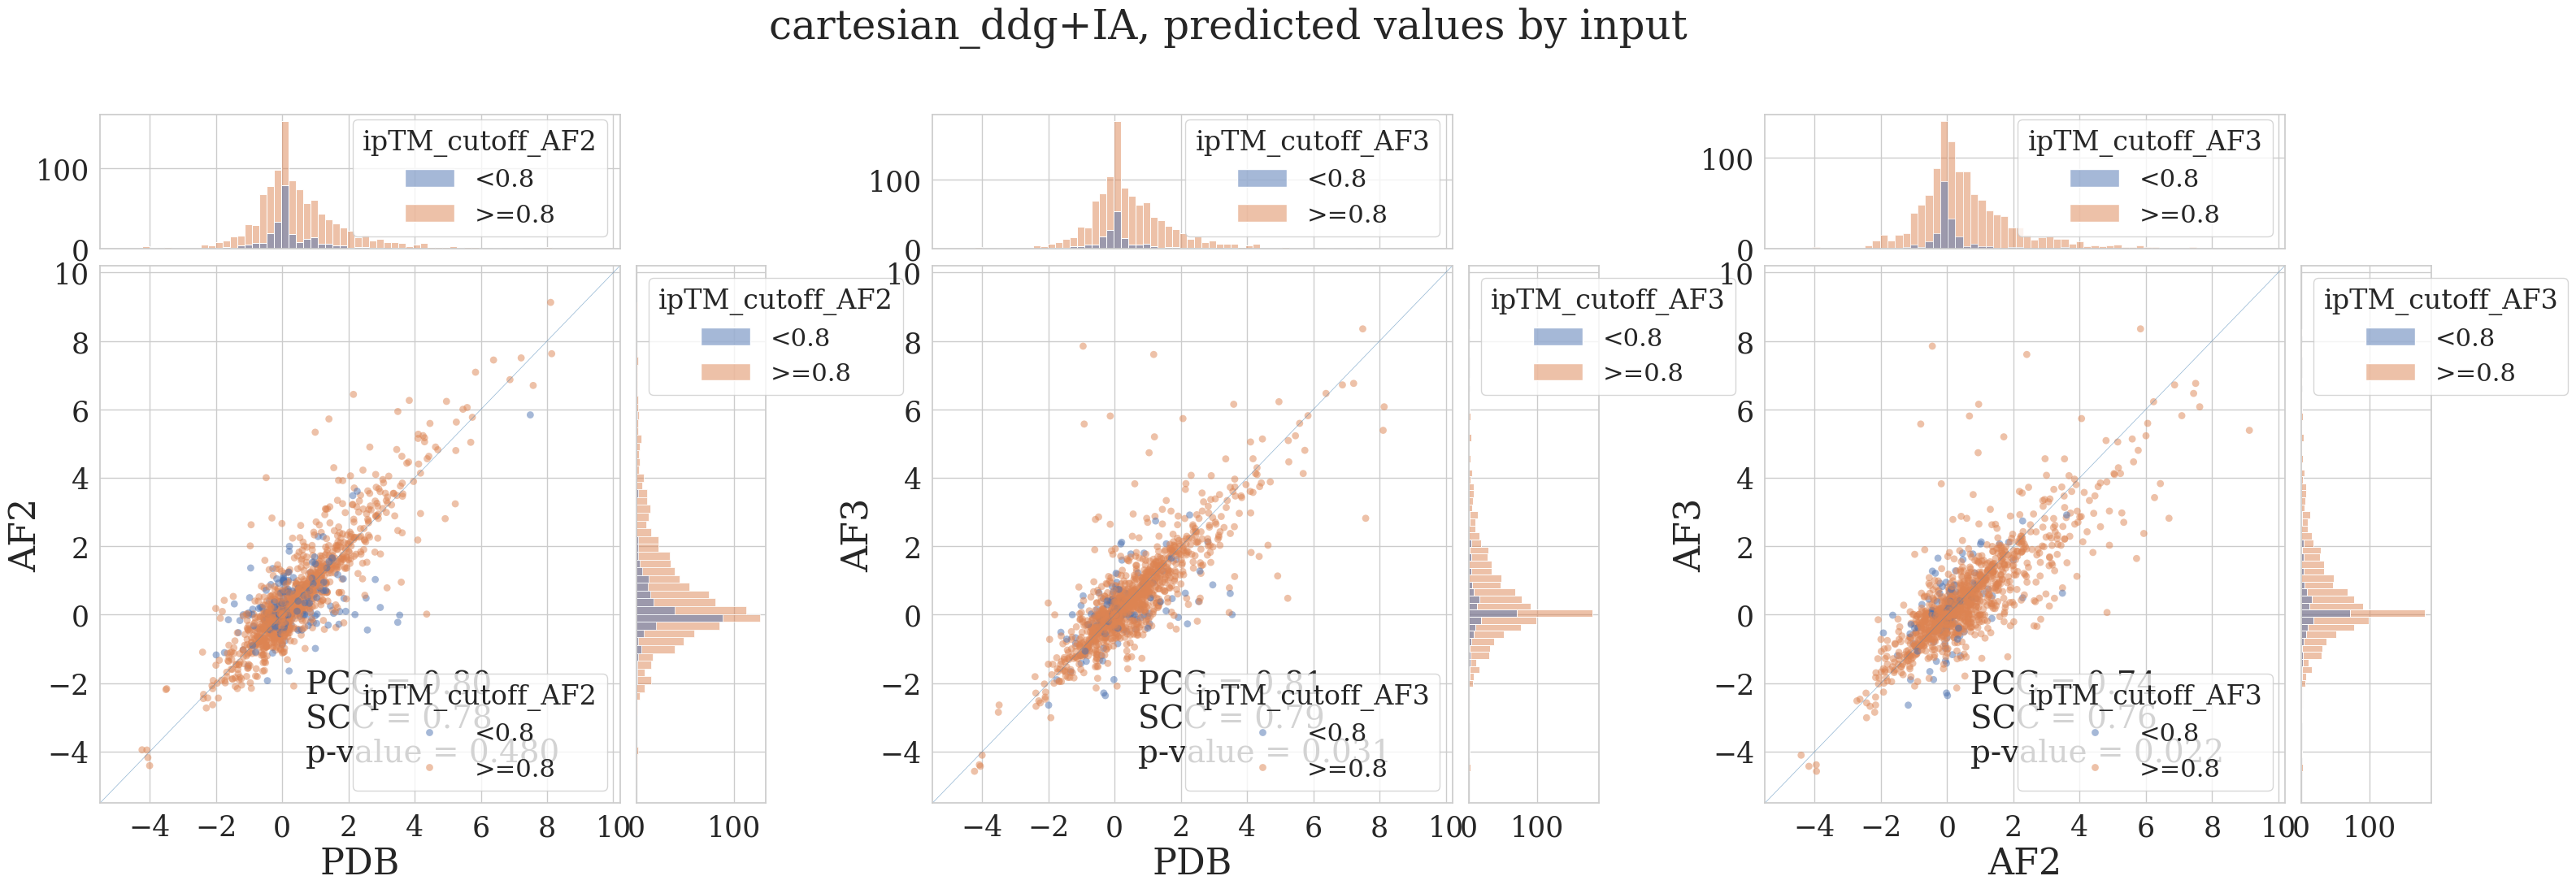

In [118]:
# --- Plot 4: Cartesian ddG + IA predicted values (PVP) ---
fig4 = plt.figure(figsize=(37, 11))
outer_grid4 = gridspec.GridSpec(1, 3, figure=fig4, wspace=0.25, hspace=0.25)
comparisons_ia = [
    (('PDB', 'mean_ddG_infc_xtal'), ('AF2', 'mean_ddG_infc_af2')),
    (('PDB', 'mean_ddG_infc_xtal'), ('AF3', 'mean_ddG_infc_af3')),
    (('AF2', 'mean_ddG_infc_af2'), ('AF3', 'mean_ddG_infc_af3'))
]

for i, ((x_name, x_col), (y_name, y_col)) in enumerate(comparisons_ia):
    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_grid4[i],
                                                  width_ratios=(4, 1), height_ratios=(1, 4),
                                                  wspace=0.05, hspace=0.05)
    ax_scatter = fig4.add_subplot(inner_grid[1, 0])
    ax_histx = fig4.add_subplot(inner_grid[0, 0], sharex=ax_scatter)
    ax_histy = fig4.add_subplot(inner_grid[1, 1], sharey=ax_scatter)

    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    subset = SAFES_trunc.copy()

    if not model=='PDB':
        ipTM = f'ipTM_cutoff_{y_name}'
    else:
        ipTM = None

    sns.scatterplot(data=subset, x=x_col, y=y_col, alpha=0.5, s=40, linewidth=0, ax=ax_scatter, hue=ipTM)
    sns.histplot(data=subset, x=x_col, ax=ax_histx, kde=False, hue=ipTM)
    sns.histplot(data=subset, y=y_col, ax=ax_histy, kde=False, hue=ipTM)
    ax_histx.set_ylabel('')
    ax_histy.set_xlabel('')

    ax_scatter.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
    r_p, _ = stats.pearsonr(subset[x_col], subset[y_col])
    ax_scatter.annotate(f'PCC = {r_p:.2f}', xy=(0.7, -2.3), fontsize=28)
    r_s, _ = stats.spearmanr(subset[x_col], subset[y_col])
    ax_scatter.annotate(f'SCC = {r_s:.2f}', xy=(0.7, -3.3), fontsize=28)
    _, p_val = ttest_rel(subset[x_col], subset[y_col])
    ax_scatter.annotate(f'p-value = {p_val:.3f}', xy=(0.7, -4.3), fontsize=28)

    ax_scatter.set_xlabel(x_name, fontsize=32)
    ax_scatter.set_ylabel(y_name, fontsize=32)
    ax_scatter.set_xlim(-5.5, 10.2)
    ax_scatter.set_ylim(-5.5, 10.2)
    ax_scatter.set_xticks(np.arange(-4, 12, 2))
    ax_scatter.set_yticks(np.arange(-4, 12, 2))

fig4.suptitle('cartesian_ddg+IA, predicted values by input', fontsize=36, y=1.0)

In [86]:
df = SAFES_trunc
print('xtal-af2', ttest_rel(df['mean_ddG_infc_xtal'], df['mean_ddG_infc_af2']))
print('xtal-af3', ttest_rel(df['mean_ddG_infc_xtal'], df['mean_ddG_infc_af3']))
print('af2-af3', ttest_rel(df['mean_ddG_infc_af2'], df['mean_ddG_infc_af3']))

xtal-af2 TtestResult(statistic=-1.5099776472411917, pvalue=0.1312879104705989, df=1323)
xtal-af3 TtestResult(statistic=2.154823641702939, pvalue=0.03135564390441325, df=1323)
af2-af3 TtestResult(statistic=3.1854640252579616, pvalue=0.001478958223643201, df=1323)


In [87]:
df = SAFES_exp
print('xtal-af2', ttest_rel(df['mean_ddG_infc_xtal'], df['mean_ddG_infc_af2']))
print('xtal-af3', ttest_rel(df['mean_ddG_infc_xtal'], df['mean_ddG_infc_af3']))
print('af2-af3', ttest_rel(df['mean_ddG_infc_af2'], df['mean_ddG_infc_af3']))

xtal-af2 TtestResult(statistic=1.3747701159454593, pvalue=0.16943551276250887, df=1323)
xtal-af3 TtestResult(statistic=2.154823641702939, pvalue=0.03135564390441325, df=1323)
af2-af3 TtestResult(statistic=-0.9956020779934658, pvalue=0.3196255797795725, df=1323)


In [ ]:
SAFES_exp.loc[SAFES_exp['mean_ddG_infc_af2']<-10][['PDB_ID', 'variant', 'mean_ddG_xtal', 'std_ddG_xtal',
       'mean_ddG_infc_xtal', 'std_ddG_infc_xtal', 'mean_ddG_af2',
       'std_ddG_af2', 'mean_ddG_infc_af2', 'std_ddG_infc_af2', 'mean_ddG_af3',
       'std_ddG_af3', 'mean_ddG_infc_af3', 'std_ddG_infc_af3', 'mean_ddG',
       'std_ddG', 'mean_ddG_infc', 'std_ddG_infc', 'ddG_bind']]

861    -0.912231 <br>
1198    3.111436 <br>
1199   -0.086432 <br>
1212    1.558096 <br>

## Bits and pieces

In [ ]:
plt.rc('font', size=23) #controls default text size
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=18) #fontsize of the x tick labels
plt.rc('ytick', labelsize=18) #fontsize of the y tick labels
sns.set(style='whitegrid', color_codes=True, font='serif', font_scale=2)

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(36, 30))
axes = axes.flatten()
# Calculate the min and max values
df=SAFES_exp.copy()
plt.setp(axes, xlim=(-4.5, 13), ylim=(-4.5, 13))

for ax, pdb_id in zip(axes, pdb_list):
    subset = df.loc[df['PDB_ID']==pdb_id]
    plot = sns.scatterplot(data = subset ,x='ddG_bind',
                       y='mean_ddG_infc_af2',
                       alpha=0.5, s=65, linewidth=0, ax=ax)
    plot.set_title(pdb_id, fontsize=25)
    ax.plot([-4, 14], [-4, 14], color='gray', ls='--', lw=1)
    r, _ = stats.pearsonr(subset['ddG_bind'], subset['mean_ddG_infc_af2'])
    plot.annotate(f'PCC = {r:.2f}', xy=(7, 0), fontsize = 16)
    r, _ = stats.spearmanr(subset['ddG_bind'], subset['mean_ddG_infc_af2'])
    plot.annotate(f'SCC = {r:.2f}', xy=(7, -1), fontsize = 16)
    iptm = sm.loc[sm['PDB_ID']==pdb_id]['ipTM_AF2'].values[0]
    plot.annotate(f'ipTM {iptm}', xy=(7, -2), fontsize = 16)
    ## ADD AXIS LIMITS
    ax.set_xlabel('')  # Remove individual x labels
    ax.set_ylabel('')

fig.suptitle('Per PDB Scetterplots, AF2', fontsize=35)
fig.text(0.5, 0.04, 'Rosetta', ha='center', fontsize=30)  # x label
fig.text(0.04, 0.5, 'Experimental binding ddG', va='center', rotation='vertical', fontsize=30)
# # Set specific tick intervals for x and y axes
# plt.xticks(np.arange(-2.5, 3, 0.2))
# #plt.yticks(np.arange(-2.5, 3, 0.5))
# plt.show()
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
# fig.savefig('/Users/jhn949/Documents/Data/PPI/Review/scatterplots_by_substitution_mCSM.pdf', format='pdf')

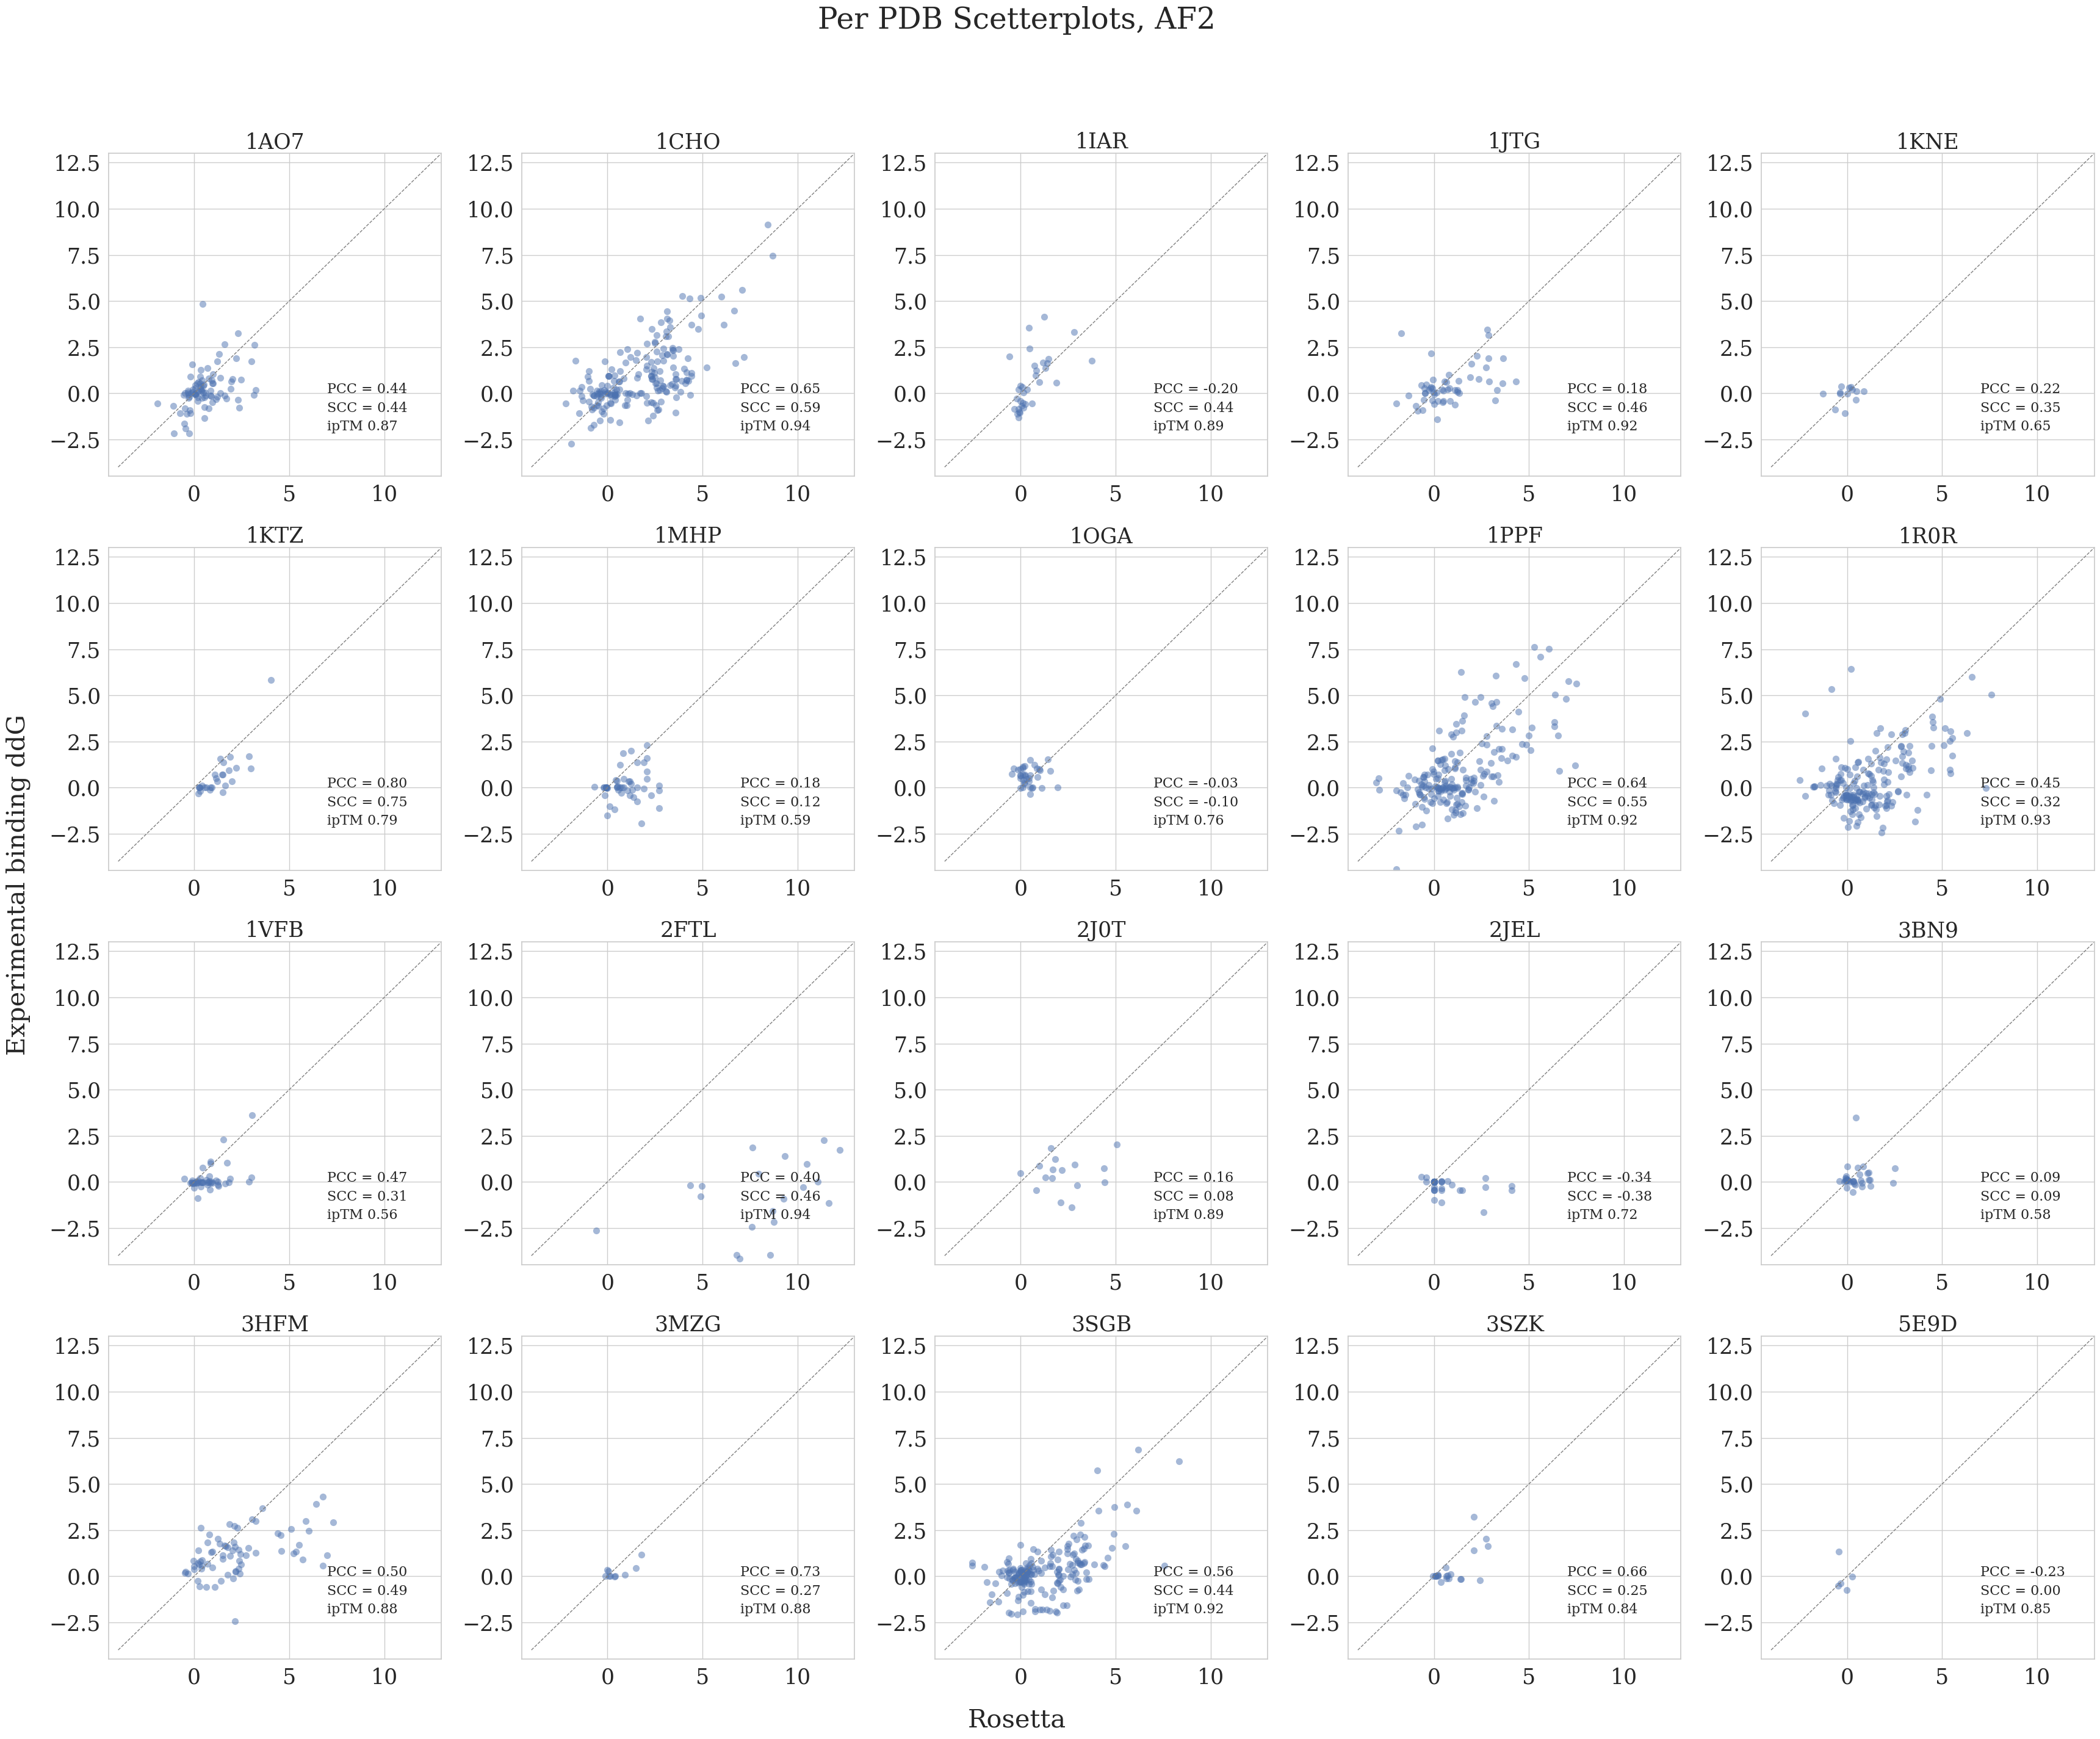

In [103]:
fig, axes = plt.subplots(4, 5, figsize=(36, 30))
axes = axes.flatten()
# Calculate the min and max values
df=SAFES_exp.copy()
plt.setp(axes, xlim=(-4.5, 13), ylim=(-4.5, 13))

for ax, pdb_id in zip(axes, pdb_list):
    subset = df.loc[df['PDB_ID']==pdb_id]
    plot = sns.scatterplot(data = subset ,x='ddG_bind',
                       y='mean_ddG_infc_af2',
                       alpha=0.5, s=65, linewidth=0, ax=ax)
    plot.set_title(pdb_id, fontsize=25)
    ax.plot([-4, 14], [-4, 14], color='gray', ls='--', lw=1)
    r, _ = stats.pearsonr(subset['ddG_bind'], subset['mean_ddG_infc_xtal'])
    plot.annotate(f'PCC = {r:.2f}', xy=(7, 0), fontsize = 16)
    r, _ = stats.spearmanr(subset['ddG_bind'], subset['mean_ddG_infc_xtal'])
    plot.annotate(f'SCC = {r:.2f}', xy=(7, -1), fontsize = 16)
    iptm = sm.loc[sm['PDB_ID']==pdb_id]['ipTM_AF2'].values[0]
    plot.annotate(f'ipTM {iptm}', xy=(7, -2), fontsize = 16)
    ## ADD AXIS LIMITS
    ax.set_xlabel('')  # Remove individual x labels
    ax.set_ylabel('')

fig.suptitle('Per PDB Scetterplots, AF2', fontsize=35)
fig.text(0.5, 0.04, 'Rosetta', ha='center', fontsize=30)  # x label
fig.text(0.04, 0.5, 'Experimental binding ddG', va='center', rotation='vertical', fontsize=30)
# # Set specific tick intervals for x and y axes
# plt.xticks(np.arange(-2.5, 3, 0.2))
# #plt.yticks(np.arange(-2.5, 3, 0.5))
# plt.show()
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
# fig.savefig('/Users/jhn949/Documents/Data/PPI/Review/scatterplots_by_substitution_mCSM.pdf', format='pdf')

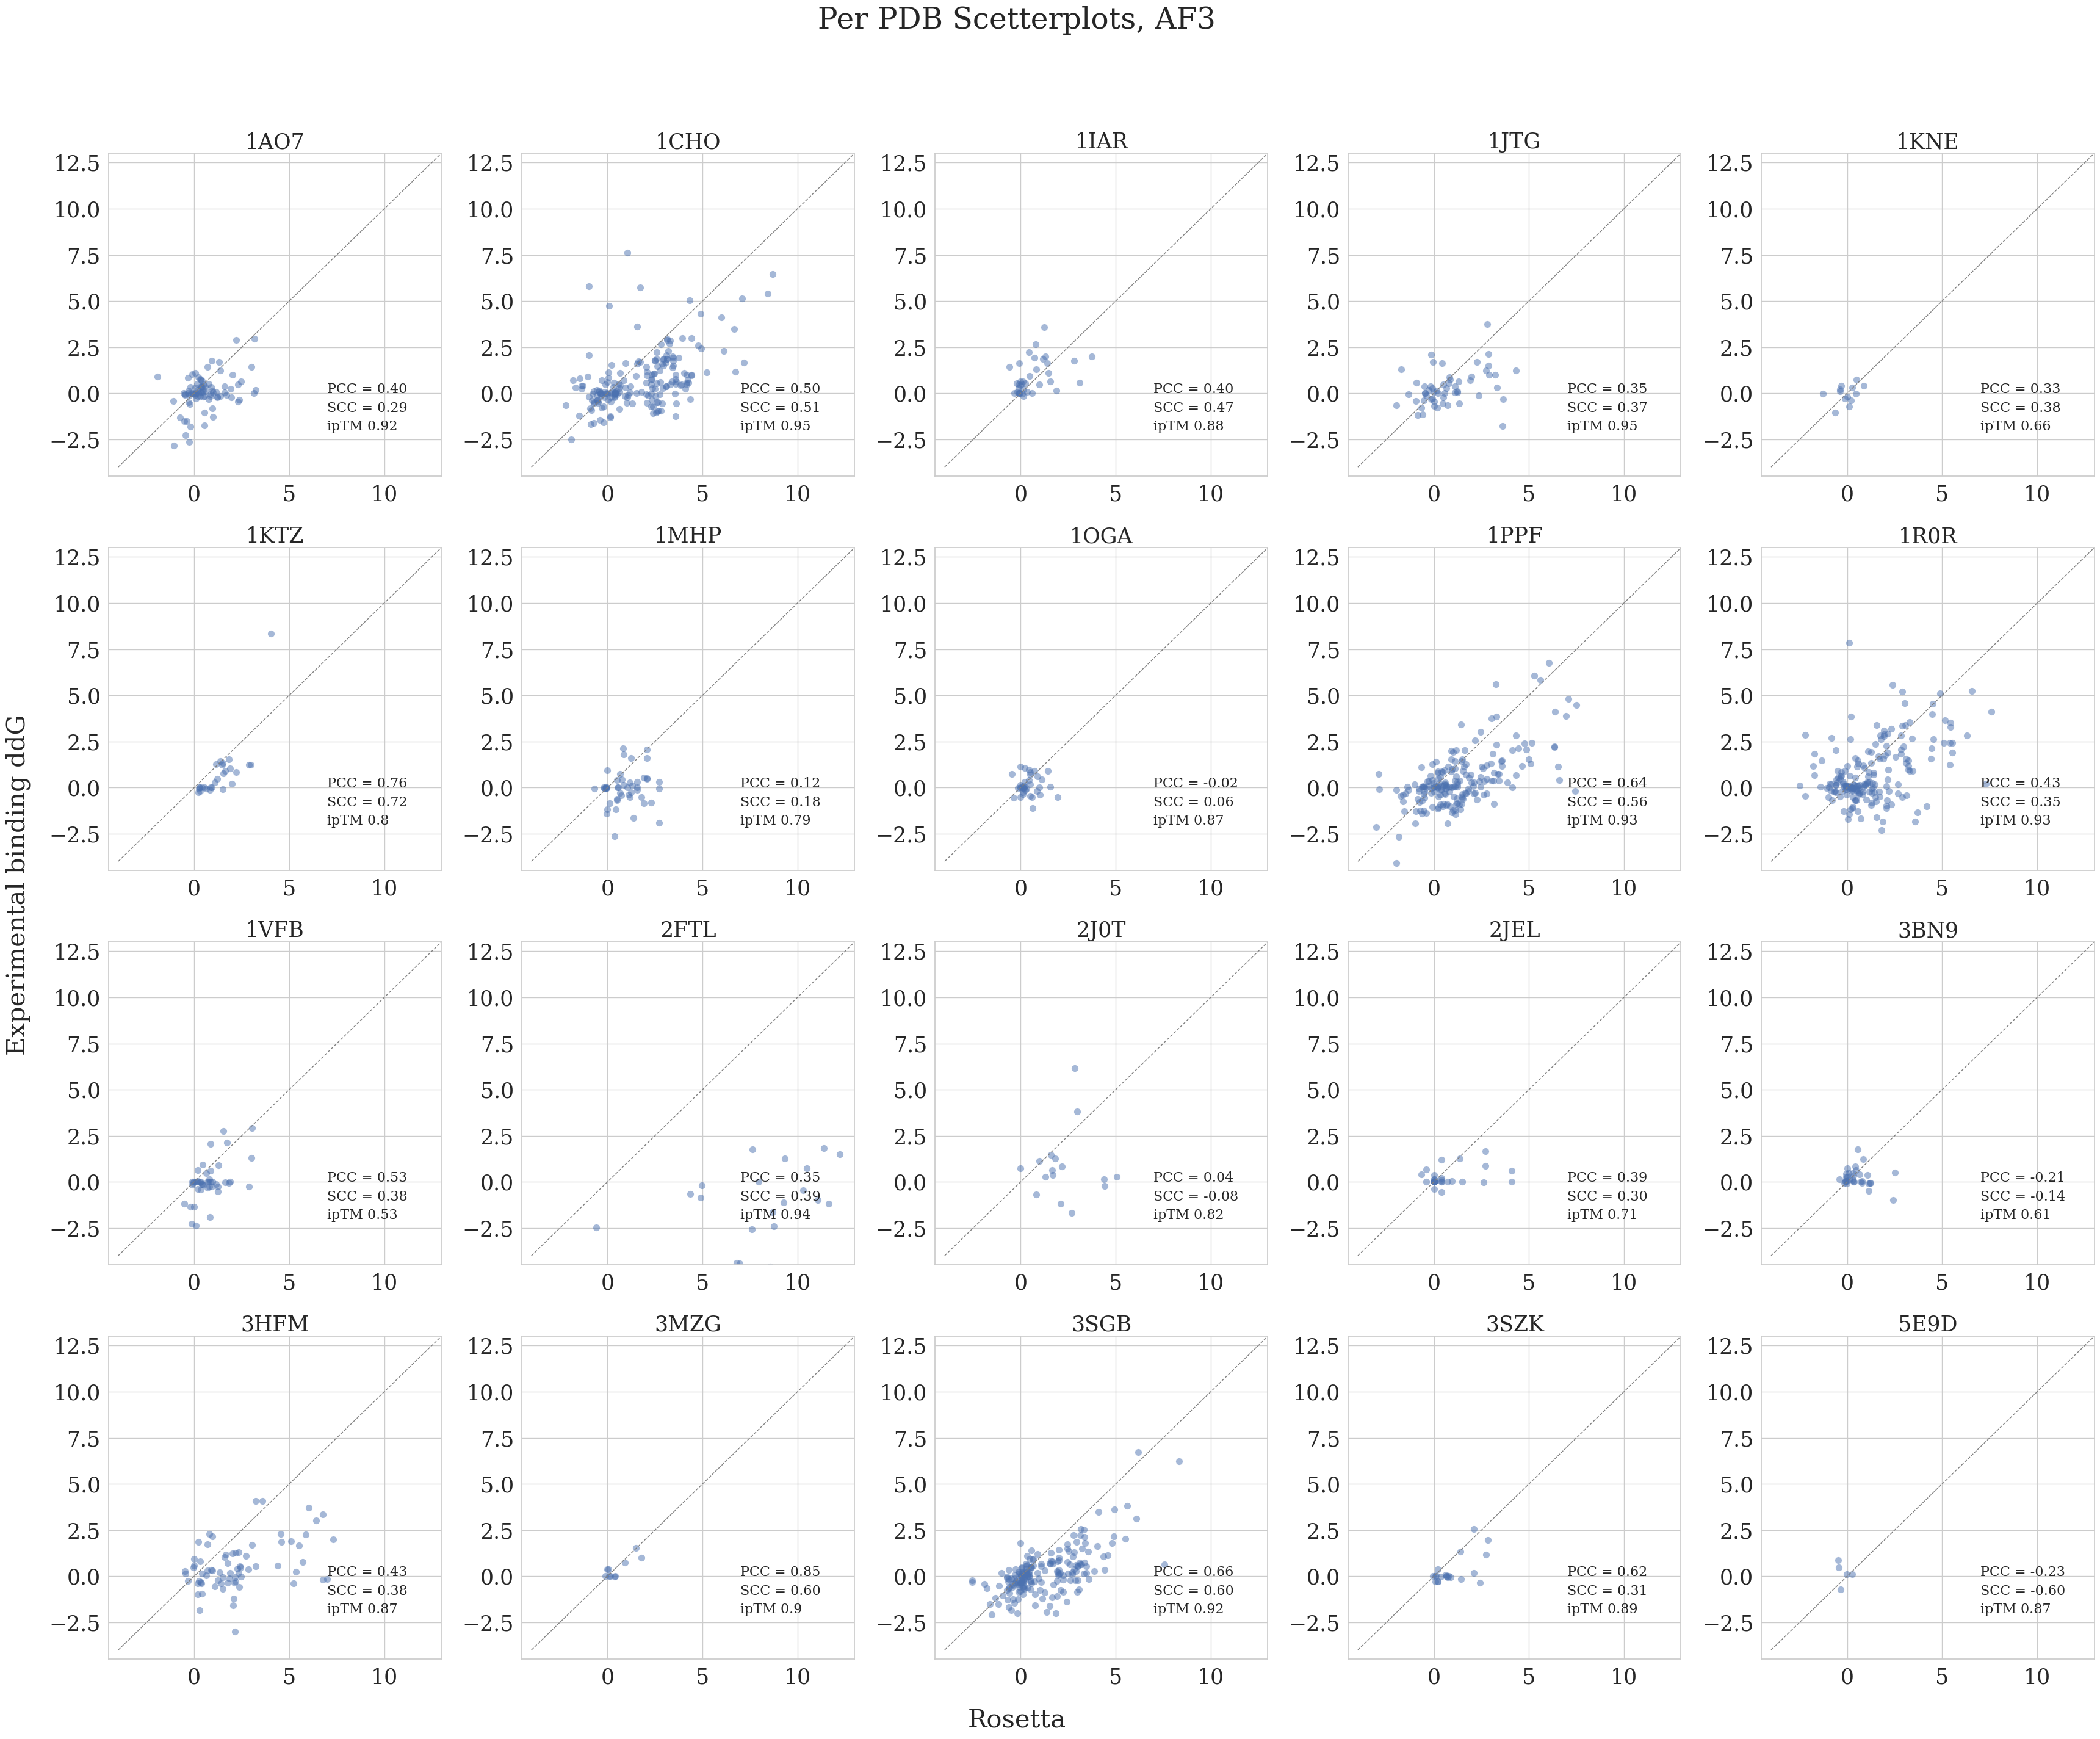

In [104]:
fig, axes = plt.subplots(4, 5, figsize=(36, 30))
axes = axes.flatten()
# Calculate the min and max values
df=SAFES_exp.copy()
plt.setp(axes, xlim=(-4.5, 13), ylim=(-4.5, 13))

for ax, pdb_id in zip(axes, pdb_list):
    subset = df.loc[df['PDB_ID']==pdb_id]
    plot = sns.scatterplot(data = subset ,x='ddG_bind',
                       y='mean_ddG_infc_af3',
                       alpha=0.5, s=65, linewidth=0, ax=ax)
    plot.set_title(pdb_id, fontsize=25)
    ax.plot([-4, 14], [-4, 14], color='gray', ls='--', lw=1)
    r, _ = stats.pearsonr(subset['ddG_bind'], subset['mean_ddG_infc_af3'])
    plot.annotate(f'PCC = {r:.2f}', xy=(7, 0), fontsize = 16)
    r, _ = stats.spearmanr(subset['ddG_bind'], subset['mean_ddG_infc_af3'])
    plot.annotate(f'SCC = {r:.2f}', xy=(7, -1), fontsize = 16)
    iptm = sm.loc[sm['PDB_ID']==pdb_id]['ipTM_AF3'].values[0]
    plot.annotate(f'ipTM {iptm}', xy=(7, -2), fontsize = 16)
    ## ADD AXIS LIMITS
    ax.set_xlabel('')  # Remove individual x labels
    ax.set_ylabel('')

fig.suptitle('Per PDB Scetterplots, AF3', fontsize=35)
fig.text(0.5, 0.04, 'Experimental binding ddG', ha='center', fontsize=30)  # x label
fig.text(0.04, 0.5, 'Rosetta', va='center', rotation='vertical', fontsize=30)
# # Set specific tick intervals for x and y axes
# plt.xticks(np.arange(-2.5, 3, 0.2))
# #plt.yticks(np.arange(-2.5, 3, 0.5))
# plt.show()
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
# fig.savefig('/Users/jhn949/Documents/Data/PPI/Review/scatterplots_by_substitution_mCSM.pdf', format='pdf')

In [220]:
SAFES_exp.loc[SAFES_exp['PDB_ID']=='3SZK'][['variant', 'ddG_bind', 'mean_ddG_xtal', 'mean_ddG_infc_xtal', 'mean_ddG_infc_af2', 'mean_ddG_infc_af3', 'iMutation_Location(s)']]

variant  ddG_bind  mean_ddG_xtal  mean_ddG_infc_xtal  mean_ddG_infc_af2  \
1368   D330A  0.193931       0.781724       -5.873746e-02           0.035073   
1369   D333A  0.193931       0.255517       -1.495168e-03          -0.003960   
1370   D402A  0.639469       1.027931        5.426919e-02           0.481432   
1371   D403A  0.660300       1.216897        5.663096e-03           0.006233   
1372   E405A  0.795924       0.636552       -1.579219e-02          -0.132462   
1373   E406A  0.660300       1.698276        7.622240e-03          -0.120257   
1374   F325A  2.106692       1.753448        5.704576e-01           1.390239   
1375   F326A  2.089240       4.125862        3.302962e+00           3.211828   
1376   G404A  0.355717       1.386552       -2.230374e-02          -0.329521   
1377   H324A  2.407856       1.609540        6.501501e-02          -0.216438   
1378   K338A  0.091397       1.198966        5.331521e-12          -0.003844   
1379   K339A -0.034094       0.888621       -7.343974e-03          -0.001281   
1380   N317A  0.118836       0.995287       -7.747047e-03          -0.005240   
1381   N348A  0.193931       1.017356        1.605328e+00           0.088705   
1382   Q321A  0.727674       1.239655        1.518104e-01           0.050075   
1383   S351A  1.437360       0.075287       -2.269334e-01          -0.163351   
1384   T320A  0.884906       1.529655        9.708517e-02           0.093444   
1385   T352A  1.394695       1.666897        1.243816e+00          -0.166909   
1386   V309A  0.091397       2.418966        3.076441e-03          -0.003369   
1387   Y322A  2.757396       3.223793        1.625647e+00           2.023185   
1388   Y323A  2.830954       3.816322        2.072542e+00           1.638604   

      mean_ddG_infc_af3 iMutation_Location(s)  
1368      -2.807935e-01                   SUR  
1369      -2.877600e-01                   INT  
1370       6.313216e-02                   RIM  
1371      -1.155372e-03                   SUR  
1372       2.460007e-03                   SUR  
1373      -4.769833e-03                   SUR  
1374       1.885131e-01                   RIM  
1375       2.550267e+00                   COR  
1376      -1.935183e-02                   SUR  
1377      -3.510455e-01                   INT  
1378       2.475114e-03                   SUR  
1379       3.292998e-11                   SUR  
1380       3.096788e-02                   SUR  
1381       3.706217e-01                   COR  
1382      -4.779799e-02                   INT  
1383      -1.467463e-01                   RIM  
1384      -5.590396e-02                   SUR  
1385       1.346679e+00                   SUP  
1386      -3.045607e-01                   INT  
1387       1.163914e+00                   RIM  
1388       1.969243e+00                   COR

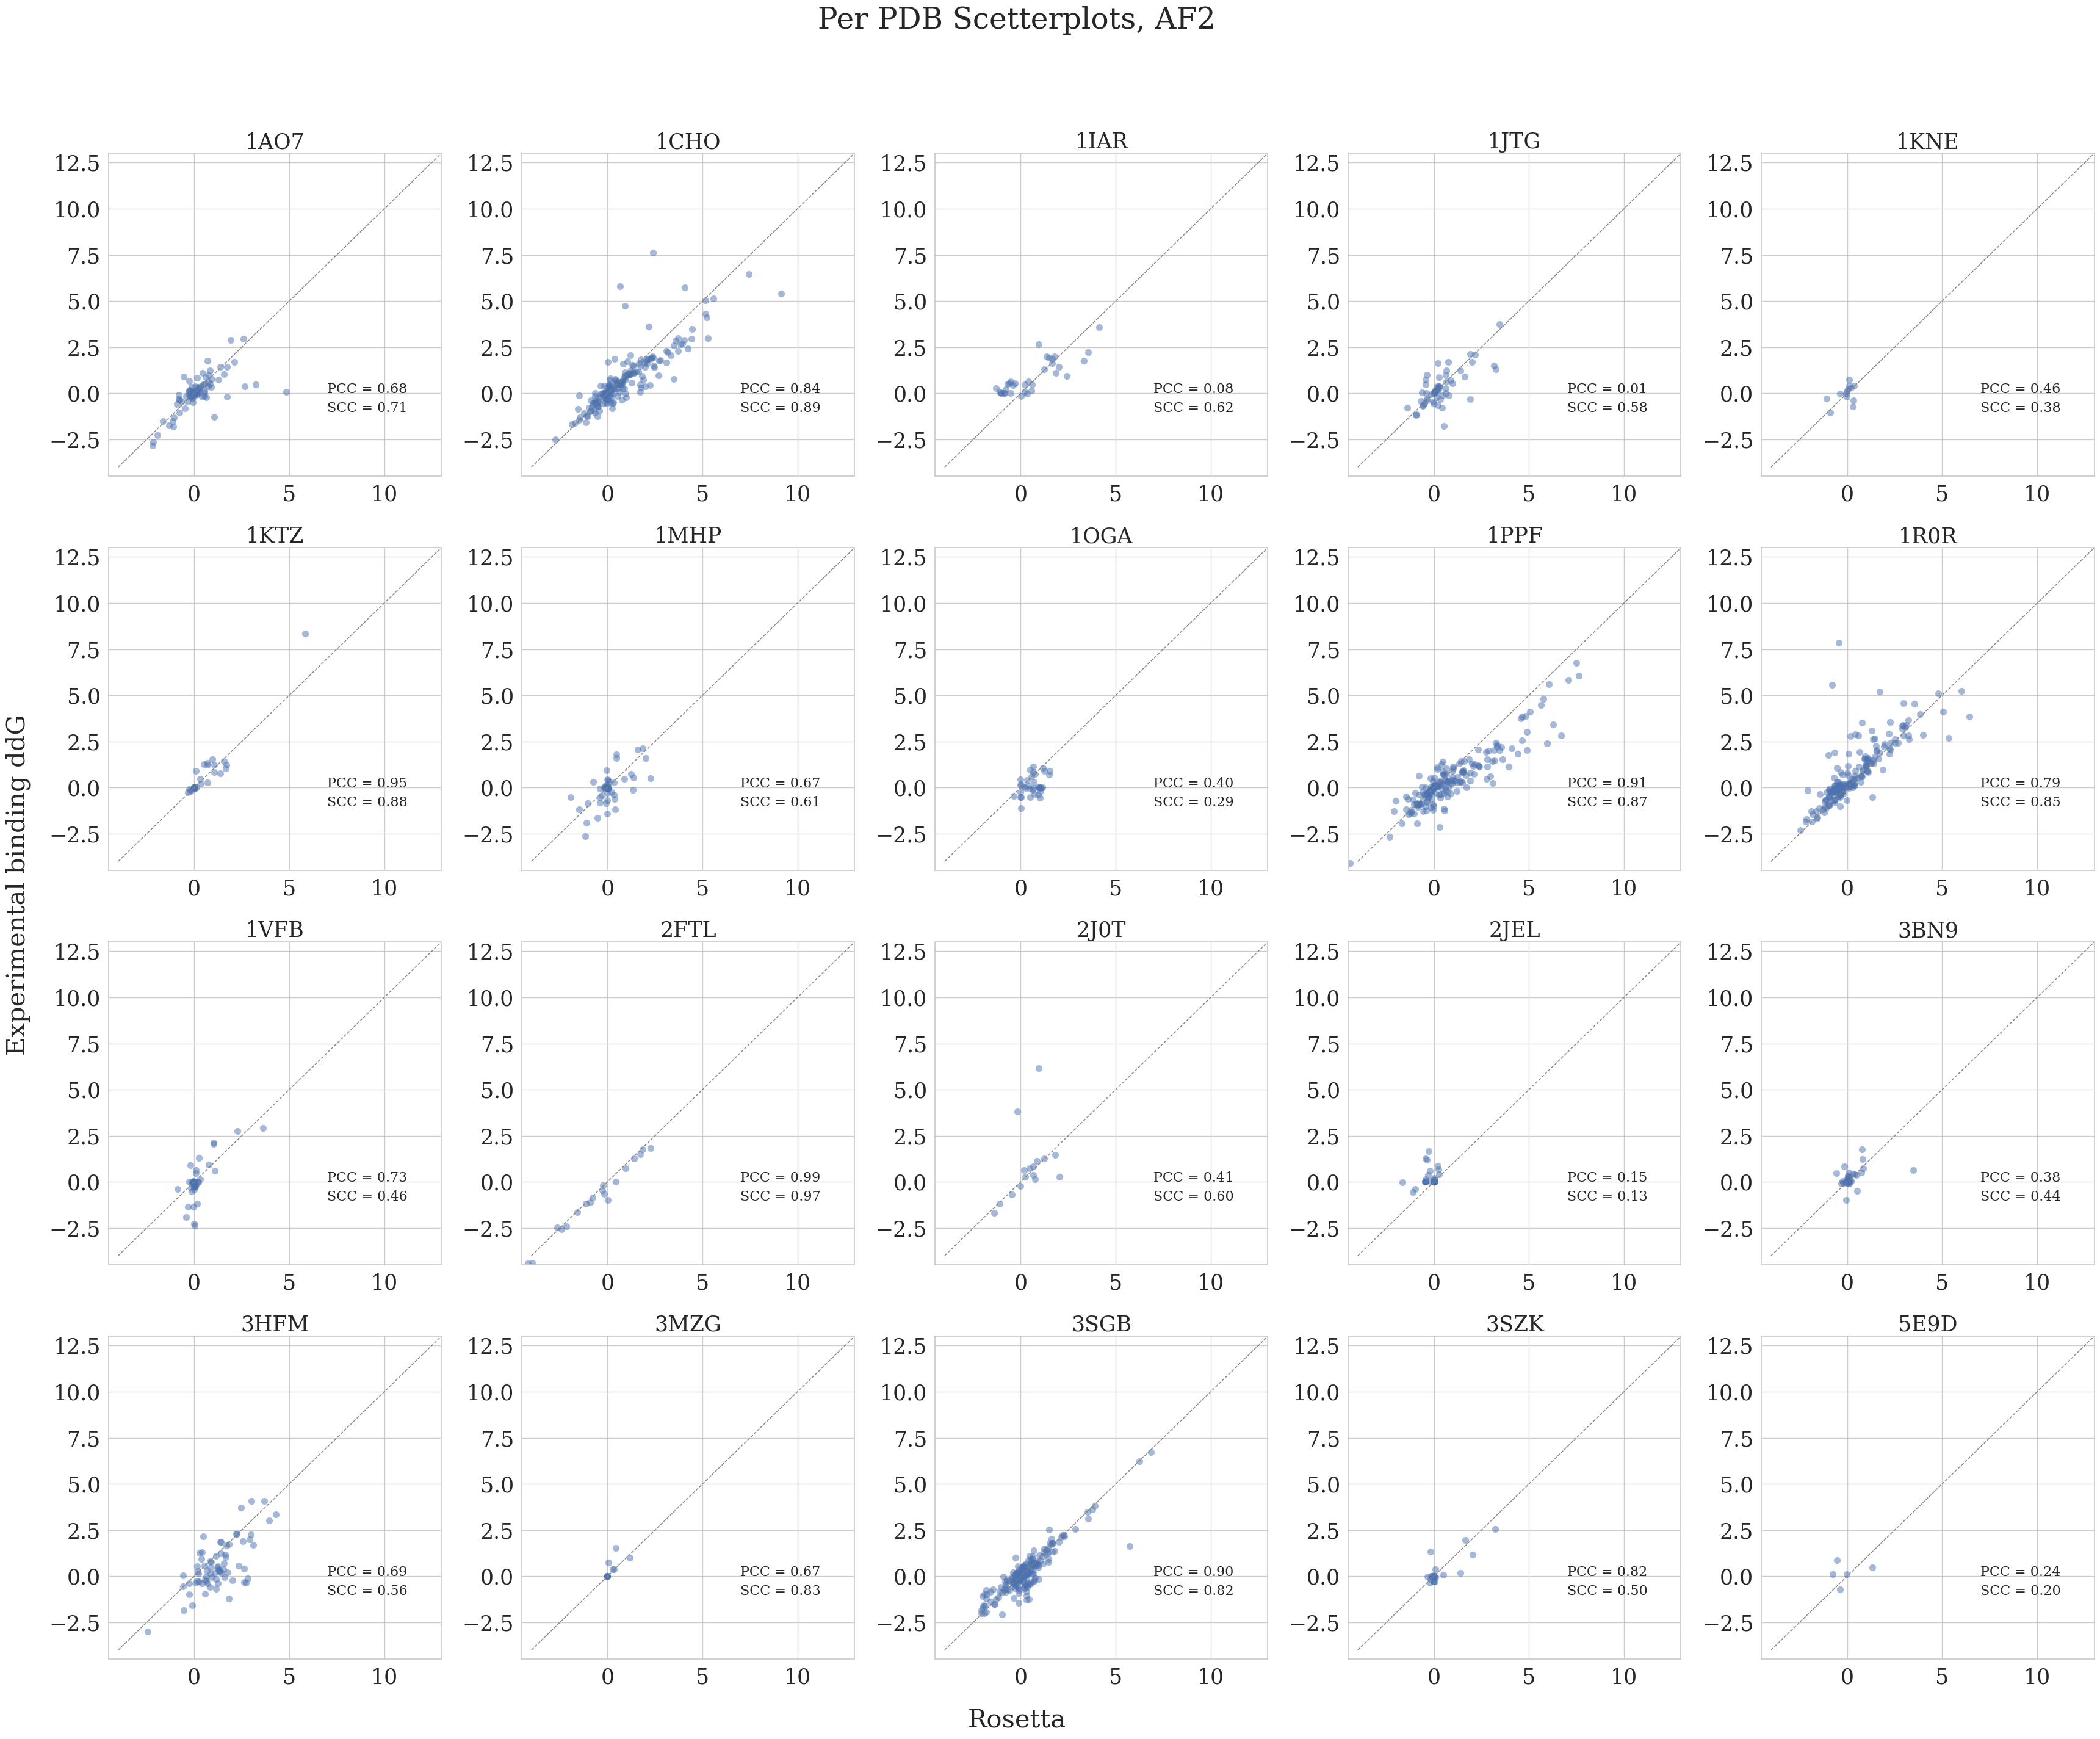

In [101]:
fig, axes = plt.subplots(4, 5, figsize=(36, 30))
axes = axes.flatten()
# Calculate the min and max values
df=SAFES_exp.copy()
plt.setp(axes, xlim=(-4.5, 13), ylim=(-4.5, 13))

for ax, pdb_id in zip(axes, pdb_list):
    subset = df.loc[df['PDB_ID']==pdb_id]
    plot = sns.scatterplot(data = subset, x='mean_ddG_infc_af2',
                       y='mean_ddG_infc_af3',
                       alpha=0.5, s=65, linewidth=0, ax=ax)
    plot.set_title(pdb_id, fontsize=25)
    ax.plot([-4, 14], [-4, 14], color='gray', ls='--', lw=1)
    r, p = stats.pearsonr(subset['mean_ddG_infc_af2'], subset['mean_ddG_infc_af3'])
    plot.annotate(f'PCC = {r:.2f}', xy=(7, 0), fontsize = 16)
    r, p = stats.spearmanr(subset['mean_ddG_infc_af2'], subset['mean_ddG_infc_af3'])
    plot.annotate(f'SCC = {r:.2f}', xy=(7, -1), fontsize = 16)
    ## ADD AXIS LIMITS
    ax.set_xlabel('')  # Remove individual x labels
    ax.set_ylabel('')

fig.suptitle('Per PDB Scetterplots, AF2', fontsize=35)
fig.text(0.5, 0.04, 'Rosetta', ha='center', fontsize=30)  # x label
fig.text(0.04, 0.5, 'Experimental binding ddG', va='center', rotation='vertical', fontsize=30)
# # Set specific tick intervals for x and y axes
# plt.xticks(np.arange(-2.5, 3, 0.2))
# #plt.yticks(np.arange(-2.5, 3, 0.5))
# plt.show()
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
# fig.savefig('/Users/jhn949/Documents/Data/PPI/Review/scatterplots_by_substitution_mCSM.pdf', format='pdf')

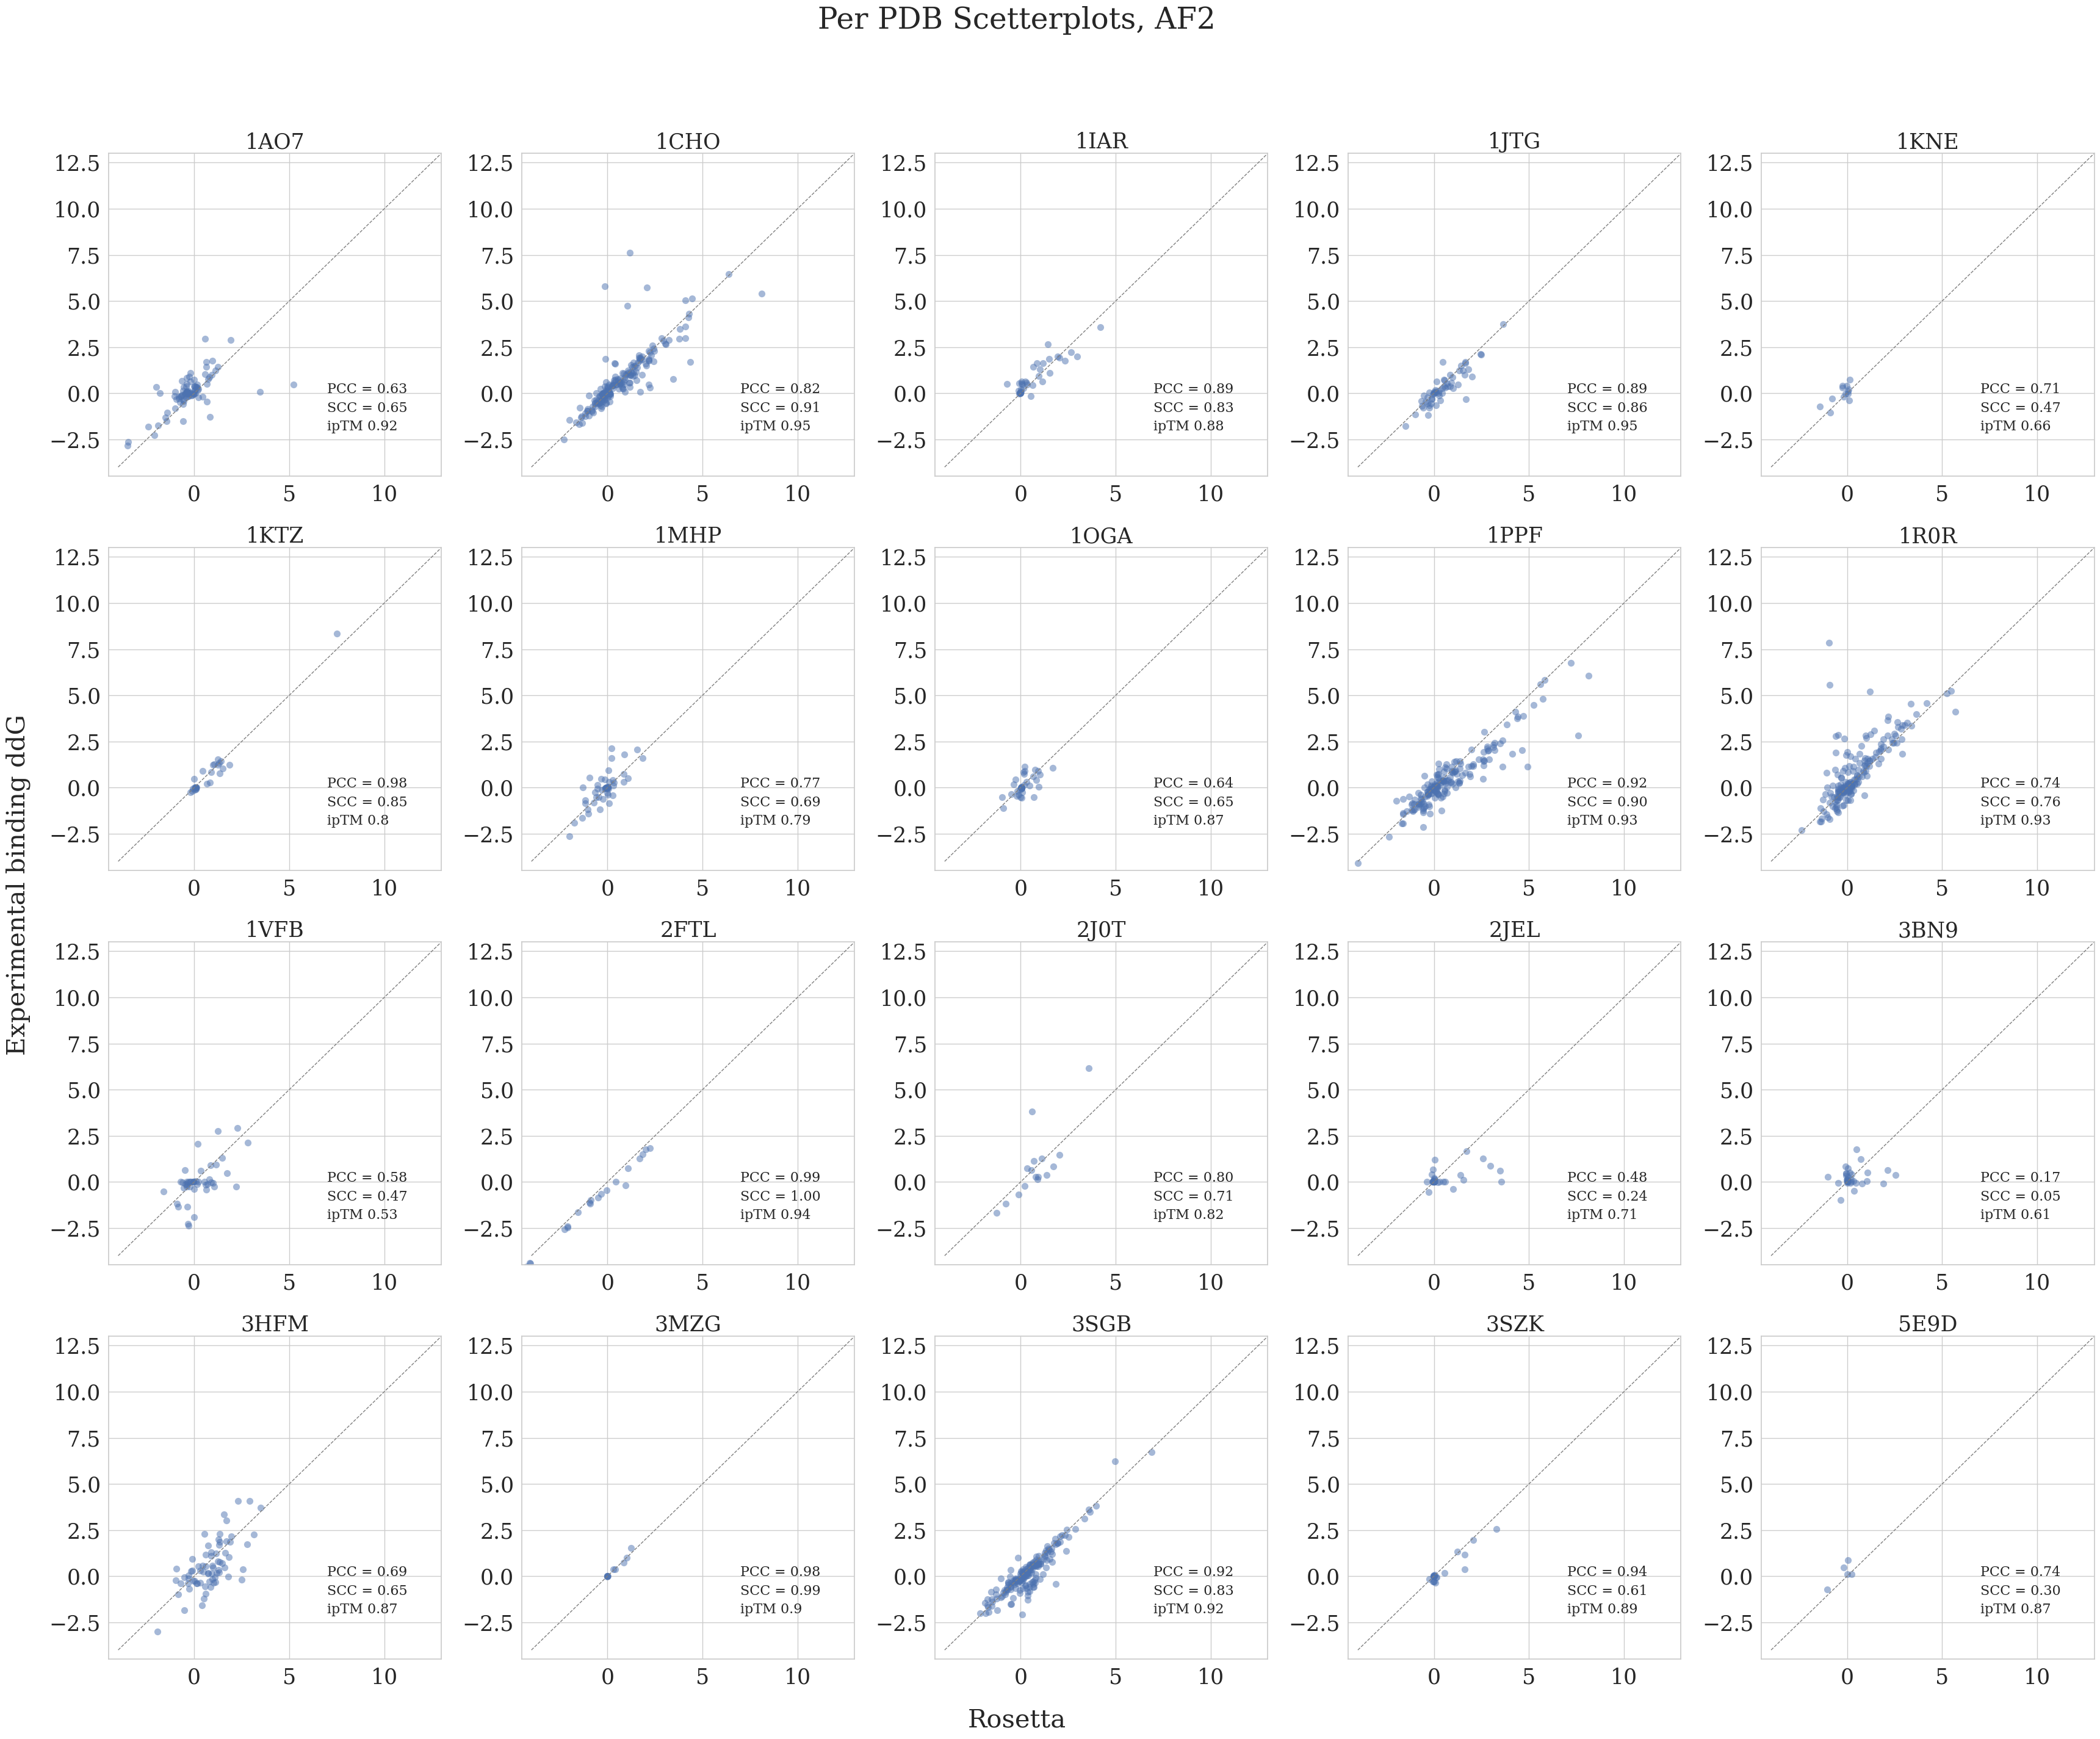

In [100]:
fig, axes = plt.subplots(4, 5, figsize=(36, 30))
axes = axes.flatten()
# Calculate the min and max values
df=SAFES_exp.copy()
plt.setp(axes, xlim=(-4.5, 13), ylim=(-4.5, 13))

for ax, pdb_id in zip(axes, pdb_list):
    subset = df.loc[df['PDB_ID']==pdb_id]
    plot = sns.scatterplot(data = subset, x='mean_ddG_infc_xtal',
                       y='mean_ddG_infc_af3',
                       alpha=0.5, s=65, linewidth=0, ax=ax)
    plot.set_title(pdb_id, fontsize=25)
    ax.plot([-4, 14], [-4, 14], color='gray', ls='--', lw=1)
    r, p = stats.pearsonr(subset['mean_ddG_infc_xtal'], subset['mean_ddG_infc_af3'])
    plot.annotate(f'PCC = {r:.2f}', xy=(7, 0), fontsize = 16)
    r, p = stats.spearmanr(subset['mean_ddG_infc_xtal'], subset['mean_ddG_infc_af3'])
    plot.annotate(f'SCC = {r:.2f}', xy=(7, -1), fontsize = 16)
    iptm = sm.loc[sm['PDB_ID']==pdb_id]['ipTM_AF3'].values[0]
    plot.annotate(f'ipTM {iptm}', xy=(7, -2), fontsize = 16)
    ## ADD AXIS LIMITS
    ax.set_xlabel('')  # Remove individual x labels
    ax.set_ylabel('')

fig.suptitle('Per PDB Scetterplots, AF2', fontsize=35)
fig.text(0.5, 0.04, 'Rosetta', ha='center', fontsize=30)  # x label
fig.text(0.04, 0.5, 'Experimental binding ddG', va='center', rotation='vertical', fontsize=30)
# # Set specific tick intervals for x and y axes
# plt.xticks(np.arange(-2.5, 3, 0.2))
# #plt.yticks(np.arange(-2.5, 3, 0.5))
# plt.show()
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
# fig.savefig('/Users/jhn949/Documents/Data/PPI/Review/scatterplots_by_substitution_mCSM.pdf', format='pdf')

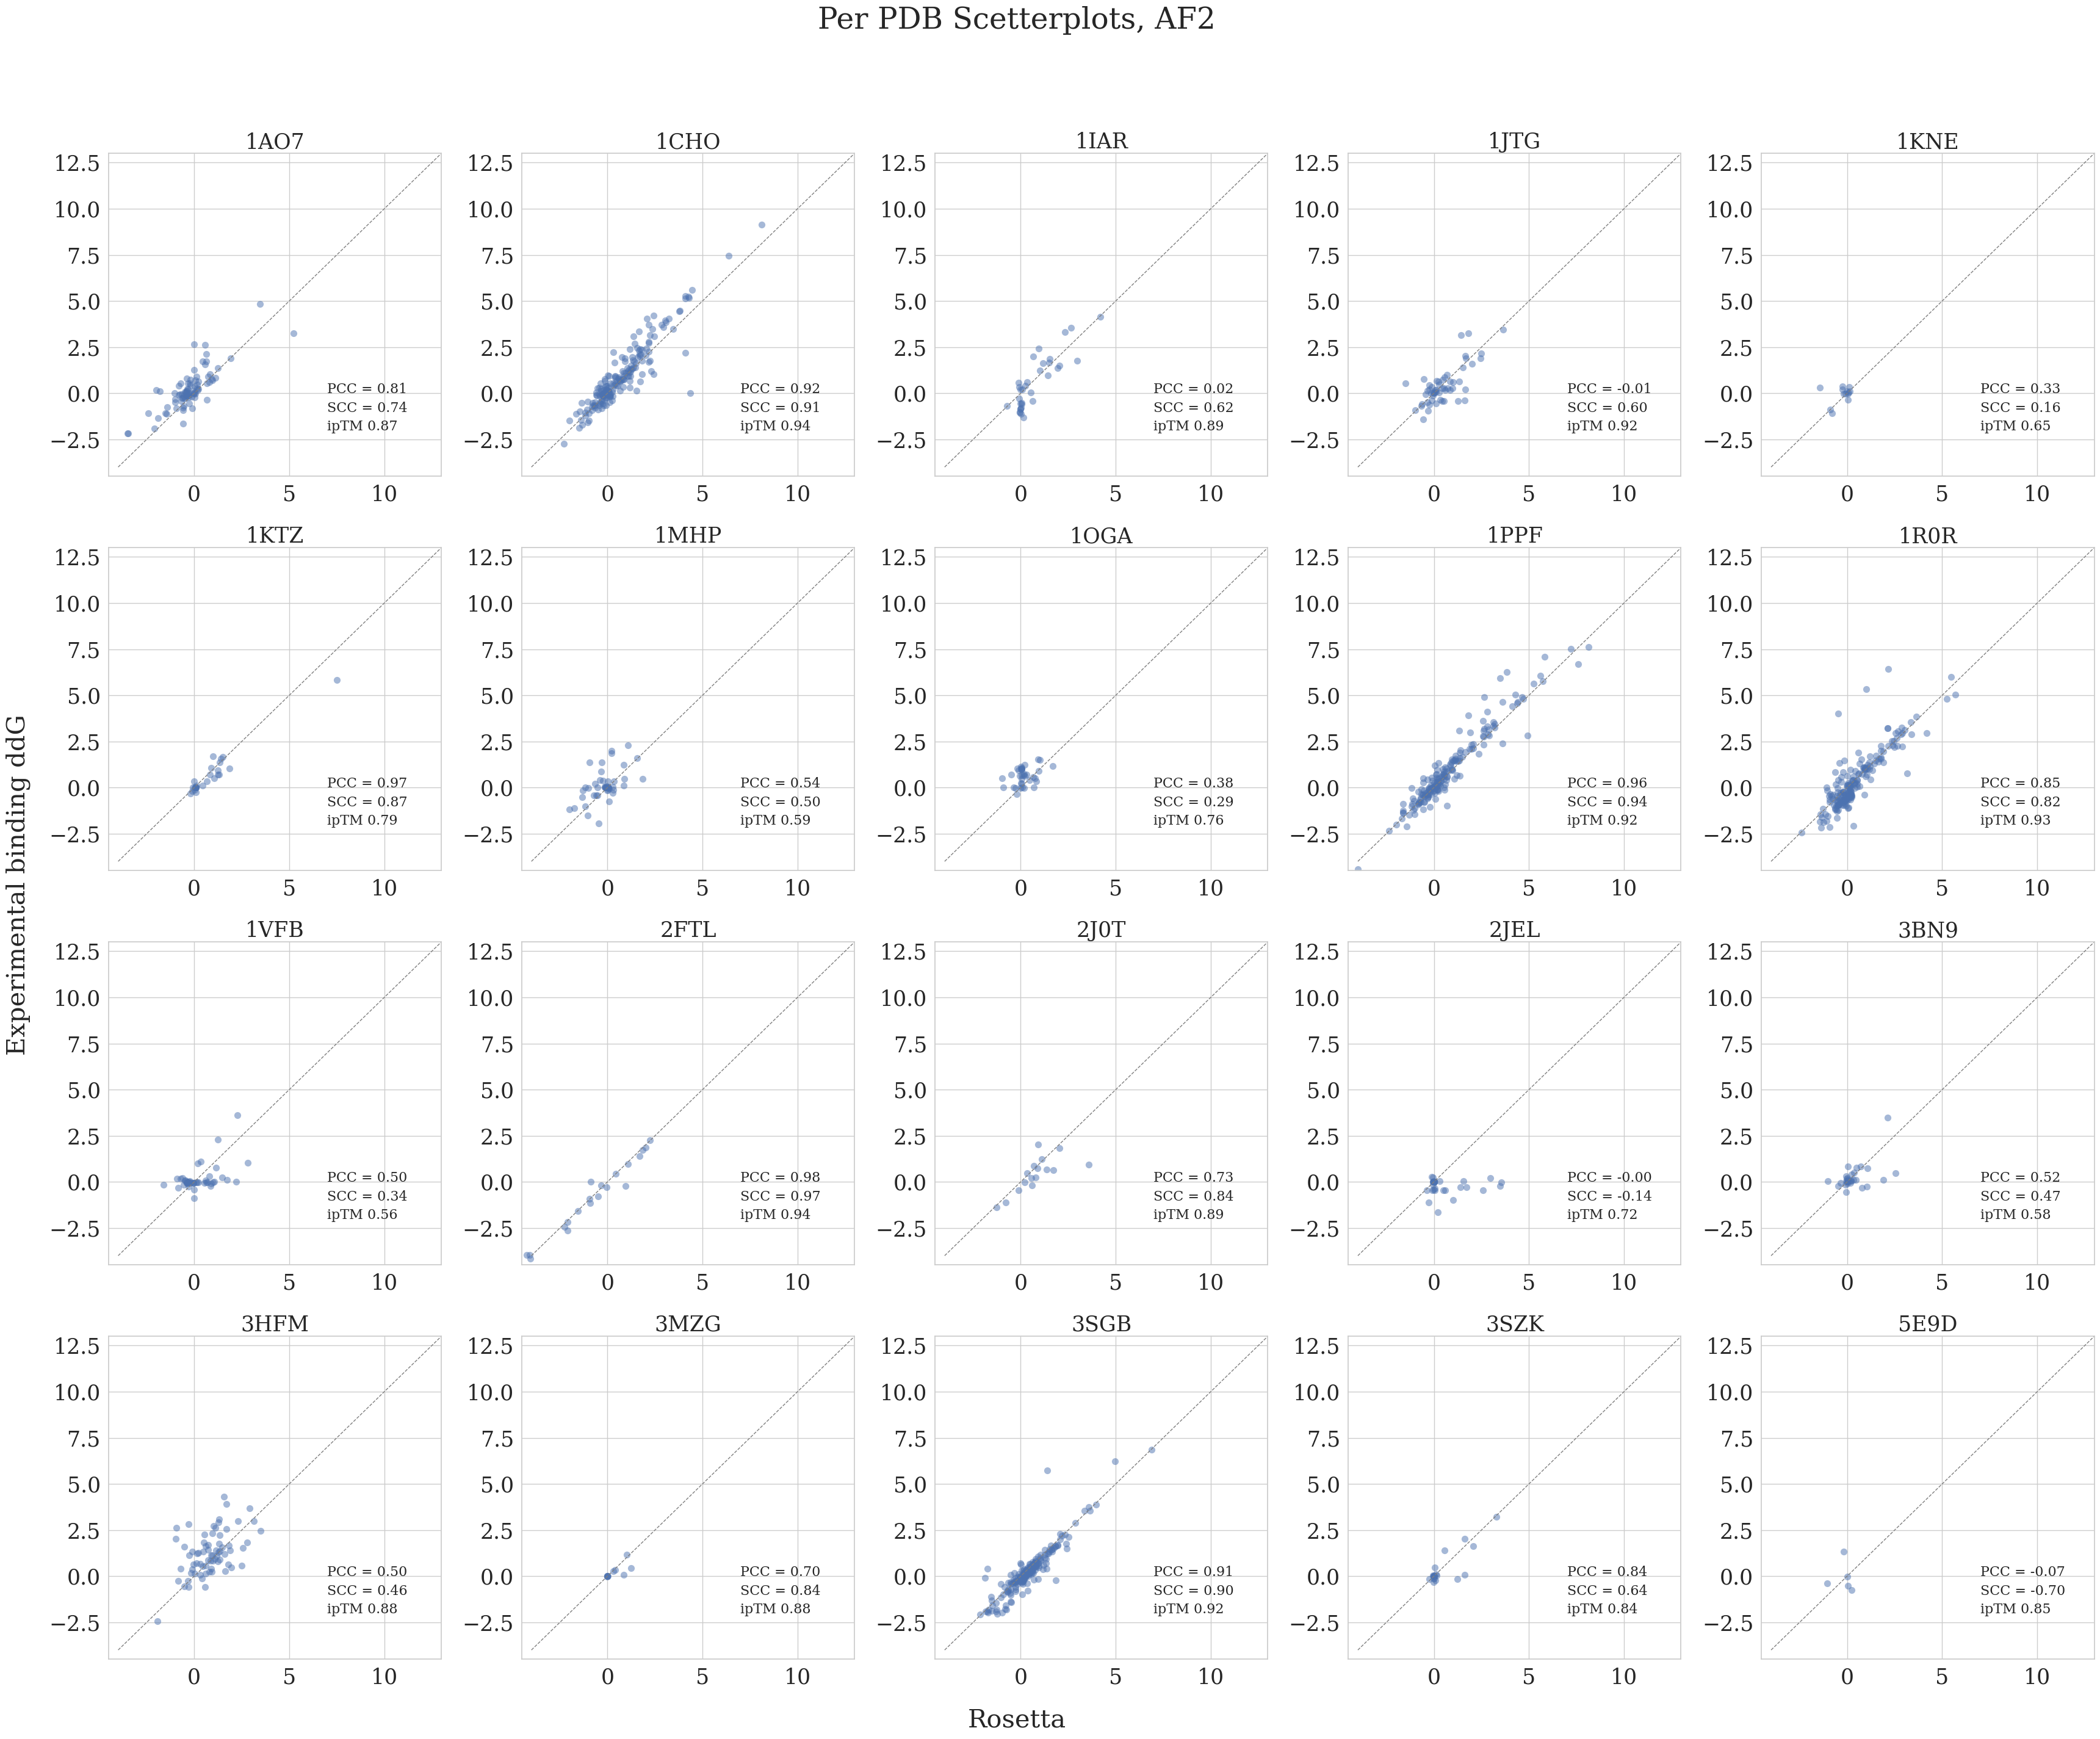

In [89]:
fig, axes = plt.subplots(4, 5, figsize=(36, 30))
axes = axes.flatten()
# Calculate the min and max values
df=SAFES_exp.copy()
plt.setp(axes, xlim=(-4.5, 13), ylim=(-4.5, 13))

for ax, pdb_id in zip(axes, pdb_list):
    subset = df.loc[df['PDB_ID']==pdb_id]
    plot = sns.scatterplot(data = subset, x='mean_ddG_infc_xtal',
                       y='mean_ddG_infc_af2',
                       alpha=0.5, s=65, linewidth=0, ax=ax)
    plot.set_title(pdb_id, fontsize=25)
    ax.plot([-4, 14], [-4, 14], color='gray', ls='--', lw=1)
    r, p = stats.pearsonr(subset['mean_ddG_infc_xtal'], subset['mean_ddG_infc_af2'])
    plot.annotate(f'PCC = {r:.2f}', xy=(7, 0), fontsize = 16)
    r, p = stats.spearmanr(subset['mean_ddG_infc_xtal'], subset['mean_ddG_infc_af2'])
    plot.annotate(f'SCC = {r:.2f}', xy=(7, -1), fontsize = 16)
    iptm = sm.loc[sm['PDB_ID']==pdb_id]['ipTM_AF2'].values[0]
    plot.annotate(f'ipTM {iptm}', xy=(7, -2), fontsize = 16)
    ## ADD AXIS LIMITS
    ax.set_xlabel('')  # Remove individual x labels
    ax.set_ylabel('')

fig.suptitle('Per PDB Scetterplots, AF2', fontsize=35)
fig.text(0.5, 0.04, 'Rosetta', ha='center', fontsize=30)  # x label
fig.text(0.04, 0.5, 'Experimental binding ddG', va='center', rotation='vertical', fontsize=30)
# # Set specific tick intervals for x and y axes
# plt.xticks(np.arange(-2.5, 3, 0.2))
# #plt.yticks(np.arange(-2.5, 3, 0.5))
# plt.show()
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
# fig.savefig('/Users/jhn949/Documents/Data/PPI/Review/scatterplots_by_substitution_mCSM.pdf', format='pdf')

In [88]:
sm.loc[(sm['AF3_PCC_xtal']-sm['AF3_SCC_xtal'])>0.1]

PDB_ID  RMSD_AF2  pTM_AF2  ipTM_AF2  RMSD_AF3  pTM_AF3  ipTM_AF3  \
4    1KNE      0.56     0.68      0.65      0.37     0.70      0.66   
5    1KTZ      0.48     0.75      0.79      0.46     0.78      0.80   
10   1VFB      1.81     0.69      0.56      3.26     0.66      0.53   
13   2JEL      0.87     0.78      0.72      1.12     0.75      0.71   
14   3BN9      4.69     0.67      0.58      6.82     0.66      0.61   
18   3SZK     15.78     0.88      0.84      0.72     0.91      0.89   
19   5E9D      2.36     0.87      0.85      1.76     0.89      0.87   

    Number of chains   PDB_PCC   PDB_SCC  ...   AF3_SCC  AF3_RMSE  \
4                  2  0.151300  0.302614  ...  0.376892  0.583680   
5                  2  0.787835  0.777778  ...  0.718559  1.208753   
10                 3  0.604927  0.448631  ...  0.384993  1.189591   
13                 3  0.487379  0.345190  ...  0.295775  1.101143   
14                 3  0.299481  0.334754  ... -0.136542  0.936433   
18                 3  0.592004  0.563436  ...  0.310996  1.010136   
19                 5  0.355597  0.100000  ... -0.600000  0.749258   

    AF3_PCC_xtal  AF3_SCC_xtal  PCC_AF2_diff  PCC_AF3_diff  SCC_AF2_diff  \
4       0.705269      0.467033     -0.071457     -0.183032     -0.046768   
5       0.981605      0.851648     -0.015537      0.030911      0.031136   
10      0.583848      0.466535      0.137698      0.074413      0.141902   
13      0.476188      0.241651      0.828634      0.098194      0.722089   
14      0.172630      0.049131      0.210146      0.510409      0.246177   
18      0.942693      0.612987     -0.070971     -0.030754      0.309044   
19      0.744043      0.300000      0.584092      0.581533      0.100000   

    SCC_AF3_diff  RMSE_AF2_diff  RMSE_AF3_diff  
4      -0.074278       0.075433       0.104448  
5       0.059219       0.067073      -0.171478  
10      0.063638      -0.060063      -0.263912  
13      0.049416      -0.403764      -0.014871  
14      0.471296      -0.096168      -0.100749  
18      0.252440      -0.004051      -0.057726  
19      0.700000      -0.427118      -0.308261  

[7 rows x 27 columns]

In [22]:
sm

PDB_ID  RMSD_AF2  pTM_AF2  ipTM_AF2  RMSD_AF3  pTM_AF3  ipTM_AF3  \
0    1AO7      1.81     0.88      0.87      0.63     0.92      0.92   
1    1CHO      0.37     0.95      0.94      0.25     0.95      0.95   
2    1IAR      1.16     0.89      0.89      1.07     0.88      0.88   
3    1JTG      0.64     0.94      0.92      0.38     0.95      0.95   
4    1KNE      0.56     0.68      0.65      0.37     0.70      0.66   
5    1KTZ      0.48     0.75      0.79      0.46     0.78      0.80   
6    1MHP      1.46     0.69      0.59      2.48     0.80      0.79   
7    1OGA      3.22     0.78      0.76      0.98     0.88      0.87   
8    1PPF      0.38     0.94      0.92      0.27     0.94      0.93   
9    1R0R      0.31     0.96      0.93      0.19     0.96      0.93   
10   1VFB      1.81     0.69      0.56      3.26     0.66      0.53   
11   2FTL      0.38     0.95      0.94      0.25     0.95      0.94   
12   2J0T      0.60     0.91      0.89      0.42     0.86      0.82   
13   2JEL      0.87     0.78      0.72      1.12     0.75      0.71   
14   3BN9      4.69     0.67      0.58      6.82     0.66      0.61   
15   3HFM      1.24     0.89      0.88      0.81     0.88      0.87   
16   3MZG      0.71     0.90      0.88      0.42     0.90      0.90   
17   3SGB      0.41     0.94      0.92      0.22     0.95      0.92   
18   3SZK     15.78     0.88      0.84      0.72     0.91      0.89   
19   5E9D      2.36     0.87      0.85      1.76     0.89      0.87   

    Number of chains   PDB_PCC   PDB_SCC  ...  SCC_AF2_cutoff  \
0                  5  0.400005  0.379979  ...          <=0.05   
1                  4  0.589945  0.506113  ...          <=0.05   
2                  2  0.543299  0.553060  ...           >0.05   
3                  2  0.368287  0.350034  ...          <=0.05   
4                  2  0.151300  0.302614  ...          <=0.05   
5                  2  0.787835  0.777778  ...          <=0.05   
6                  3  0.172027  0.168981  ...           >0.05   
7                  5  0.257116  0.124469  ...           >0.05   
8                  2  0.656491  0.571841  ...          <=0.05   
9                  2  0.544968  0.327115  ...          <=0.05   
10                 3  0.604927  0.448631  ...           >0.05   
11                 2  0.312357  0.396992  ...          <=0.05   
12                 2  0.058646  0.120588  ...          <=0.05   
13                 3  0.487379  0.345190  ...           >0.05   
14                 3  0.299481  0.334754  ...           >0.05   
15                 3  0.430738  0.448020  ...          <=0.05   
16                 2  0.866409  0.587879  ...           >0.05   
17                 2  0.544941  0.421346  ...          <=0.05   
18                 3  0.592004  0.563436  ...           >0.05   
19                 5  0.355597  0.100000  ...           >0.05   

    ipTM_AF3_cutoff  PCC_AF3_cutoff  SCC_AF3_cutoff  PCC_AF2_xtal_cutoff  \
0            >=0.85          <=0.05           >0.05                 <0.9   
1            >=0.85           >0.05          <=0.05                >=0.9   
2            >=0.85           >0.05           >0.05                 <0.9   
3            >=0.85          <=0.05          <=0.05                 <0.9   
4             <0.85          <=0.05          <=0.05                 <0.9   
5             <0.85          <=0.05           >0.05                >=0.9   
6             <0.85           >0.05          <=0.05                 <0.9   
7            >=0.85           >0.05           >0.05                 <0.9   
8            >=0.85          <=0.05          <=0.05                >=0.9   
9            >=0.85           >0.05          <=0.05                 <0.9   
10            <0.85           >0.05           >0.05                 <0.9   
11           >=0.85          <=0.05          <=0.05                >=0.9   
12            <0.85          <=0.05           >0.05                 <0.9   
13            <0.85           >0.05          <=0.05                 <0.9   
14   

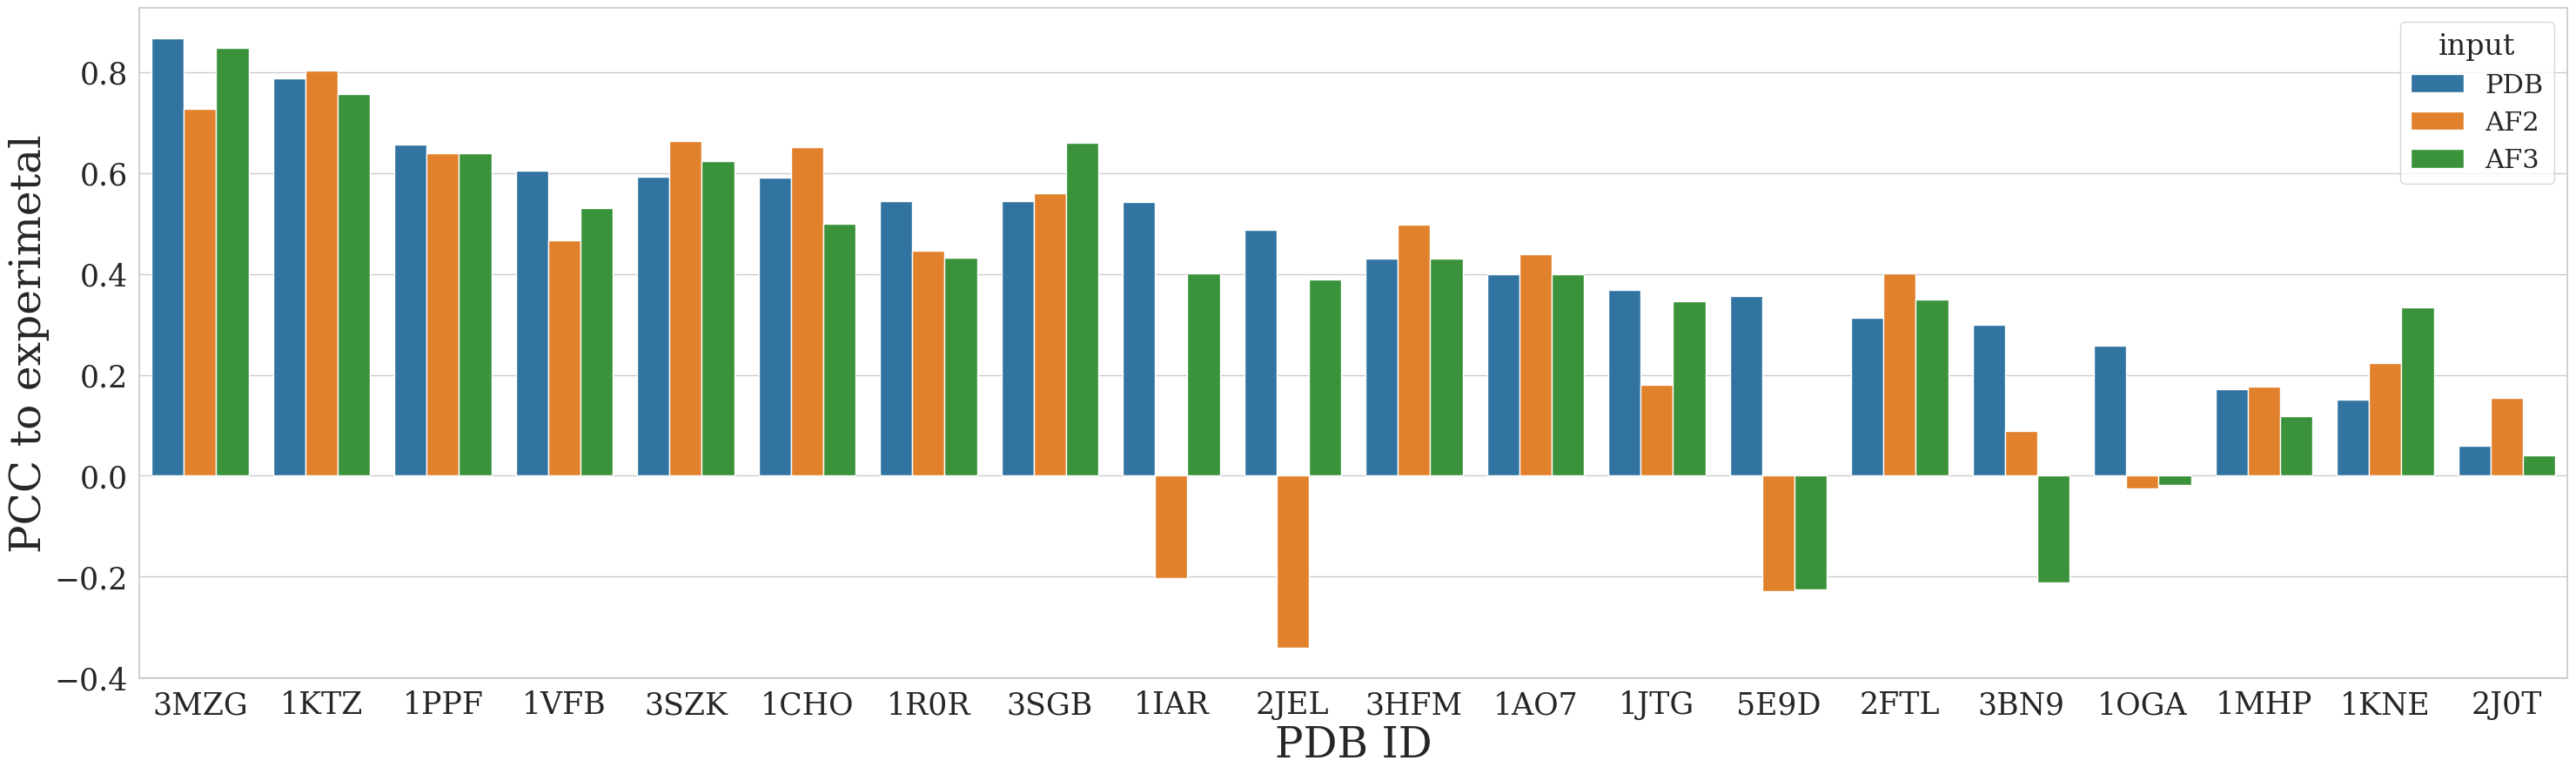

In [26]:
metric = 'PCC'

pdb_pcc = sm[['PDB_ID', f'PDB_{metric}']].copy()
pdb_pcc['input'] = 'PDB'
pdb_pcc.rename(columns={f'PDB_{metric}': metric}, inplace=True)
              
af2_pcc = sm[['PDB_ID', f'AF2_{metric}']].copy()
af2_pcc['input'] = 'AF2'
af2_pcc.rename(columns={f'AF2_{metric}': metric}, inplace=True)

af3_pcc = sm[['PDB_ID', f'AF3_{metric}']].copy()
af3_pcc['input'] = 'AF3'
af3_pcc.rename(columns={f"AF3_{metric}": metric}, inplace=True)

barplot_material_pcc = pd.concat([pdb_pcc, af2_pcc, af3_pcc])

custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
fig, ax = plt.subplots(figsize=(36, 10))
ax = sns.barplot(barplot_material_pcc, x="PDB_ID",
                 y="PCC", hue="input",
                palette=custom_colors, order=pdb_pcc.sort_values('PCC', ascending=False)['PDB_ID'].values)

plt.xlabel('PDB ID', fontsize=35)
plt.ylabel('PCC to experimetal', fontsize=35)
    
plt.savefig('Figures/SAFES_PCC_per_PDB_suppl.pdf', format='pdf')

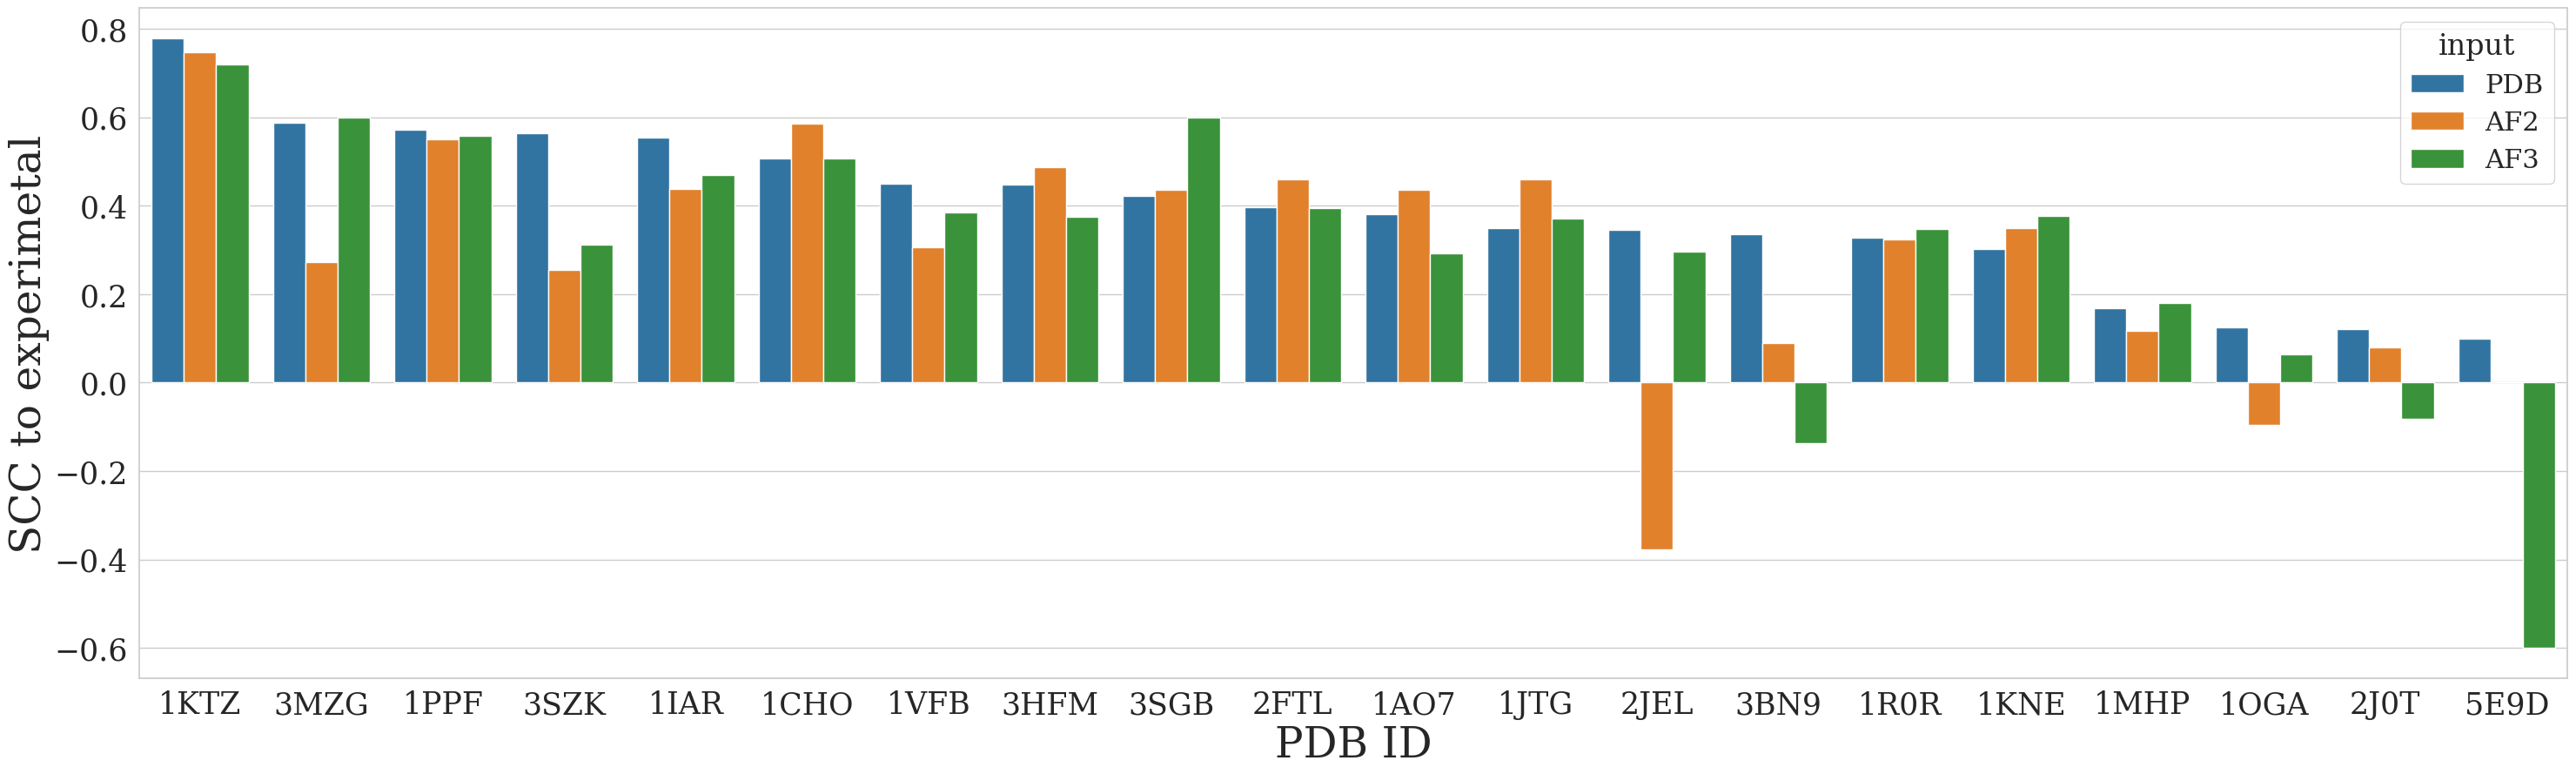

In [27]:
metric = 'SCC'

pdb = sm[['PDB_ID', f'PDB_{metric}']].copy()
pdb['input'] = 'PDB'
pdb.rename(columns={f'PDB_{metric}': metric}, inplace=True)
              
af2 = sm[['PDB_ID', f'AF2_{metric}']].copy()
af2['input'] = 'AF2'
af2.rename(columns={f'AF2_{metric}': metric}, inplace=True)

af3 = sm[['PDB_ID', f'AF3_{metric}']].copy()
af3['input'] = 'AF3'
af3.rename(columns={f"AF3_{metric}": metric}, inplace=True)

barplot_material_scc = pd.concat([pdb, af2, af3])

custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
fig, ax = plt.subplots(figsize=(36, 10))
ax = sns.barplot(barplot_material_scc, x="PDB_ID",
                 y="SCC", hue="input",
                palette=custom_colors, order=pdb.sort_values('SCC', ascending=False)['PDB_ID'].values)

plt.xlabel('PDB ID', fontsize=35)
plt.ylabel('SCC to experimetal', fontsize=35)
    
plt.savefig('Figures/SAFES_SCC_per_PDB_suppl.pdf', format='pdf')

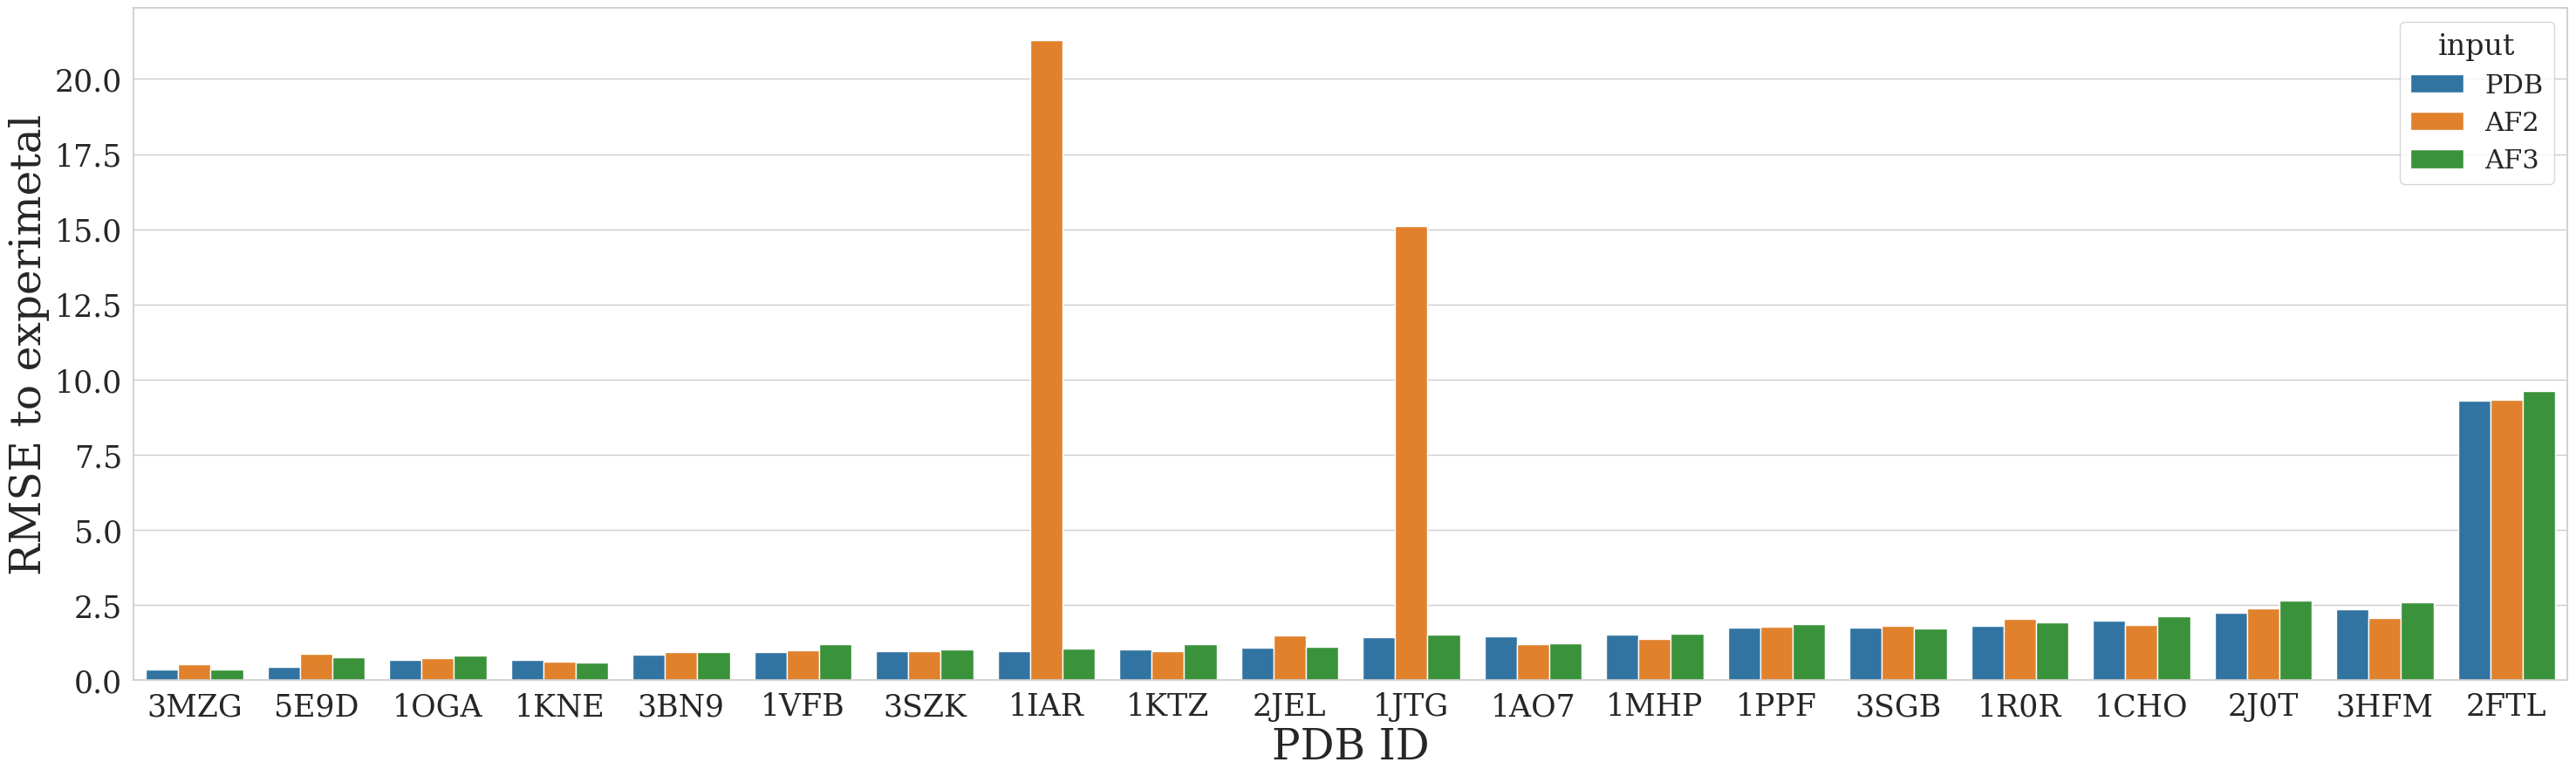

In [28]:
metric = 'RMSE'

pdb = sm[['PDB_ID', f'PDB_{metric}']].copy()
pdb['input'] = 'PDB'
pdb.rename(columns={f'PDB_{metric}': metric}, inplace=True)
              
af2 = sm[['PDB_ID', f'AF2_{metric}']].copy()
af2['input'] = 'AF2'
af2.rename(columns={f'AF2_{metric}': metric}, inplace=True)

af3 = sm[['PDB_ID', f'AF3_{metric}']].copy()
af3['input'] = 'AF3'
af3.rename(columns={f"AF3_{metric}": metric}, inplace=True)

barplot_material_rmse = pd.concat([pdb, af2, af3])

custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
fig, ax = plt.subplots(figsize=(36, 10))
ax = sns.barplot(barplot_material_rmse, x="PDB_ID",
                 y="RMSE", hue="input",
                palette=custom_colors, order=pdb.sort_values('RMSE', ascending=True)['PDB_ID'].values)

plt.xlabel('PDB ID', fontsize=35)
plt.ylabel('RMSE to experimetal', fontsize=35)
    
plt.savefig('Figures/SAFES_RMSE_per_PDB_suppl.pdf', format='pdf')

In [134]:
ddG_df_list_complex = list()
for pdb_id in pdb_list:
    path_to_output = f'/groups/sbinlab/panf/SKEMPIv2/Cart_ddG_beta_new/{pdb_id}/output'
    try:
        l_o = len(os.listdir(path_to_output))
    except:
        continue
        
    if l_o > 0:
        for file in os.listdir(path_to_output):
            if file.startswith('prism_rosetta_'):
                if not file.endswith('-gap.txt'):
                    path_to_prism = os.path.join(path_to_output, file)
                    x = pd.read_csv(path_to_prism, sep=" ", comment='#')
                    x['PDB_ID'] = pdb_id
                    ddG_df_list_complex.append(x)
                    
all_cases_muts = pd.concat(ddG_df_list_complex)
variants = all_cases_muts[~all_cases_muts.variant.str.contains(r'=')].copy()
variants.reset_index(drop=True, inplace=True)

In [135]:
variants.rename(columns={"mean_ddG": "mean_ddG_old", "std_ddG": "std_ddG_old"}, inplace=True)

In [136]:
olds = pd.merge(SAFES_exp, variants, on=['PDB_ID', 'variant'])

In [139]:
olds['mean_ddG_old'].min()

-3.2355172413793234

In [140]:
olds['mean_ddG_old'].max()

11.972298850574695

In [160]:
olds.loc[abs(olds['mean_ddG_xtal']-olds['mean_ddG_old'])>0.8][['PDB_ID', 'variant', 'mean_ddG_xtal', 'mean_ddG_old']]

PDB_ID variant  mean_ddG_xtal  mean_ddG_old
3     1R0R   A284F       1.467701      4.237471
5     1R0R   A284H       3.024943      4.647816
8     1R0R   A284L       1.311609      0.394368
17    1R0R   A284W       6.609080      8.844943
22    1R0R   E288F      -0.491494      0.500230
51    1R0R   G301R      -1.315977     -0.382874
65    1R0R   K282L       0.667126     -0.310460
162   1R0R   T286L       1.138161     -0.235402
249   1PPF   G250F       3.957701      5.592644
251   1PPF   G250I      11.403908      6.876207
252   1PPF   G250K       6.871724      7.967586
254   1PPF   G250M       4.463218      3.482529
258   1PPF   G250R       4.704483      7.428621
301   1PPF   L236Y       6.267241      3.885862
308   1PPF   N254H      -1.523103     -0.524828
313   1PPF   N254P       2.283448      5.833333
390   1PPF   Y238P      12.843563     11.972299
610   3SGB   Y199P      10.533678      8.499770
621   1IAR    F82D       1.589655      2.418621
639   1IAR    R81A       0.825172     -0.014943
640   1IAR    R81E       1.591609     -0.030920
641   1IAR    R85A       2.631264      1.087011
642   1IAR    R85E       3.848391      2.908966
643   1IAR    R88A       2.689310      1.688621
651   1IAR    W91A       2.980230      1.331954
652   1IAR    W91D       4.698851      2.776897

<Axes: >

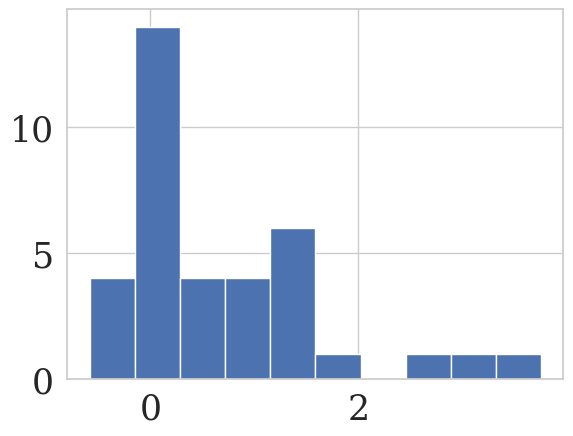

In [167]:
skempiMAX_cart_ddg_IA.loc[skempiMAX_cart_ddg_IA['PDB_ID']=='1IAR']['ddG_bind'].hist()

In [161]:
olds.loc[olds['mean_ddG_infc_af2']<-5]

PDB_ID variant  mean_ddG_xtal  std_ddG_xtal  mean_ddG_infc_xtal  \
406   1JTG    E85G       1.901724      0.021105            0.925989   
619   1IAR     E9Q       0.796552      0.001463            0.293840   
620   1IAR    F82A       1.998506      0.083674            0.854625   
633   1IAR    N89A       0.676782      0.001417            1.132027   

     std_ddG_infc_xtal  mean_ddG_af2  std_ddG_af2  mean_ddG_infc_af2  \
406           0.021456      2.250575     0.006605        -113.522544   
619           0.001825      0.152414     0.014955         -39.058904   
620           0.153423      2.608161     0.197121         -35.961483   
633           0.001909     -1.501954     1.477609        -113.383155   

     std_ddG_infc_af2  ...  LChains  RChains  Chains  small-to-large  \
406          0.010604  ...        A        B      AB           False   
619         53.650306  ...        A        B      AB            True   
620         53.633374  ...        A        B      AB           False   
633          0.979278  ...        A        B      AB           False   

      type_of_change_infc     type_of_change_aa  interaction_strength  N_mut  \
406  non-infc to non-infc   negative to special                strong      1   
619  non-infc to non-infc     negative to polar                strong      1   
620      infc to non-infc             same type                strong      1   
633  non-infc to non-infc  polar to hydrophobic                strong      1   

    mean_ddG_old std_ddG_old  
406     1.950115    0.000650  
619     0.835287    0.005717  
620     2.337931    0.607308  
633     0.691724    0.007315  

[4 rows x 62 columns]

In [156]:
olds.loc[(olds['PDB_ID']=='1IAR')&(abs(olds['mean_ddG_xtal']-olds['mean_ddG_old'])>0.2)]

PDB_ID variant  mean_ddG_xtal  std_ddG_xtal  mean_ddG_infc_xtal  \
617   1IAR    E19A       0.027356      0.077700            0.000561   
618   1IAR    E19R      -0.851609      0.000813           -0.002132   
620   1IAR    F82A       1.998506      0.083674            0.854625   
621   1IAR    F82D       1.589655      0.001463            0.663690   
628   1IAR    K77E       0.001494      0.049748           -0.007151   
632   1IAR    N15D      -0.840575      0.105335           -0.047849   
635   1IAR    Q78E       0.305057      0.066898            0.061107   
638   1IAR    R53Q       1.653333      0.064920            1.009649   
639   1IAR    R81A       0.825172      0.066078            0.952923   
640   1IAR    R81E       1.591609      0.931760            1.533818   
641   1IAR    R85A       2.631264      0.044892            2.642025   
642   1IAR    R85E       3.848391      0.006665            4.177844   
643   1IAR    R88A       2.689310      2.067006            2.967732   
644   1IAR    R88Q       2.247241      0.040387            2.331715   
645   1IAR    S16A      -0.448966      0.000000            0.005030   
648   1IAR    T13D       1.575287      0.002235           -0.071688   
650   1IAR     T6D       2.982414      0.118747            1.169482   
651   1IAR    W91A       2.980230      0.000586            2.046031   
652   1IAR    W91D       4.698851      0.170603            1.950430   

     std_ddG_infc_xtal  mean_ddG_af2   std_ddG_af2  mean_ddG_infc_af2  \
617           0.000196      0.248046  1.447538e-01          -0.850539   
618           0.000300     -0.157126  1.273045e-01          -0.848948   
620           0.153423      2.608161  1.971210e-01         -35.961483   
621           0.000320      2.912184  4.300756e-04           2.006789   
628           0.002178      0.143678  7.969936e-02          -0.536522   
632           0.002806      0.007701  8.673617e-19          -1.005735   
635           0.003780      0.209195  2.957398e-03          -0.601898   
638           0.003039      0.331149  1.610905e-01           1.235582   
639           0.001771      0.755402  4.102659e-03           2.412026   
640           0.276614     -0.610115  1.494764e+00           1.848984   
641           0.060304      1.356322  7.449127e-04           3.545181   
642           0.003986      1.391149  1.445424e+00           4.138679   
643           0.409152      2.023218  1.000645e+00           1.774320   
644           0.279216      3.448506  1.309367e-01           3.324940   
645           0.000000     -0.548391  0.000000e+00          -1.117066   
648           0.001396      1.221264  2.815505e-04          -0.303511   
650           0.131553      3.674368  1.499919e-01           1.641981   
651           0.001276      0.548391  1.330556e-03           1.499399   
652           0.139015      2.797126  0.000000e+00           1.362605   

     std_ddG_infc_af2  ...  LChains  RChains  Chains  small-to-large  \
617      2.377648e-01  ...        A        B      AB           False   
618      2.389343e-01  ...        A        B      AB            True   
620      5.363337e+01  ...        A        B      AB           False   
621      2.467431e-02  ...        A        B      AB           False   
628      4.413347e-01  ...        A        B      AB           False   
632      1.847476e-13  ...        A        B      AB           False   
635      6.375850e-02  ...        A        B      AB           False   
638      2.288376e-01  ...        A        B      AB           False   
639      6.590822e-02  ...        A        B      AB           False   
640      9.322629e-01  ...        A        B      AB           False   
641      4.022071e-02  ...        A        B      AB           False   
642      9.908696e-01  ...        A        B      AB           False   
643      7.775509e-01  ...        A        B      AB           False   
644      1.989811e-01  ...        A        B      AB           False   
645      0.000000e+00  ...        A       

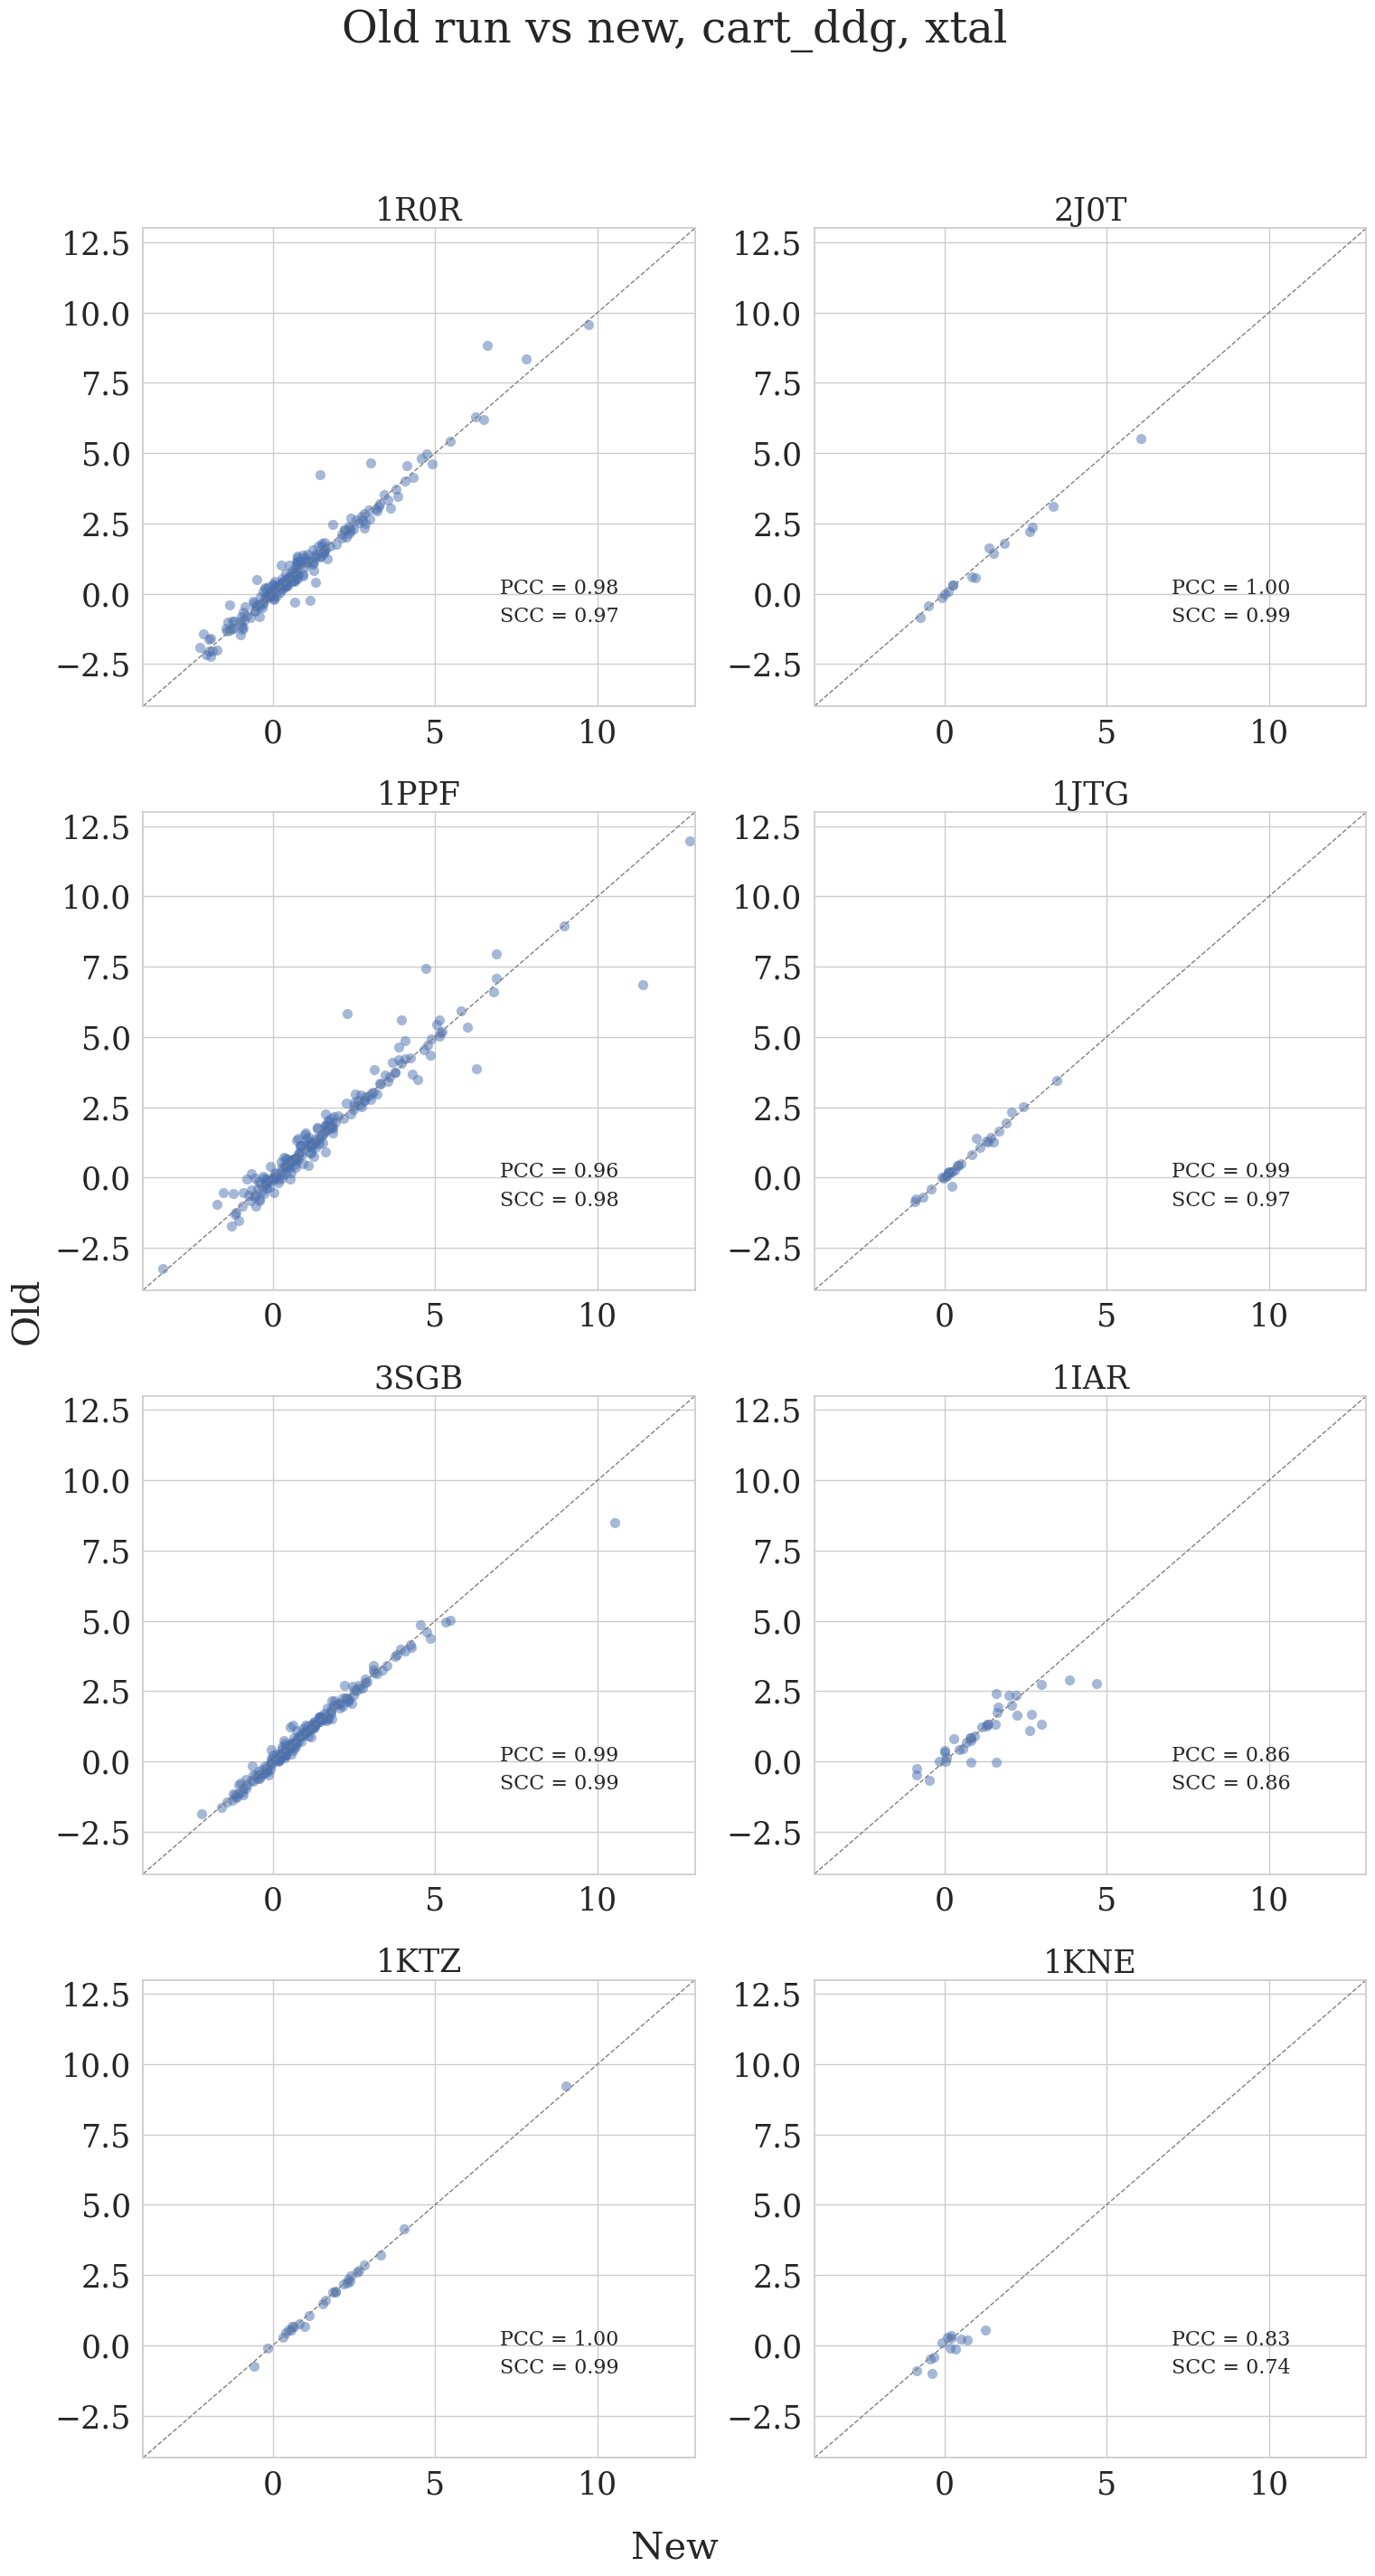

In [153]:
fig, axes = plt.subplots(4, 2, figsize=(16, 30))
axes = axes.flatten()
# Calculate the min and max values
df=olds.copy()
plt.setp(axes, xlim=(-4, 13), ylim=(-4, 13))

for ax, pdb_id in zip(axes, ['1R0R', '2J0T', '1PPF', '1JTG', '3SGB', '1IAR', '1KTZ', '1KNE']):
    subset = df.loc[df['PDB_ID']==pdb_id]
    plot = sns.scatterplot(data = subset, x='mean_ddG_xtal',
                       y='mean_ddG_old',
                       alpha=0.5, s=65, linewidth=0, ax=ax)
    plot.set_title(pdb_id, fontsize=25)
    ax.plot([-4, 14], [-4, 14], color='gray', ls='--', lw=1)
    r, p = stats.pearsonr(subset['mean_ddG_xtal'], subset['mean_ddG_old'])
    plot.annotate(f'PCC = {r:.2f}', xy=(7, 0), fontsize = 16)
    r, p = stats.spearmanr(subset['mean_ddG_xtal'], subset['mean_ddG_old'])
    plot.annotate(f'SCC = {r:.2f}', xy=(7, -1), fontsize = 16)
    ## ADD AXIS LIMITS
    ax.set_xlabel('')  # Remove individual x labels
    ax.set_ylabel('')

fig.suptitle('Old run vs new, cart_ddg, xtal', fontsize=35)
fig.text(0.5, 0.04, 'New', ha='center', fontsize=30)  # x label
fig.text(0.04, 0.5, 'Old', va='center', rotation='vertical', fontsize=30)
# # Set specific tick intervals for x and y axes
# plt.xticks(np.arange(-2.5, 3, 0.2))
# #plt.yticks(np.arange(-2.5, 3, 0.5))
# plt.show()
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
# fig.savefig('/Users/jhn949/Documents/Data/PPI/Review/scatterplots_by_substitution_mCSM.pdf', format='pdf')

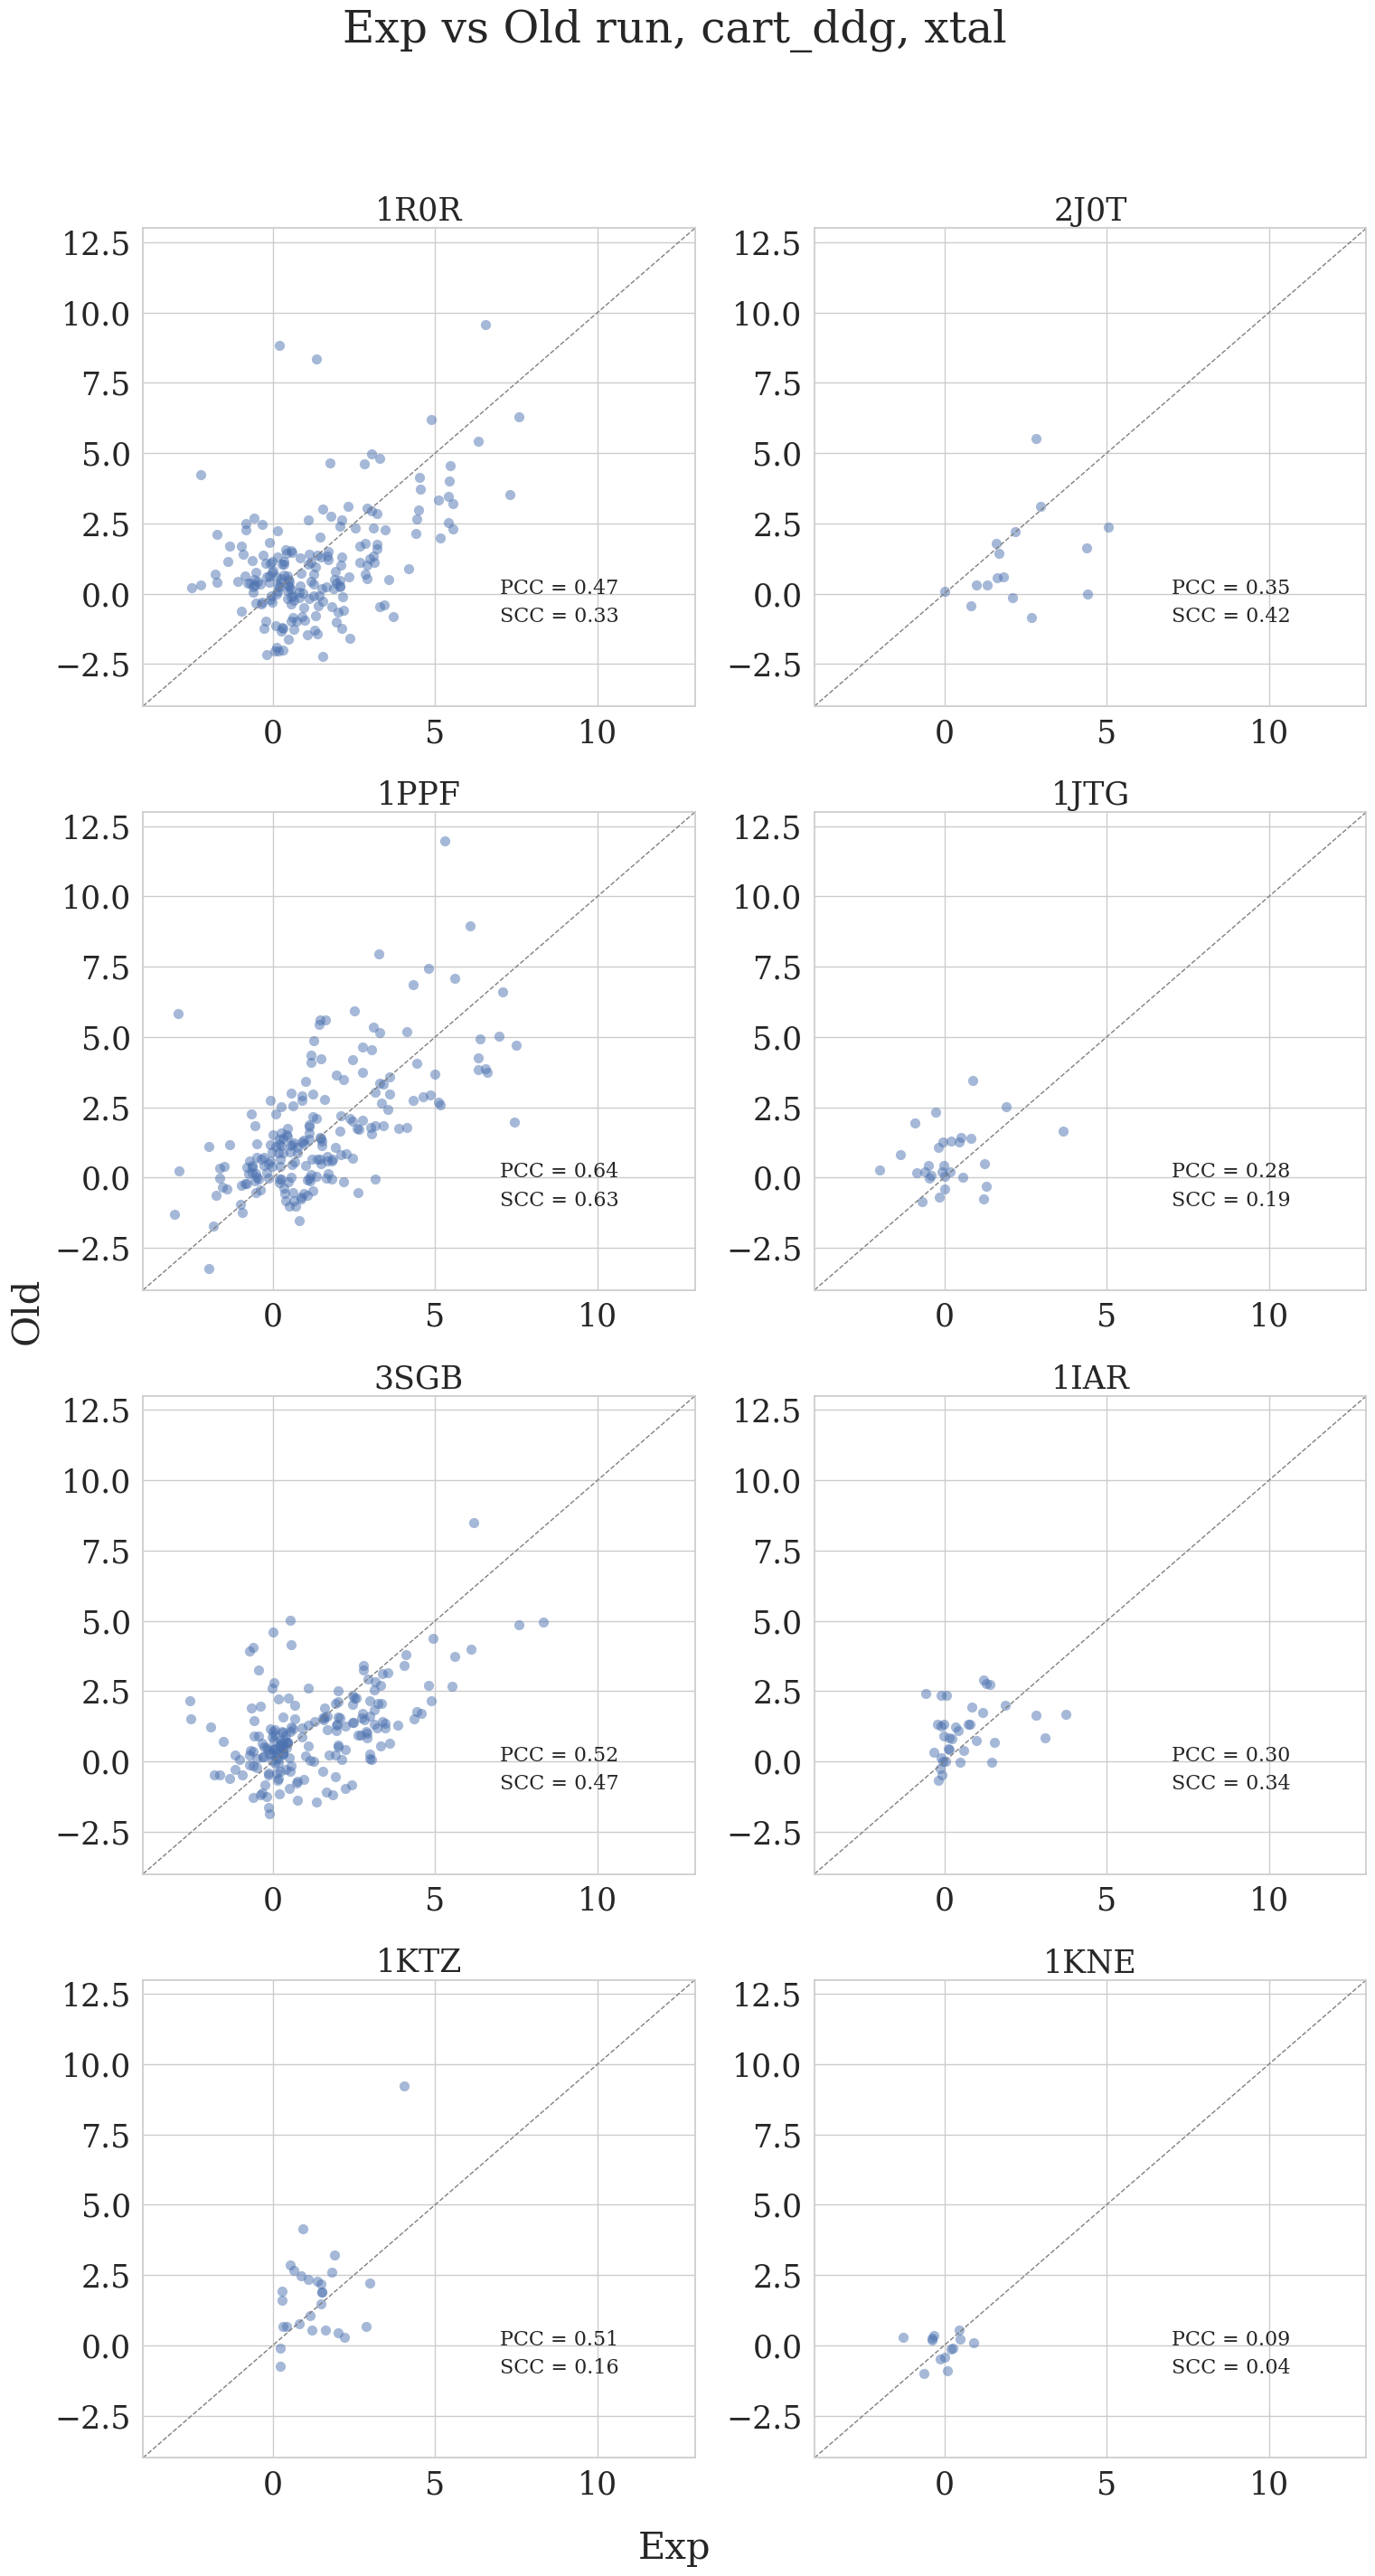

In [141]:
fig, axes = plt.subplots(4, 2, figsize=(16, 30))
axes = axes.flatten()
# Calculate the min and max values
df=olds.copy()
plt.setp(axes, xlim=(-4, 13), ylim=(-4, 13))

for ax, pdb_id in zip(axes, ['1R0R', '2J0T', '1PPF', '1JTG', '3SGB', '1IAR', '1KTZ', '1KNE']):
    subset = df.loc[df['PDB_ID']==pdb_id]
    plot = sns.scatterplot(data = subset, x='ddG_bind',
                       y='mean_ddG_old',
                       alpha=0.5, s=65, linewidth=0, ax=ax)
    plot.set_title(pdb_id, fontsize=25)
    ax.plot([-4, 14], [-4, 14], color='gray', ls='--', lw=1)
    r, p = stats.pearsonr(subset['ddG_bind'], subset['mean_ddG_old'])
    plot.annotate(f'PCC = {r:.2f}', xy=(7, 0), fontsize = 16)
    r, p = stats.spearmanr(subset['ddG_bind'], subset['mean_ddG_old'])
    plot.annotate(f'SCC = {r:.2f}', xy=(7, -1), fontsize = 16)
    ## ADD AXIS LIMITS
    ax.set_xlabel('')  # Remove individual x labels
    ax.set_ylabel('')

fig.suptitle('Exp vs Old run, cart_ddg, xtal', fontsize=35)
fig.text(0.5, 0.04, 'Exp', ha='center', fontsize=30)  # x label
fig.text(0.04, 0.5, 'Old', va='center', rotation='vertical', fontsize=30)
# # Set specific tick intervals for x and y axes
# plt.xticks(np.arange(-2.5, 3, 0.2))
# #plt.yticks(np.arange(-2.5, 3, 0.5))
# plt.show()
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
# fig.savefig('/Users/jhn949/Documents/Data/PPI/Review/scatterplots_by_substitution_mCSM.pdf', format='pdf')

In [142]:
avg = list()
for pdb_id in ['1R0R', '2J0T', '1PPF', '1JTG', '3SGB', '1IAR', '1KTZ', '1KNE']:
    
    if pdb_id in ['1PPF', '1KNE']:
        print(pdb_id, '!!PTM!!')
    else:
        print(pdb_id)
    
    subset = olds.loc[olds['PDB_ID']==pdb_id]
    
    r, _ = stats.pearsonr(subset['mean_ddG_xtal'], subset['mean_ddG_old'])
    print('New to old', r)

    r_n, _ = stats.pearsonr(subset['mean_ddG_xtal'], subset['ddG_bind'])
    print('New to exp', r_n)

    r_o, _ = stats.pearsonr(subset['mean_ddG_old'], subset['ddG_bind'])
    print('old to exp', r_o)

    print('diff:', abs(r_n-r_o))
    avg.append(abs(r_n-r_o))

1R0R
New to old 0.9769531750561475
New to exp 0.5019397220936985
old to exp 0.46971581397049084
diff: 0.03222390812320769
2J0T
New to old 0.9951105004656123
New to exp 0.3371855649104628
old to exp 0.34984447952996395
diff: 0.012658914619501138
1PPF !!PTM!!
New to old 0.962351151677294
New to exp 0.6521404236664818
old to exp 0.6358326721654157
diff: 0.016307751501066114
1JTG
New to old 0.9894769413882408
New to exp 0.29258032142688456
old to exp 0.2778572336520957
diff: 0.014723087774788868
3SGB
New to old 0.9897697909535033
New to exp 0.4907212412696058
old to exp 0.5203140031930866
diff: 0.029592761923480815
1IAR
New to old 0.857277592735454
New to exp 0.4417182182487214
old to exp 0.29813767697128074
diff: 0.14358054127744063
1KTZ
New to old 0.9989612195923907
New to exp 0.5223552042736018
old to exp 0.5076429883637266
diff: 0.01471221590987526
1KNE !!PTM!!
New to old 0.8311760837468548
New to exp 0.1706802587311114
old to exp 0.09157642925169562
diff: 0.07910382947941577


In [146]:
np.mean(avg)

0.04286287632609704

In [147]:
np.median(avg)

0.022950256712273465

In [149]:
sm.columns

Index(['PDB_ID', 'RMSD_AF2', 'pTM_AF2', 'ipTM_AF2', 'RMSD_AF3', 'pTM_AF3',
       'ipTM_AF3', 'Number of chains', 'PDB_PCC', 'PDB_SCC', 'PDB_RMSE',
       'AF2_PCC', 'AF2_SCC', 'AF2_RMSE', 'AF2_PCC_xtal', 'AF2_SCC_xtal',
       'AF3_PCC', 'AF3_SCC', 'AF3_RMSE', 'AF3_PCC_xtal', 'AF3_SCC_xtal',
       'PCC_AF2_diff', 'PCC_AF3_diff', 'SCC_AF2_diff', 'SCC_AF3_diff',
       'RMSE_AF2_diff', 'RMSE_AF3_diff', 'ipTM_AF2_cutoff', 'ipTM_AF3_cutoff',
       'PCC_AF2_cutoff', 'SCC_AF2_cutoff', 'PCC_AF3_cutoff', 'SCC_AF3_cutoff',
       'PCC_AF2_xtal_cutoff', 'SCC_AF2_xtal_cutoff', 'PCC_AF3_xtal_cutoff',
       'SCC_AF3_xtal_cutoff', 'RMSD_AF2_cutoff', 'RMSD_AF3_cutoff'],
      dtype='object')

In [151]:
sm[['PDB_ID']+[c for c in sm.columns if c.endswith('_diff')]]

PDB_ID  PCC_AF2_diff  PCC_AF3_diff  SCC_AF2_diff  SCC_AF3_diff  \
0    1AO7     -0.038802      0.001174     -0.055362      0.088662   
1    1CHO     -0.061276      0.090600     -0.079123     -0.001099   
2    1IAR      0.746873      0.141673      0.114937      0.082888   
3    1JTG      0.187390      0.022646     -0.109023     -0.021189   
4    1KNE     -0.071457     -0.183032     -0.046768     -0.074278   
5    1KTZ     -0.015537      0.030911      0.031136      0.059219   
6    1MHP     -0.005506      0.053718      0.051766     -0.010057   
7    1OGA      0.282897      0.275140      0.220492      0.060368   
8    1PPF      0.017250      0.017917      0.021540      0.013357   
9    1R0R      0.099580      0.112654      0.002924     -0.020839   
10   1VFB      0.137698      0.074413      0.141902      0.063638   
11   2FTL     -0.089135     -0.037445     -0.063158      0.003008   
12   2J0T     -0.096453      0.018865      0.041176      0.202941   
13   2JEL      0.828634      0.098194      0.722089      0.049416   
14   3BN9      0.210146      0.510409      0.246177      0.471296   
15   3HFM     -0.066071      0.001222     -0.038985      0.072588   
16   3MZG      0.140013      0.019125      0.315152     -0.012121   
17   3SGB     -0.014878     -0.114015     -0.013872     -0.177925   
18   3SZK     -0.070971     -0.030754      0.309044      0.252440   
19   5E9D      0.584092      0.581533      0.100000      0.700000   

    RMSE_AF2_diff  RMSE_AF3_diff  
0        0.273926       0.245797  
1        0.166557      -0.137145  
2      -20.314773      -0.078379  
3      -13.678684      -0.071970  
4        0.075433       0.104448  
5        0.067073      -0.171478  
6        0.152760      -0.027283  
7       -0.049461      -0.127240  
8       -0.035618      -0.125639  
9       -0.237812      -0.134109  
10      -0.060063      -0.263912  
11      -0.035658      -0.312489  
12      -0.142917      -0.407455  
13      -0.403764      -0.014871  
14      -0.096168      -0.100749  
15       0.291114      -0.207218  
16      -0.176661      -0.000856  
17      -0.062354       0.035577  
18      -0.004051      -0.057726  
19      -0.427118      -0.308261